In [1]:
'''

load original df

'''

import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
import re
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once

dataFilePath = os.path.join(os.getcwd(),'Data')

#kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
#lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
sns.set(font_scale=1.5)

dog = kicsTEdf.columns
print(dog.tolist())
print(kicsTEdf.head(30))
print(lfsTEdf.columns)
print(lfsTEdf.head(30))

#keep SV_chrom, SV_length, SV_type, Location, Location2, 

#AnnotSV type => Annotation_mode



['AnnotSV_ID', 'SV_chrom', 'SV_start', 'SV_end', 'SV_length', 'SV_type', 'Samples_ID', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'xTea', 'MELT', 'Annotation_mode', 'CytoBand', 'Gene_name', 'Gene_count', 'Tx', 'Tx_start', 'Tx_end', 'Overlapped_tx_length', 'Overlapped_CDS_length', 'Overlapped_CDS_percent', 'Frameshift', 'Exon_count', 'Location', 'Location2', 'Dist_nearest_SS', 'Nearest_SS_type', 'Intersect_start', 'Intersect_end', 'RE_gene', 'P_gain_phen', 'P_gain_hpo', 'P_gain_source', 'P_gain_coord', 'P_loss_phen', 'P_loss_hpo', 'P_loss_source', 'P_loss_coord', 'P_ins_phen', 'P_ins_hpo', 'P_ins_source', 'P_ins_coord', 'P_snvindel_nb', 'P_snvindel_phen', 'B_gain_source', 'B_gain_coord', 'B_gain_AFmax', 'B_loss_source', 'B_loss_coord', 'B_loss_AFmax', 'B_ins_source', 'B_ins_coord', 'B_ins_AFmax', 'B_inv_source', 'B_inv_coord', 'B_inv_AFmax', 'TAD_coordinate', 'ENCODE_experiment', 'GC_content_left', 'GC_content_right', 'Repeat_coord_left', 'Repeat_type_left', 'Repeat_coord_r

In [3]:
"""
Kics clinic df cleaning
"""
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


In [4]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
        
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

In [5]:
"""
'ALT' Clean up
"""

kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace("<INS:ME:","")
kicsTEdf['ALT'] = kicsTEdf['ALT'].str.replace(">","")

lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace("<INS:ME:","")
lfsTEdf['ALT'] = lfsTEdf['ALT'].str.replace(">","")
print(lfsTEdf['ALT'].value_counts())

#print(lfsTEdf['ALT'].value_counts())

ALU      90163
LINE1     4342
SVA       2712
Name: ALT, dtype: int64


In [6]:
"""
Filtering and cleaning Samples_ID
"""
kicsTEF = kicsTEdf.loc[(kicsTEdf['Annotation_mode'] == 'full')]
lfsTEF = lfsTEdf.loc[(lfsTEdf['Annotation_mode'] == 'full')]

kicsTEF['SV_chrom'] = kicsTEF['SV_chrom'].astype(str)
lfsTEF['SV_chrom'] = lfsTEF['SV_chrom'].astype(str)

kicsTEF['Samples_ID'] = kicsTEF['Samples_ID'].astype(str).str.replace(".realigned-recalibrated","")
lfsTEF['Samples_ID'] = lfsTEdf['Samples_ID'].astype(str).str.replace('.realigned-recalibrated', '')

kicsTEF.drop(kicsTEF.loc[pd.isna(kicsTEF['Samples_ID'])].index, inplace=True)
lfsTEF.drop(lfsTEF.loc[pd.isna(lfsTEF['Samples_ID'])].index, inplace=True)

kicsTEnum = kicsTEF['Samples_ID'].count()
lfsTEnum = lfsTEF['Samples_ID'].count()

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
for i in listValSearch: 
    kicsTEF.drop(kicsTEF[kicsTEF['Samples_ID'].str.contains(i)==True].index, inplace = True)
    

mergedTEdf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 'kChrom':kicsTEF['SV_chrom'], 
                                  'kAlt':kicsTEF['ALT'], 'lAlt':lfsTEF['ALT'],
                                  'kID':kicsTEF['Samples_ID'], 'lID': lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type'], 'lChrom':lfsTEF['SV_chrom']})

In [7]:
"""
Cleaning kics ids
"""
def kIdAbbv(clinicDf, svDf, clinicCol, svCol):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
    
    df = pd.merge(svDf[[svCol,'SV_type','abbv_id','ALT']],                   
                     clinicDf,
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')
    return df

In [8]:
"""
Make big k df
"""
UberbigKdf = kIdAbbv(kicsClinicdf, kicsTEF, 'CCP germline', 'Samples_ID')

bigKdf = UberbigKdf[['CCP germline', 'Samples_ID', 'tumour_class','tissue_type',
                    'lfs_cancer_type_diagnosis', 'abbv_id','diagnosis_age (days)', 'SV_type','abbv_id','ALT']]


79


In [9]:
"""
Make a big lfs df
"""
UberbigLdf = pd.merge(lfsTEF[['Samples_ID','SV_type','ALT']],
                 lfsClinicdf,
                 left_on = 'Samples_ID',
                 right_on = 'sample',
                 how='inner')

bigLdf = UberbigLdf[['Samples_ID','SV_type','ALT','sample','tissue_type','cancer_diagnosis','ageofonset']]
             
bigKdf = bigKdf.rename(columns={'diagnosis_age (days)': 'ageofonset', 'CCP germline':'sample',
                                'lfs_cancer_type_diagnosis':'cancer_diagnosis'})


# RMS and Soft Tissue

In [10]:
#RMS and Soft tissue breakdown
kDf = UberbigKdf[['Samples_ID', 'ALT', 'abbv_id', 'KiCS ID', 'ICDO-diagnosis',
       'tissue_type', 'lfs_cancer_type_diagnosis','Previous cancers', 'Germline Sample from',
       'Germline sample type', 'CCP germline.1', 'WGS DNA germline',
       'WGS germline', 'pathology_id', 'Sample type', 'CCP tumor', 'CCP PPID',
       'CCP', 'WGS tumor ID', 'WGS Tumor', 'RNA ID', 'RNA',
       'single_somatic_specimen', 'disease_state', 'sample_type',
       'post_treatment', 'sample site', 'tumour_class', 'Sex',
       'diagnosis_age (days)', 'no_chemo_or_xrt']]

#use ICDO-diagnosis

lDf = UberbigLdf[['Samples_ID','ALT', 'sample',
       'tm_donor', 'tissue_type', 'cancer_diagnosis', 'active_cancer',
       'gender', 'systemic_treatment_atdraw', 'ageofonset', 'agesamplecollection',
       'cancer_num', 'cancer1_age_diff', 'cancer1', 'cancer1_ageofonset',
       'cancer2', 'cancer2_ageofonset', 'cancer3', 'cancer3_ageofonset',
       'cancer4', 'cancer4_ageofonset', 'cancer5', 'cancer5_ageofonset',
       'cancer6', 'cancer6_ageofonset', 'cancer7', 'cancer7_ageofonset',
       'cancer8', 'cancer8_ageofonset']]
#use Cancer 1

#overall diagnosis -> RMS and overall Soft Tissue tissue type <-
kST = kDf.loc[kDf['tissue_type']=='Soft Tissue']
kST = kST[['Samples_ID', 'ALT', 'ICDO-diagnosis', 'lfs_cancer_type_diagnosis']]
lST = lDf.loc[lDf['tissue_type']=='Soft Tissue']
lST = lST[['Samples_ID', 'ALT', 'cancer1', 'cancer_diagnosis']]

group = kST.drop(['ALT'],axis=1).groupby(['Samples_ID','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS Soft Tissue Mappings')
print(group)
print()

group1 = lST.drop(['ALT'],axis=1).groupby(['Samples_ID','cancer1']).value_counts().to_frame()
print('Overall LFS Soft Tissue Mappings')
print(group1)
print()

krms = kDf.loc[kDf['lfs_cancer_type_diagnosis']=='RMS']
krms = krms[['Samples_ID', 'ALT', 'ICDO-diagnosis', 'tissue_type']]
lrms = lDf.loc[lDf['cancer_diagnosis']=='RMS']
lrms = lrms[['Samples_ID', 'ALT', 'cancer1', 'tissue_type']]

group2 = krms.drop(['ALT'],axis=1).groupby(['Samples_ID','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS RMS Mappings')
print(group2)
print()

group2 = lrms.drop(['ALT'],axis=1).groupby(['Samples_ID','cancer1']).value_counts().to_frame()
print('Overall LFS RMS Mappings')
print(group2)
print()

Overall KiCS Soft Tissue Mappings
                                                                                  0
Samples_ID ICDO-diagnosis                           lfs_cancer_type_diagnosis      
273308     8920/3 - Alveolar rhabdomyosarcoma       RMS                        1948
284386     8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        4516
297043     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        1073
298866     8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        1096
305082     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        2178

Overall LFS Soft Tissue Mappings
                                                                 0
Samples_ID cancer1                        cancer_diagnosis        
1092       Malignant fibrous histiocytoma MFH                 1079
1355       Anaplastic ERMS                RMS                 1058
1843       High Grade Sarcoma             High Grade Sarcoma  1080
2085     

In [11]:
from matplotlib import pyplot as plt

def boxplotPoints(title:list, column:list, df: pd.DataFrame , sizeH=20.50, sizeV=17.50, col='red', trans=0.25, outliers = True):
    plt.rcParams["figure.figsize"] = [sizeH, sizeV]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({
        t: df[c] for t,c in zip(title, column)})
    
    #print(data)
    plotTest = data
    plotTest = plotTest.stack().to_frame().reset_index().rename(columns={'level_1': 'iden', 0: 'value'}).drop('level_0', axis='columns')
    plotTest['cat'] = 1
    #print(plotTest.head(50))
    #data.boxplot()
    #BoxGraphMulti(plotTest, 'cat', 'value', 'iden')
    sns.boxplot(data=plotTest, x='iden', y='value', medianprops={"linewidth": 8, "color": 'black'}, showfliers = outliers)
    
    #plot with boxplot
    if outliers:
        sns.stripplot(x = 'iden',
                  y = 'value',
                      color = 'red',
                      alpha = 0.25,
                  data = plotTest)
    
    list1 = df[column[0]].dropna()
    list2 = df[column[1]].dropna()
    print(mannwhitneyu(list1,list2))
    plt.show()

titles = ['kics','lfs']
columns = titles


In [12]:
"""

1. Graph for frequency of SV types
2. Graphs for frequency of SV types specific to chromosomes

Function to graph bar graphs

"""

def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
    
    plt.bar(x_axis - 0.2, [count1[a] for a in labels]/divisor1, 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a] for a in labels]/divisor2, 0.4, label = label2)

    plt.xticks(x_axis, labels)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()
    
xLabels = ['DEL','DUP','INV']
uniqueLabels = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']


In [13]:
"""

Testing group by

"""
#probably a better way to do this

kicsSVTypedf = pd.DataFrame(data = {'kics':kicsTEF['SV_type'], 
                                  'kId':kicsTEF['Samples_ID']})
lfsSVTypedf = pd.DataFrame(data = {'lId':lfsTEF['Samples_ID'],
                                  'lfs':lfsTEF['SV_type']})

#temp = mergedTEdf.groupby(['kId']).value_counts() #not sure how to use this, unsure if it's missing anything

##kics
ktemp = kicsSVTypedf.groupby(['kId']).value_counts()

##lfs
ltemp = lfsSVTypedf.groupby(['lId']).value_counts()

#print(ktemp.head(30))
#print(ktemp.index.get_level_values(0))

#get unique identifiers

uniqueK = kicsSVTypedf['kId'].unique()
uniqueL = lfsSVTypedf['lId'].unique()

#probably a better way, but itterate through the series and get the data 

def makeDataSet(identifiers, series: pd.Series, secondIndex: str)->list:
    
    dataList = []
    
    for i in identifiers:
        try:
            dataList.append(series[(i, secondIndex)])
        except:
            #pass
            dataList.append(0)

    return(dataList)


        
def makeUnequalDF(list1: list, list2: list) -> pd.DataFrame: #only for kics vs lfs D:
    tempDict = dict(kics = list1, lfs = list2)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in tempDict.items()]))
    return df

# SV Type

In [14]:
kINSData = makeDataSet(uniqueK, ktemp, 'INS')
#print(kINSData)
lINSData = makeDataSet(uniqueL, ltemp, 'INS')
#print(lINSData)
tempINSDF = makeUnequalDF(kINSData, lINSData)

#print(tempINSDF)

## INS

MannwhitneyuResult(statistic=3434.5, pvalue=0.00010322632415350713)


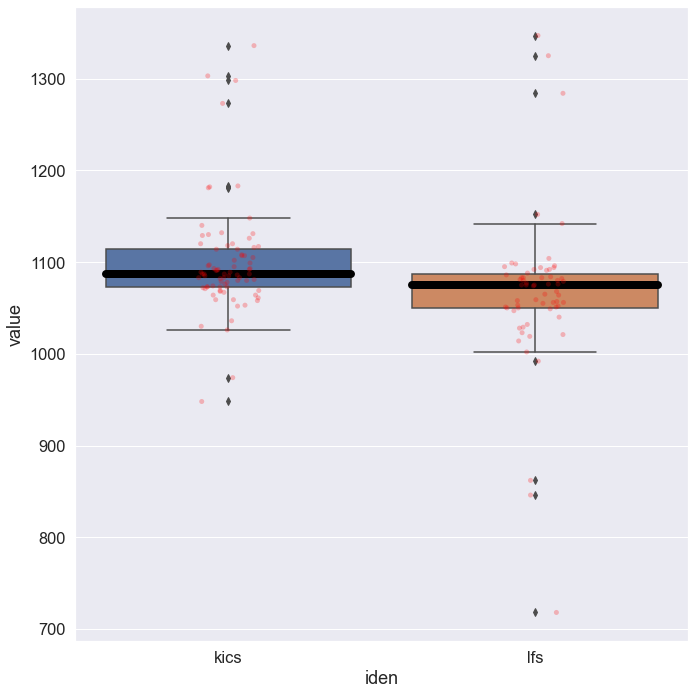

Index(['kics', 'lfs'], dtype='object')
Empty DataFrame
Columns: [kics, lfs]
Index: []


In [15]:
boxplotPoints(titles, columns, tempINSDF, 10, 10)

#print(mergedTEdf[mergedTEdf['lfs']<200])
print(tempINSDF.columns)

print(tempINSDF.loc[tempINSDF['lfs']<200])

In [16]:
"""

Chromosome Specific
Cleaned up

"""

def formatDataFrame(df: pd.DataFrame, groupByList: list, normalizeList: list, 
                    iterateList: list, labels: list, typeSV: str ) -> tuple:
    
    dfGrouped = df.groupby(groupByList).size().unstack(fill_value=0)
    #print(dfGrouped)
    dfReg = pd.DataFrame()
    dfNorm = pd.DataFrame()
    df1WC = pd.DataFrame()
    df2WC = pd.DataFrame()
    
    for i in iterateList:
        tempList = []
        
        try:
            series = dfGrouped.loc[(i,typeSV)]
            #print(series)
            
        except:
            series = pd.Series(0, index=labels)
            
        for j,div in zip(labels, normalizeList):
            tempList.append(series[j]/div)
            
        d = {'chrom':labels, 'normalized':tempList}
        tempdf = pd.DataFrame(d)

        dfNorm = pd.concat([dfNorm, tempdf], axis=0)
        dfReg = pd.concat([dfReg, series], axis=0) 
    
    return(dfReg, dfNorm)

def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol):
    orderList = ['1','2','3','4','5','6','7','8','9','10',
                '11','12','13','14','15','16','17','18','19','20','21','22','X','Y']
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'},
                order= orderList)
    
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        p1 = (i, 'kics')
        p2 = (i, 'lfs')
        p = (p1,p2)
        listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol,order=orderList)
    annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()
    


kicsMore = pd.DataFrame(data = {'SV':kicsTEF['SV_type'], 'chrom':kicsTEF['SV_chrom'], 
                                  'id':kicsTEF['Samples_ID']})
lfsMore = pd.DataFrame(data = {'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom'],
                                  'SV':lfsTEF['SV_type']})

numBPChrom = [249250621, 243199373, 198022430, 191154276, 180915260, 
              171115067, 159138663, 146364022, 141213431, 135534747,
              135006516, 133851895, 115169878, 107349540, 102531392,
              90354753, 81195210, 78077248, 59128983, 63025520,
              48129895, 51304566, 155270560, 59373566]

grouping = ['id', 'SV', 'chrom']


'''
If you have time, you should make it so that the plot can have the points showing/scattered plot
'''


'\nIf you have time, you should make it so that the plot can have the points showing/scattered plot\n'

ALT        ALU  LINE1  SVA dataset
id                                
19_18442   974     54   39    kics
245676     956     54   20    kics
271113    1019     48   28    kics
271114    1014     52   20    kics
271115    1030     55   35    kics
...        ...    ...  ...     ...
323274    1008     57   20    kics
328067    1097     50   34    kics
5510      1003     49   29    kics
5511      1031     48   28    kics
5547      1016     49   22    kics

[79 rows x 4 columns]


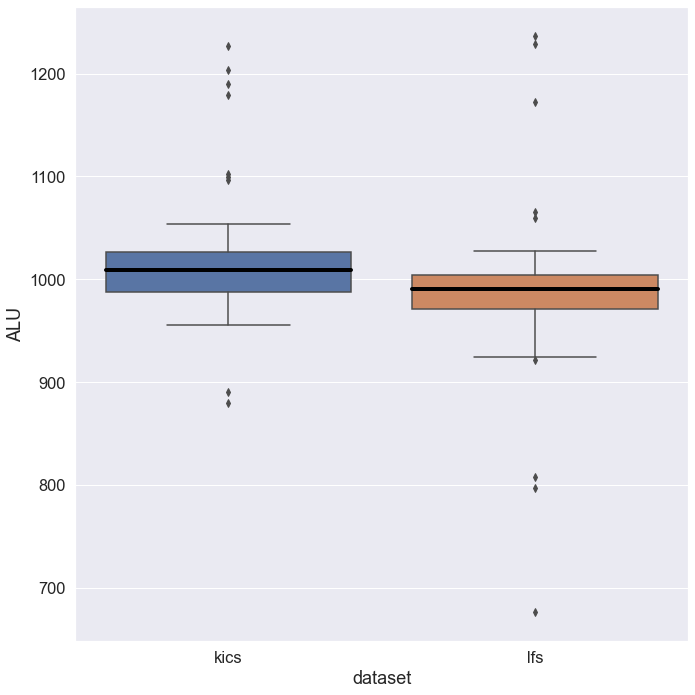

MannwhitneyuResult(statistic=3405.5, pvalue=0.00016735464124410167)


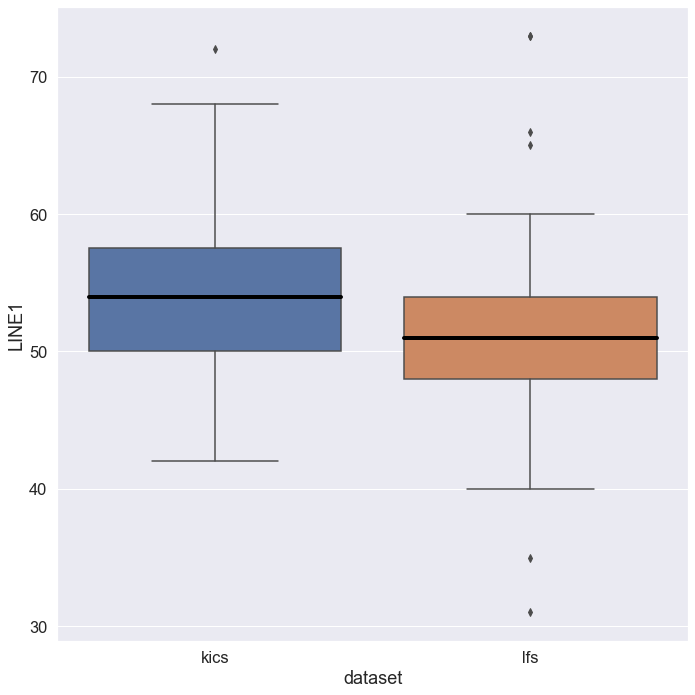

MannwhitneyuResult(statistic=3296.0, pvalue=0.0008982191122282993)


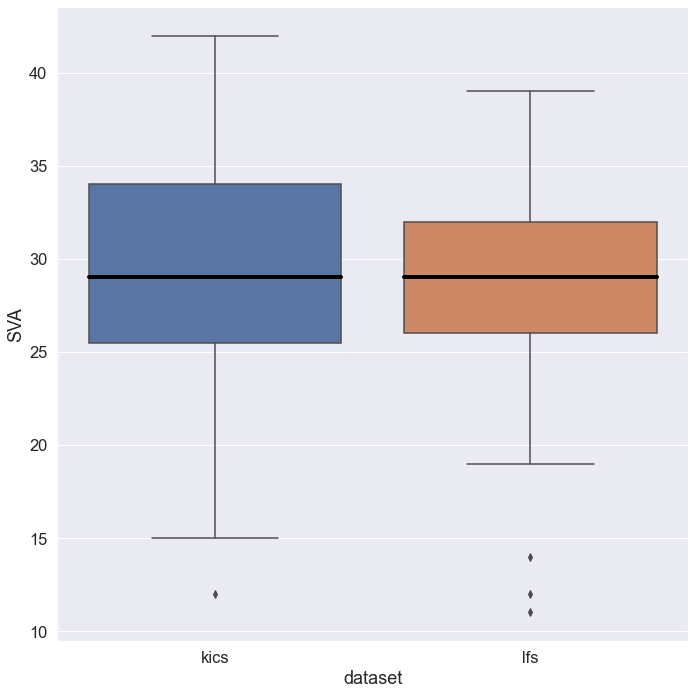

MannwhitneyuResult(statistic=2608.0, pvalue=0.6244689679773743)


In [17]:
"""
ALU, LINE1, SVA
"""

kicsALT = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID']})
lfsALT = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID']})

kicsALT = kicsALT.groupby('id')
kicsALT = kicsALT.value_counts().to_frame()
kicsALT = kicsALT.unstack(1)
kicsALT.columns = kicsALT.columns.droplevel(0)
kicsALT['dataset'] = 'kics'
print(kicsALT)

lfsALT = lfsALT.groupby('id')
lfsALT = lfsALT.value_counts().to_frame()
lfsALT = lfsALT.unstack(1)
lfsALT.columns = lfsALT.columns.droplevel(0)
lfsALT['dataset'] = 'lfs'

testing = pd.concat([kicsALT,lfsALT])
testing = testing.reset_index()
#print(testing)

#plt.rcParams["figure.figsize"] = [5, 10]

sns.boxplot(data=testing, x='dataset', y='ALU', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['ALU'].dropna(),lfsALT['ALU'].dropna()))
#list1 = df[column[0]].dropna()
#        list2 = df[column[1]].dropna()
#        print(mannwhitneyu(list1,list2))



sns.boxplot(data=testing, x='dataset', y='LINE1', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['LINE1'].dropna(),lfsALT['LINE1'].dropna()))

sns.boxplot(data=testing, x='dataset', y='SVA', medianprops={"linewidth": 4, "color": 'black'})
plt.show()

print(mannwhitneyu(kicsALT['SVA'].dropna(),lfsALT['SVA'].dropna()))

#BoxGraphMulti(testing, '', 'id', 'dataset')

Index(['ALU', 'LINE1', 'SVA'], dtype='object', name='ALT')
   chrom    normalized
0      1  2.928779e-07
1      2  3.947379e-07
2      3  3.888448e-07
3      4  3.871219e-07
4      5  3.150646e-07
..   ...           ...
19    20  2.855986e-07
20    21  2.701024e-07
21    22  1.754230e-07
22     X  7.728445e-08
23     Y  0.000000e+00

[1896 rows x 2 columns]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.731e-01 U_stat=2.626e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.566e-03 U_stat=3.258e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.154e-01 U_stat=2.733e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.001e-01 U_stat=2.888e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.403e-01 U_stat=2.720e+03
15_k

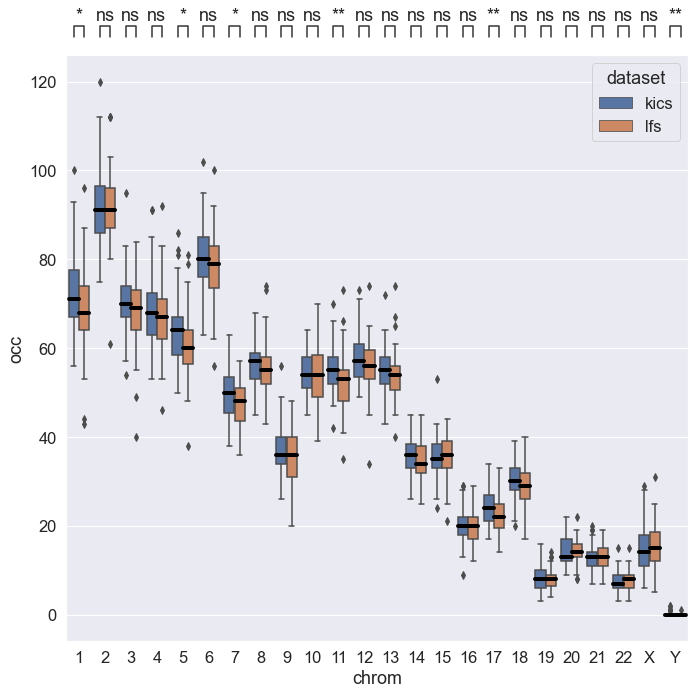

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.731e-01 U_stat=2.626e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.566e-03 U_stat=3.258e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.154e-01 U_stat=2.733e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.001e-01 U_stat=2.888e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.403e-01 U_stat=2.720e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.107e-01 U_stat=2.398e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.817e-01 U_stat=2.588e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.410e-03 U_stat=3.139e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.045e-01 U_stat=2.883e+03


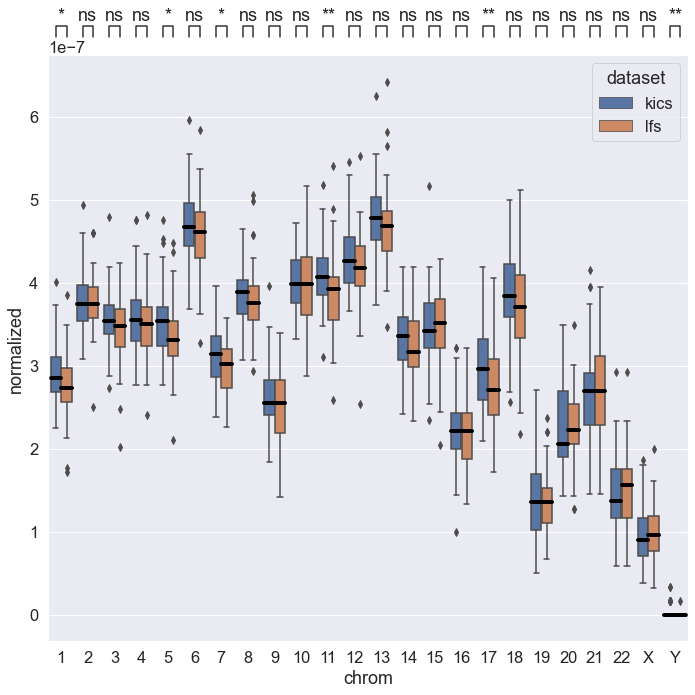

In [18]:
"""
Based on chrom
"""

kicsChromAlt = pd.DataFrame(data={'ALT':kicsTEF['ALT'], 'id':kicsTEF['Samples_ID'], 'chrom':kicsTEF['SV_chrom']})
lfsChromAlt = pd.DataFrame(data={'ALT':lfsTEF['ALT'],'id':lfsTEF['Samples_ID'], 'chrom':lfsTEF['SV_chrom']})

#print(kicsChromAlt.columns)
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['LINE1','SVA'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['LINE1','SVA'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'ALU')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'ALU')

print(normAltKdf)
# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))
    
    

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

##ALU

plt.rcParams["figure.figsize"] = [10, 10]
BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')
    

Index(['ALU', 'LINE1', 'SVA'], dtype='object', name='ALT')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.356e-01 U_stat=2.591e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.081e-01 U_stat=2.609e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.856e-01 U_stat=2.798e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.968e-01 U_stat=2.581e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.045e-01 U_stat=2.118e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.442e-01 U_stat=2.271e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.087e-01 U_stat=2.570e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=3.008e+03
18_kics vs. 18_lfs: Mann-Whitney

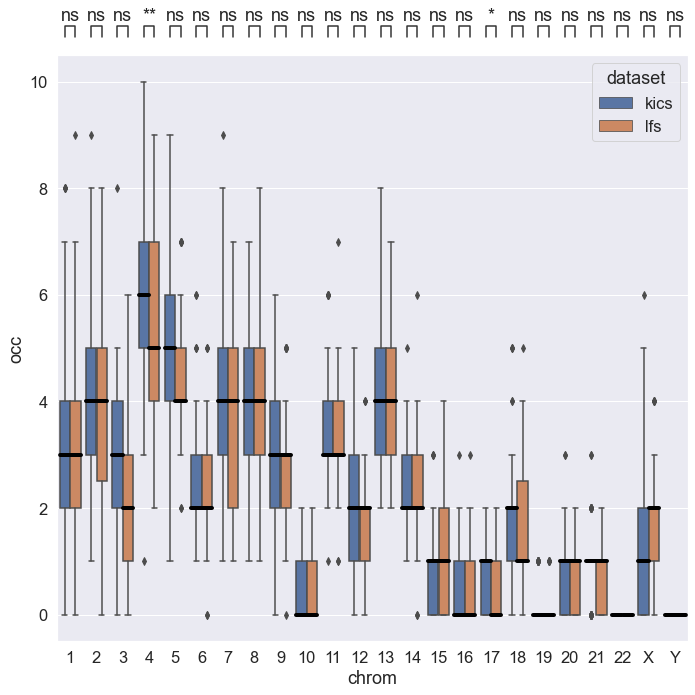

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.356e-01 U_stat=2.591e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.081e-01 U_stat=2.609e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.856e-01 U_stat=2.798e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.968e-01 U_stat=2.581e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.045e-01 U_stat=2.118e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.442e-01 U_stat=2.271e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.087e-01 U_stat=2.570e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.598e-02 U_stat=3.008e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.856e-01 U_stat=2.654e+03


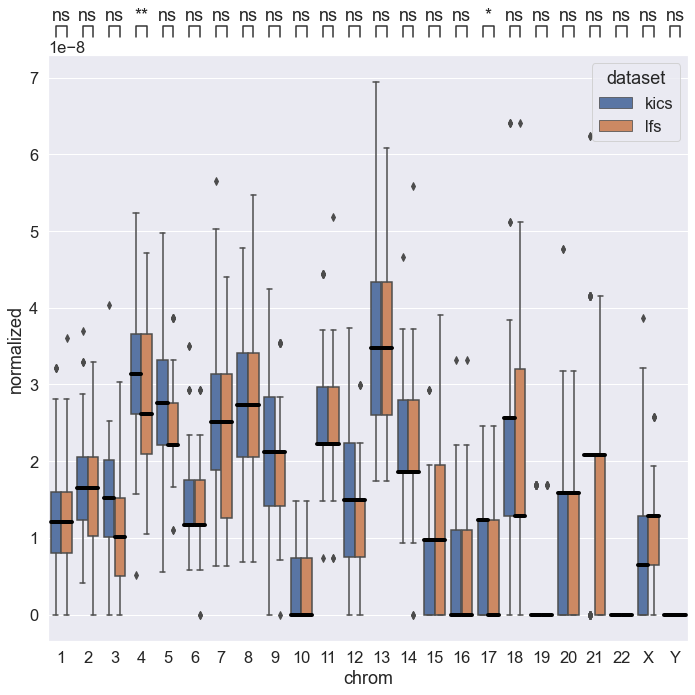

In [19]:
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['ALU','SVA'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['ALU','SVA'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'LINE1')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'LINE1')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###LINE1

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')

Index(['ALU', 'LINE1', 'SVA'], dtype='object', name='ALT')
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.216e-01 U_stat=2.672e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:9.847e-01 U_stat=2.494e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.928e-01 U_stat=2.614e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.842e-01 U_stat=2.244e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.131e-01 U_stat=2.256e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.268e-01 U_stat=2.411e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.303e-01 U_stat=2.638e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.559e-01 U_stat=2.383e+03
18_kics vs. 18_lfs: Mann-Whitney

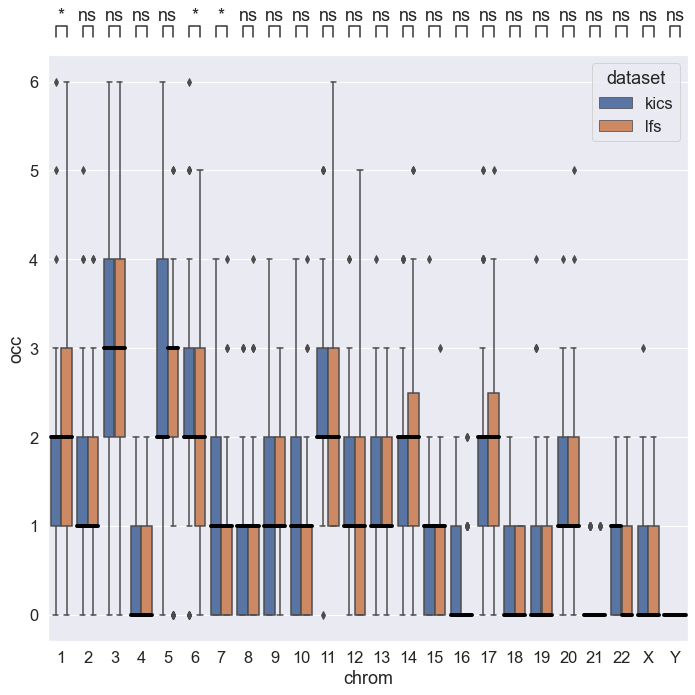

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.216e-01 U_stat=2.672e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:9.847e-01 U_stat=2.494e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.928e-01 U_stat=2.614e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.842e-01 U_stat=2.244e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.131e-01 U_stat=2.256e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.268e-01 U_stat=2.411e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.303e-01 U_stat=2.638e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.559e-01 U_stat=2.383e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.533e-01 U_stat=2.648e+03


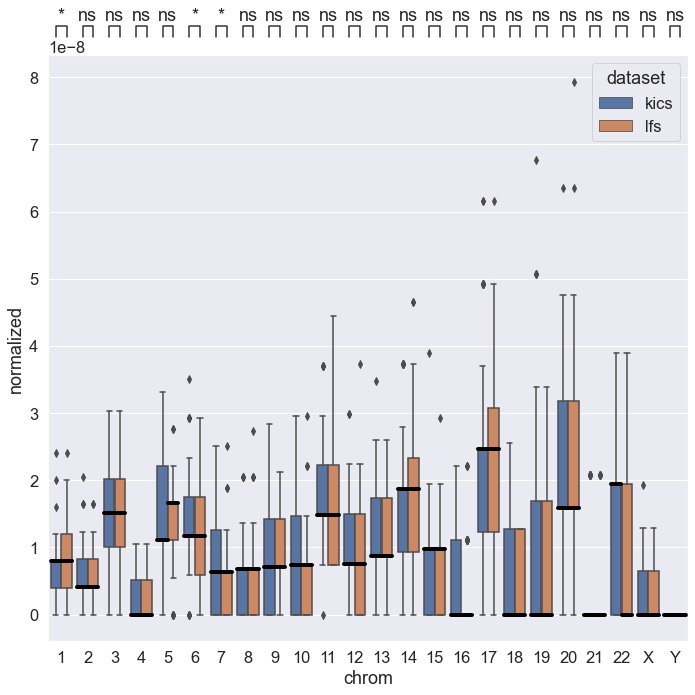

In [20]:
dog = kicsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
dog = dog.stack().unstack(1)
print(dog.columns)
dog = dog.drop(['LINE1','ALU'], axis=1)
dog = dog.stack().unstack(1)

#print(lfsChromAlt.columns)
cat = lfsChromAlt.groupby(['id','ALT','chrom']).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.drop(['LINE1','ALU'],axis=1)
cat = cat.stack().unstack(1)
#print(lfsChromAlt)

AltKdf, normAltKdf = formatDataFrame(kicsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueK, uniqueLabels, 'SVA')
AltLdf, normAltLdf = formatDataFrame(lfsChromAlt, ['id','ALT','chrom'], numBPChrom, uniqueL, uniqueLabels, 'SVA')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

AltKdf['dataset'] = 'kics'
AltLdf['dataset'] = 'lfs'
normAltKdf['dataset'] = 'kics'
normAltLdf['dataset'] = 'lfs'

AltMergedDf = pd.concat([AltKdf, AltLdf])
AltMergedDf.rename(columns = {0:'occ'}, inplace = True)
AltMergedDf.reset_index(inplace=True)
AltMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

###SVA

BoxGraphMulti(AltMergedDf, 'chrom', 'occ', 'dataset')

normAltDf = pd.concat([normAltKdf, normAltLdf])
normAltDf.reset_index(inplace=True)

BoxGraphMulti(normAltDf, 'chrom', 'normalized', 'dataset')

DGOOOOOGG
     chrom   occ dataset
0        1  80.0    kics
1       10  54.0    kics
2       11  60.0    kics
3       12  64.0    kics
4       13  60.0    kics
...    ...   ...     ...
3403     7  45.0     lfs
3404     8  60.0     lfs
3405     9  49.0     lfs
3406     X  14.0     lfs
3407     Y   0.0     lfs

[3408 rows x 3 columns]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.278e-01 U_stat=2.642e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.340e-03 U_stat=3.228e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.964e-02 U_stat=2.902e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.282e-01 U_stat=2.858e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.655e-01 U_stat=2.594e+03
15_kics vs. 15_lfs: Mann-Whit

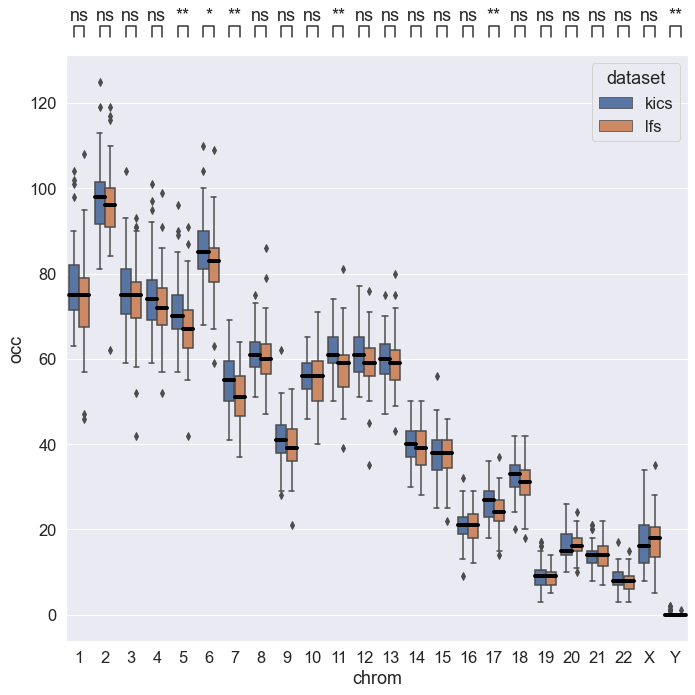

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_kics vs. 10_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.278e-01 U_stat=2.642e+03
11_kics vs. 11_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.340e-03 U_stat=3.228e+03
12_kics vs. 12_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.964e-02 U_stat=2.902e+03
13_kics vs. 13_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.282e-01 U_stat=2.858e+03
14_kics vs. 14_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.655e-01 U_stat=2.594e+03
15_kics vs. 15_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.727e-01 U_stat=2.351e+03
16_kics vs. 16_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.369e-01 U_stat=2.604e+03
17_kics vs. 17_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.659e-03 U_stat=3.176e+03
18_kics vs. 18_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.746e-02 U_stat=2.933e+03


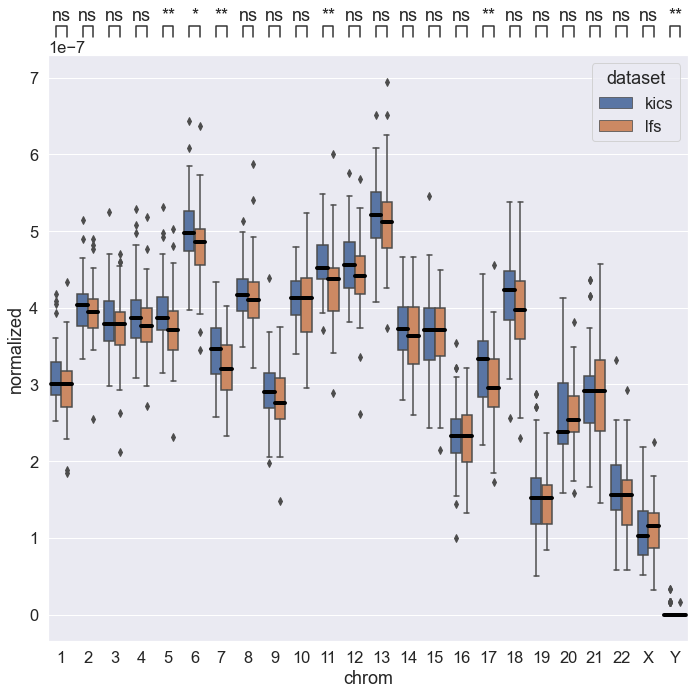

In [21]:
"""
Normalised and Regular Graph
"""

#rename things later and put into function/i but this is the statistical test T-T
dog = kicsMore.groupby(grouping).size().unstack(fill_value=0)
#print(dog)
dog = dog.stack().unstack(1)
dog = dog.stack().unstack(1)

cat = lfsMore.groupby(grouping).size().unstack(fill_value=0)
cat = cat.stack().unstack(1)
cat = cat.stack().unstack(1)




newKdf, normKdf = formatDataFrame(kicsMore, grouping, numBPChrom, uniqueK, uniqueLabels, 'INS')
newLdf, normLdf = formatDataFrame(lfsMore, grouping, numBPChrom, uniqueL, uniqueLabels, 'INS')

# for i in uniqueLabels:
#     print(i)
#     dog = normAltKdf.loc[normAltKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normAltLdf.loc[normAltLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))

#print(newKdf.index)
#print(newKdf.pivot( columns='index', values=0))

newKdf['dataset'] = 'kics'
newLdf['dataset'] = 'lfs'
normKdf['dataset'] = 'kics'
normLdf['dataset'] = 'lfs'

newMergedDf = pd.concat([newKdf, newLdf])
newMergedDf.rename(columns = {0:'occ'}, inplace = True)
newMergedDf.reset_index(inplace=True)
newMergedDf.rename(columns = {'index':'chrom'}, inplace = True)

print("DGOOOOOGG")
print(newMergedDf)

BoxGraphMulti(newMergedDf, 'chrom', 'occ', 'dataset')

normMergedDf = pd.concat([normKdf, normLdf])
normMergedDf.reset_index(inplace=True)

BoxGraphMulti(normMergedDf, 'chrom', 'normalized', 'dataset')

# Copy and Pasted from Cancer Graphs

In [161]:
"""
Outliers find go
"""
def findOutliers(df, std,yCol):
    #return a list of sample_id that are outliers
    #give me somethig that is for one box in the box plot
    q1 = df.quantile(0.25).values[0]
    q3 = df.quantile(0.75).values[0]
    
    IQR = q3-q1
    
    upperBound = (q1-std*IQR)
    lowerBound = (q3+std*IQR)
    
    outliers = df.loc[(df[yCol]< upperBound) | (df[yCol]>lowerBound)]
    print(outliers)
    return list(outliers['Samples_ID'].unique())
    
    
def outliersInDf(df, xCol,yCol, std = 1.5):
    #unique list 
    uniqueList = list(df[xCol].unique())
    #get all types of boxes the stuff on the x axis categories
    for i in uniqueList:
        tempdf = df[df[xCol]==i]
        list_ids = findOutliers(tempdf,std,yCol)
        print("the outliers for "+i+" are:")
        print(list_ids)
        print()

In [132]:
""" 
Replacement for box graph multi
"""
plt.rcParams["figure.figsize"] = [20, 15]

def BoxGraphMultii(df: pd.DataFrame, xCol, yCol, compCol, orderList):    
    
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'}, showfliers=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
    
    lfs = df[df[compCol]=='lfs']
    kics = df[df[compCol]=='kics']
    
    print('LFS')
    outliersInDf(lfs, xCol,yCol)
    print('KICS')
    outliersInDf(kics, xCol,yCol)
    
    excludeList = list(set(lfs[xCol]).symmetric_difference(set(kics[xCol])))

    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        if i not in excludeList:
            p1 = (i, 'kics')
            p2 = (i, 'lfs')
            p = (p1,p2)
            listPairing.append(p)
            
    if xCol == 'age6':
        p1 = ('>=6','kics')
        p2 = ('<6','kics')
        p = (p1,p2)
        listPairing.append(p)
        p1 = ('>=6','lfs')
        p2 = ('<6','lfs')
        p = (p1,p2)
        listPairing.append(p)
        p1 = ('>=6','lfs')
        p2 = ('Unaffected','lfs')
        p = (p1,p2)
        listPairing.append(p)
        p1 = ('Unaffected','lfs')
        p2 = ('<6','lfs')
        p = (p1,p2)
        listPairing.append(p)
        
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney', 
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()

In [133]:
# # the outlier
# print(bigKdf[bigKdf['Samples_ID']=='284386'])

# #remove from bigKdf
# bigKdf = bigKdf[bigKdf['Samples_ID']!='284386']

11
['SVA' 'LINE1' 'ALU']
  Samples_ID age6  freq
6     284386  >=6  4516
LFS
    Samples_ID age6  freq dataset
43        5567  >=6  1142     lfs
50  SJACT007_G  >=6   862     lfs
51  SJACT008_G  >=6   846     lfs
the outliers for >=6 are:
['5567', 'SJACT007_G', 'SJACT008_G']

    Samples_ID age6  freq dataset
6         2262   <6  1325     lfs
18        3356   <6  1347     lfs
19        3365   <6  1284     lfs
49  SJACT005_G   <6   718     lfs
the outliers for <6 are:
['2262', '3356', '3365', 'SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   Samples_ID age6  freq dataset
2      273308   <6  1948    kics
3      273309   <6  2164    kics
7      285045   <6  2142    kics
36     308436   <6  2262    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6  3192    kics
6      284386  >=6  4516    kics
8      286909  >=6  2184    kics
20     297377

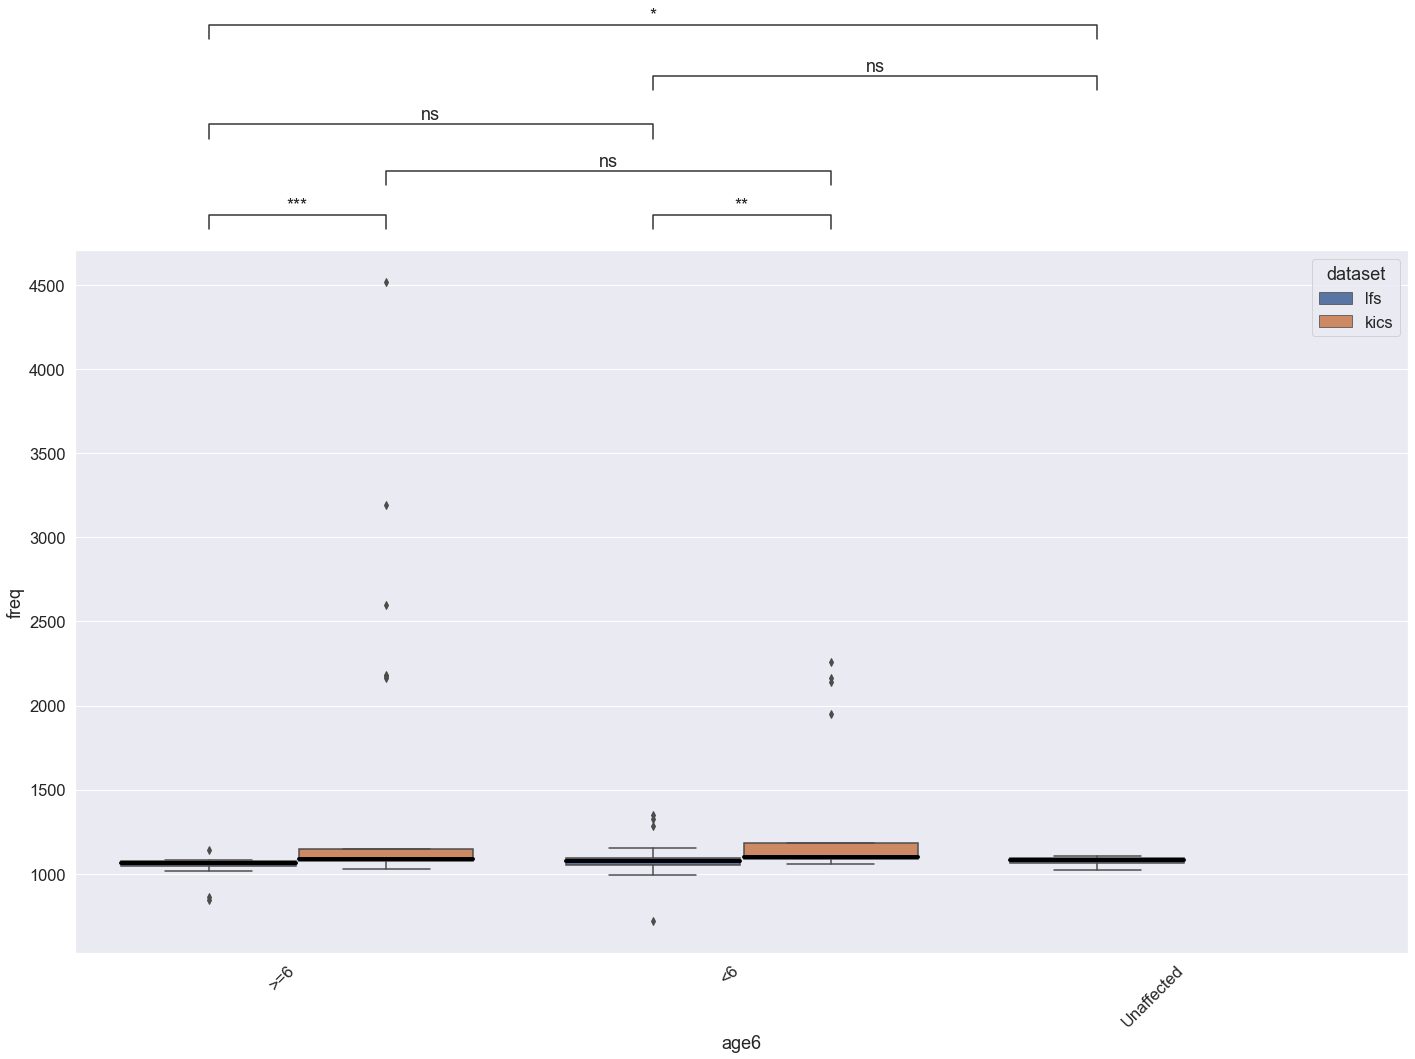

In [134]:
"""
Age of onset
"""
lfsCancer = bigLdf[bigLdf['tissue_type']!='Unaffected'].drop(['sample', 'tissue_type',
                                                             'cancer_diagnosis','SV_type'],axis=1)
lfsUnaffected = bigLdf[bigLdf['tissue_type']=='Unaffected'].drop(['sample', 'tissue_type',
                                                            'cancer_diagnosis','SV_type'],axis=1)

print(lfsUnaffected['Samples_ID'].nunique())

kicsCancer = bigKdf.drop(['abbv_id', 'SV_type', 'sample', 'tumour_class',
                          'tissue_type','cancer_diagnosis'],axis=1)

def ageOfOnsetKics(row):
    if row['ageofonset']<2190:
        return '<6'
    if row['ageofonset']>=2190:
        return '>=6'
    
def ageOfOnsetLfs(row):
    if row['ageofonset']<72:
        return '<6'
    if row['ageofonset']>=72:
        return '>=6'

def cleaning(df):
    df = df.drop(['ALT','ageofonset'],axis=1)
    df = df.groupby(['Samples_ID']).value_counts()
    df = df.to_frame().reset_index()
    df.rename(columns = {0: 'freq'},inplace = True)
    return df

def mergeDFs(lfs1, lfs2, kics1):
    lfs1 = cleaning(lfs1)
    lfs2 = cleaning(lfs2)
    kics1 = cleaning(kics1)
    print(kics1.loc[kics1['freq']>4000])
    lfsMerged = pd.concat([lfs1,lfs2])
    lfsMerged['dataset'] = 'lfs'
    kics1['dataset'] = 'kics'
    mergedDf = pd.concat([lfsMerged, kics1])
    
    BoxGraphMultii(mergedDf, 'age6', 'freq', 'dataset', ['<6','>=6','Unaffected'])


kicsCancer['ageofonset']=kicsCancer['ageofonset'].astype('float')

lfsCancer['age6'] = lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1)
kicsCancer['age6'] = kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1)
lfsUnaffected['age6'] = 'Unaffected'

LCAlu = lfsCancer.loc[lfsCancer['ALT'] == 'ALU']
LUAlu = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'ALU']
KCAlu = kicsCancer.loc[kicsCancer['ALT'] == 'ALU']

print(lfsCancer['ALT'].unique())

LCLine1 = lfsCancer.loc[lfsCancer['ALT'] == 'LINE1']
LULine1 = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'LINE1']
KCLine1 = kicsCancer.loc[kicsCancer['ALT'] == 'LINE1']

LCSva = lfsCancer.loc[lfsCancer['ALT'] == 'SVA']
LUSva = lfsUnaffected.loc[lfsUnaffected['ALT'] == 'SVA']
KCSva = kicsCancer.loc[kicsCancer['ALT'] == 'SVA']

mergeDFs(lfsCancer,lfsUnaffected, kicsCancer)

  Samples_ID age6  freq
6     284386  >=6  4184
LFS
    Samples_ID age6  freq dataset
43        5567  >=6  1065     lfs
50  SJACT007_G  >=6   808     lfs
51  SJACT008_G  >=6   797     lfs
the outliers for >=6 are:
['5567', 'SJACT007_G', 'SJACT008_G']

    Samples_ID age6  freq dataset
6         2262   <6  1229     lfs
18        3356   <6  1237     lfs
19        3365   <6  1172     lfs
49  SJACT005_G   <6   676     lfs
the outliers for <6 are:
['2262', '3356', '3365', 'SJACT005_G']

   Samples_ID        age6  freq dataset
4        2465  Unaffected  1027     lfs
8        3334  Unaffected   945     lfs
10       3806  Unaffected   950     lfs
the outliers for Unaffected are:
['2465', '3334', '3806']

KICS
   Samples_ID age6  freq dataset
2      273308   <6  1780    kics
3      273309   <6  1970    kics
7      285045   <6  1972    kics
36     308436   <6  2062    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6  2961

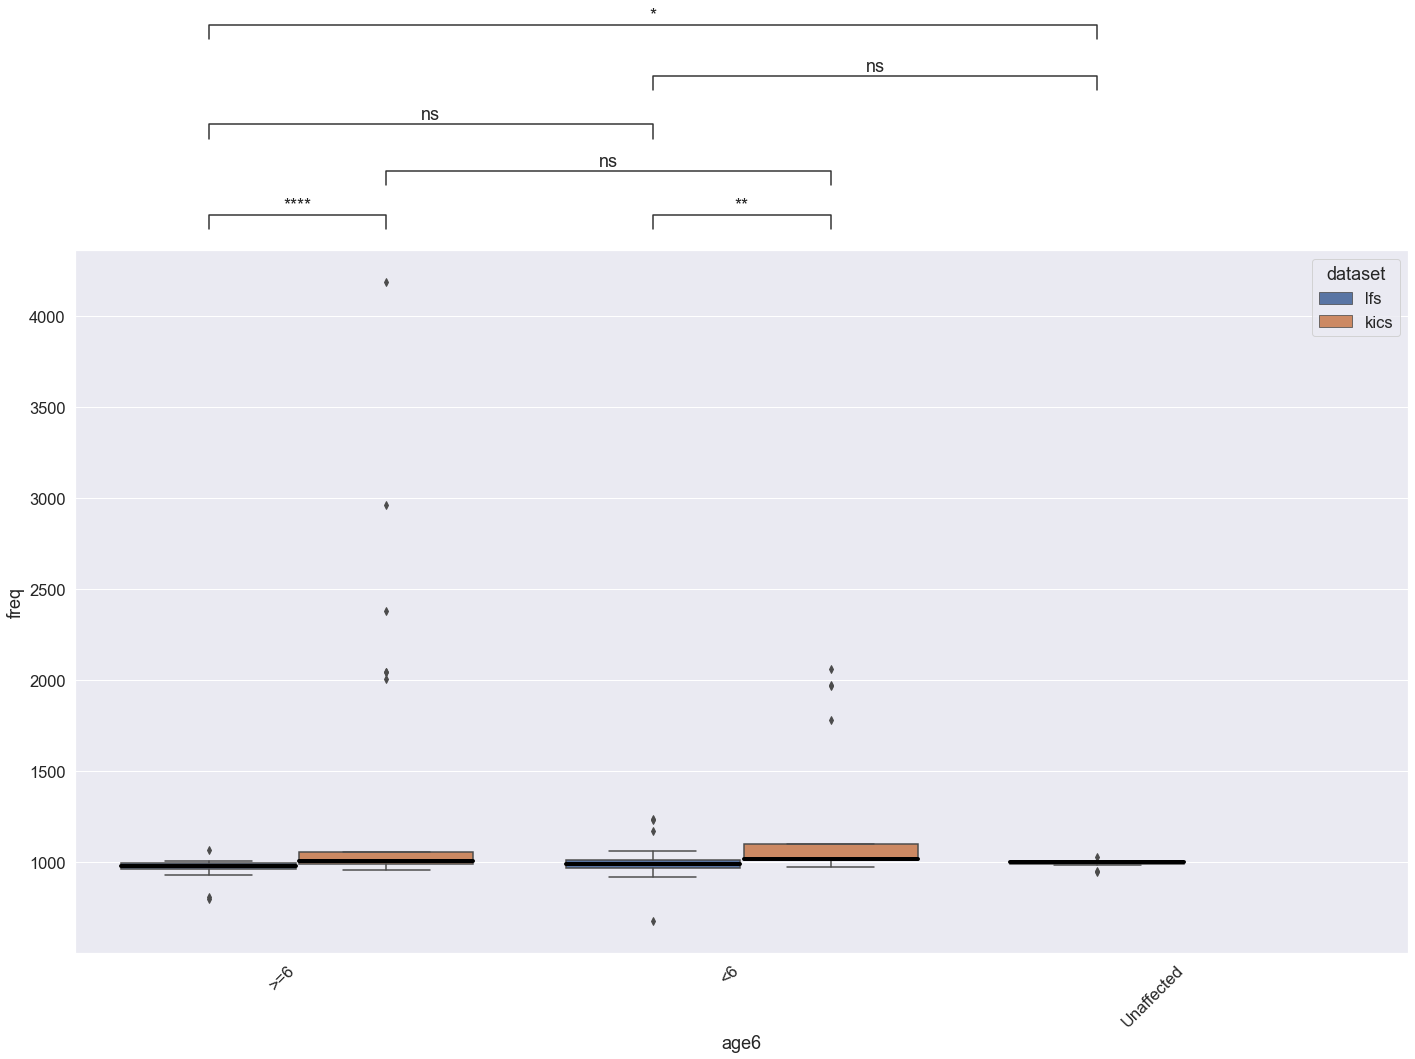

In [135]:
mergeDFs(LCAlu, LUAlu, KCAlu)

Empty DataFrame
Columns: [Samples_ID, age6, freq]
Index: []
LFS
Empty DataFrame
Columns: [Samples_ID, age6, freq, dataset]
Index: []
the outliers for >=6 are:
[]

    Samples_ID age6  freq dataset
6         2262   <6    66     lfs
18        3356   <6    73     lfs
19        3365   <6    73     lfs
49  SJACT005_G   <6    31     lfs
the outliers for <6 are:
['2262', '3356', '3365', 'SJACT005_G']

  Samples_ID        age6  freq dataset
7       3273  Unaffected    40     lfs
the outliers for Unaffected are:
['3273']

KICS
   Samples_ID age6  freq dataset
2      273308   <6   108    kics
3      273309   <6   124    kics
7      285045   <6   112    kics
36     308436   <6   126    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6   150    kics
6      284386  >=6   212    kics
8      286909  >=6   104    kics
20     297377  >=6    96    kics
28     300683  >=6   132    kics
34     305082  >=6    94    kics
the outliers 

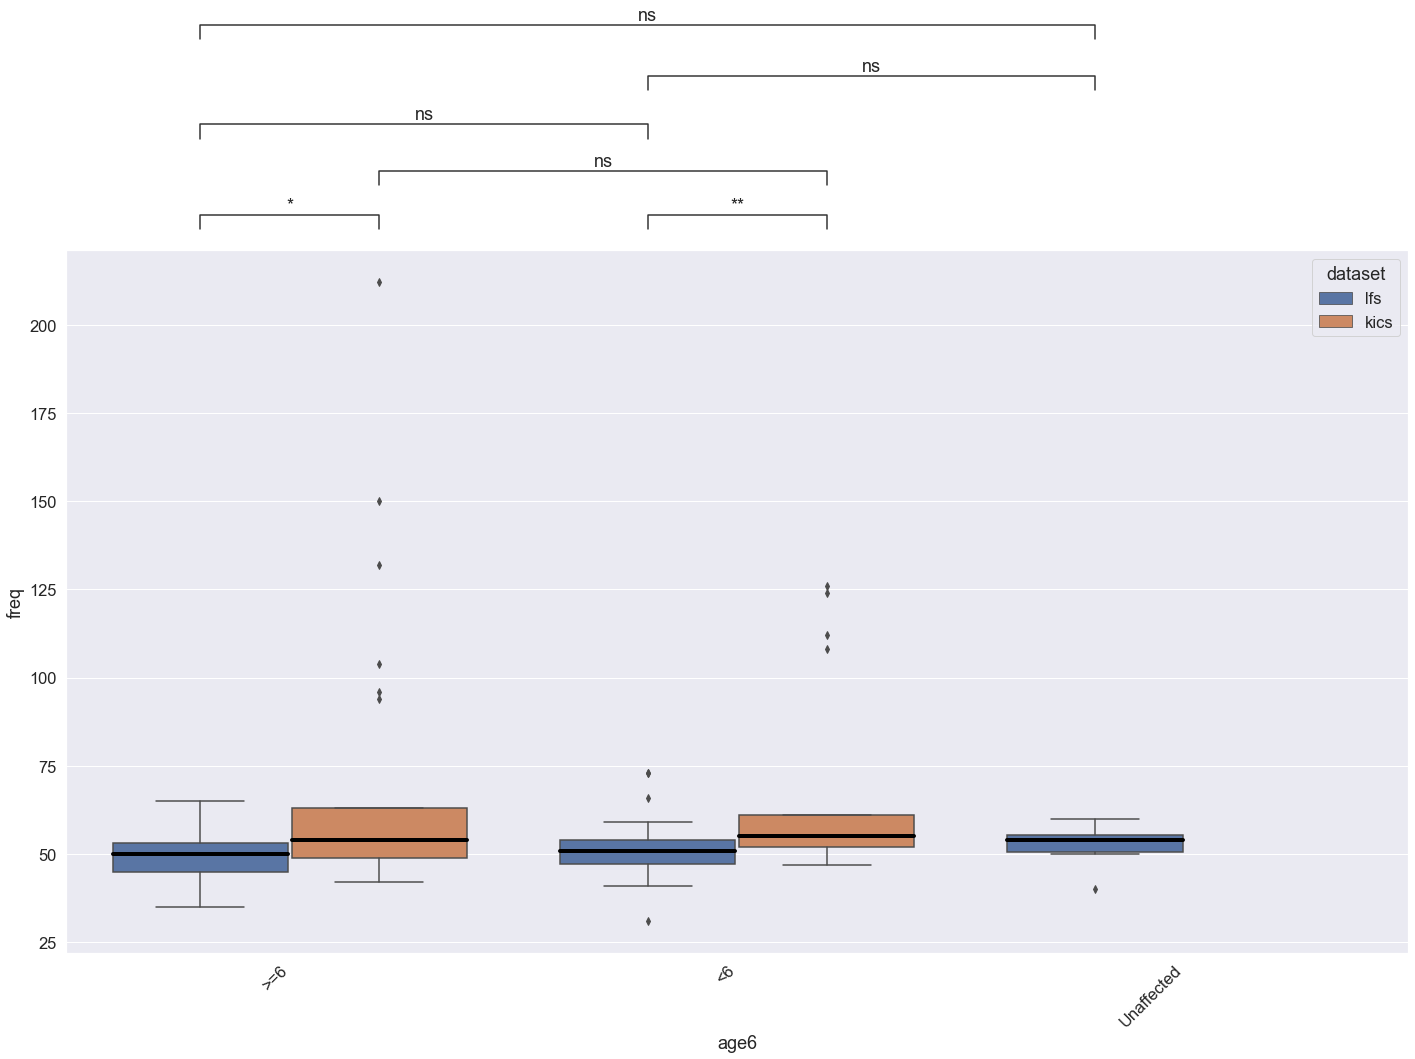

In [136]:
mergeDFs(LCLine1, LULine1, KCLine1)

Empty DataFrame
Columns: [Samples_ID, age6, freq]
Index: []
LFS
    Samples_ID age6  freq dataset
50  SJACT007_G  >=6    12     lfs
51  SJACT008_G  >=6    14     lfs
the outliers for >=6 are:
['SJACT007_G', 'SJACT008_G']

    Samples_ID age6  freq dataset
49  SJACT005_G   <6    11     lfs
the outliers for <6 are:
['SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   Samples_ID age6  freq dataset
2      273308   <6    60    kics
3      273309   <6    70    kics
7      285045   <6    58    kics
36     308436   <6    74    kics
the outliers for <6 are:
['273308', '273309', '285045', '308436']

   Samples_ID age6  freq dataset
1      271116  >=6    81    kics
6      284386  >=6   120    kics
20     297377  >=6    66    kics
28     300683  >=6    84    kics
the outliers for >=6 are:
['271116', '284386', '297377', '300683']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      *

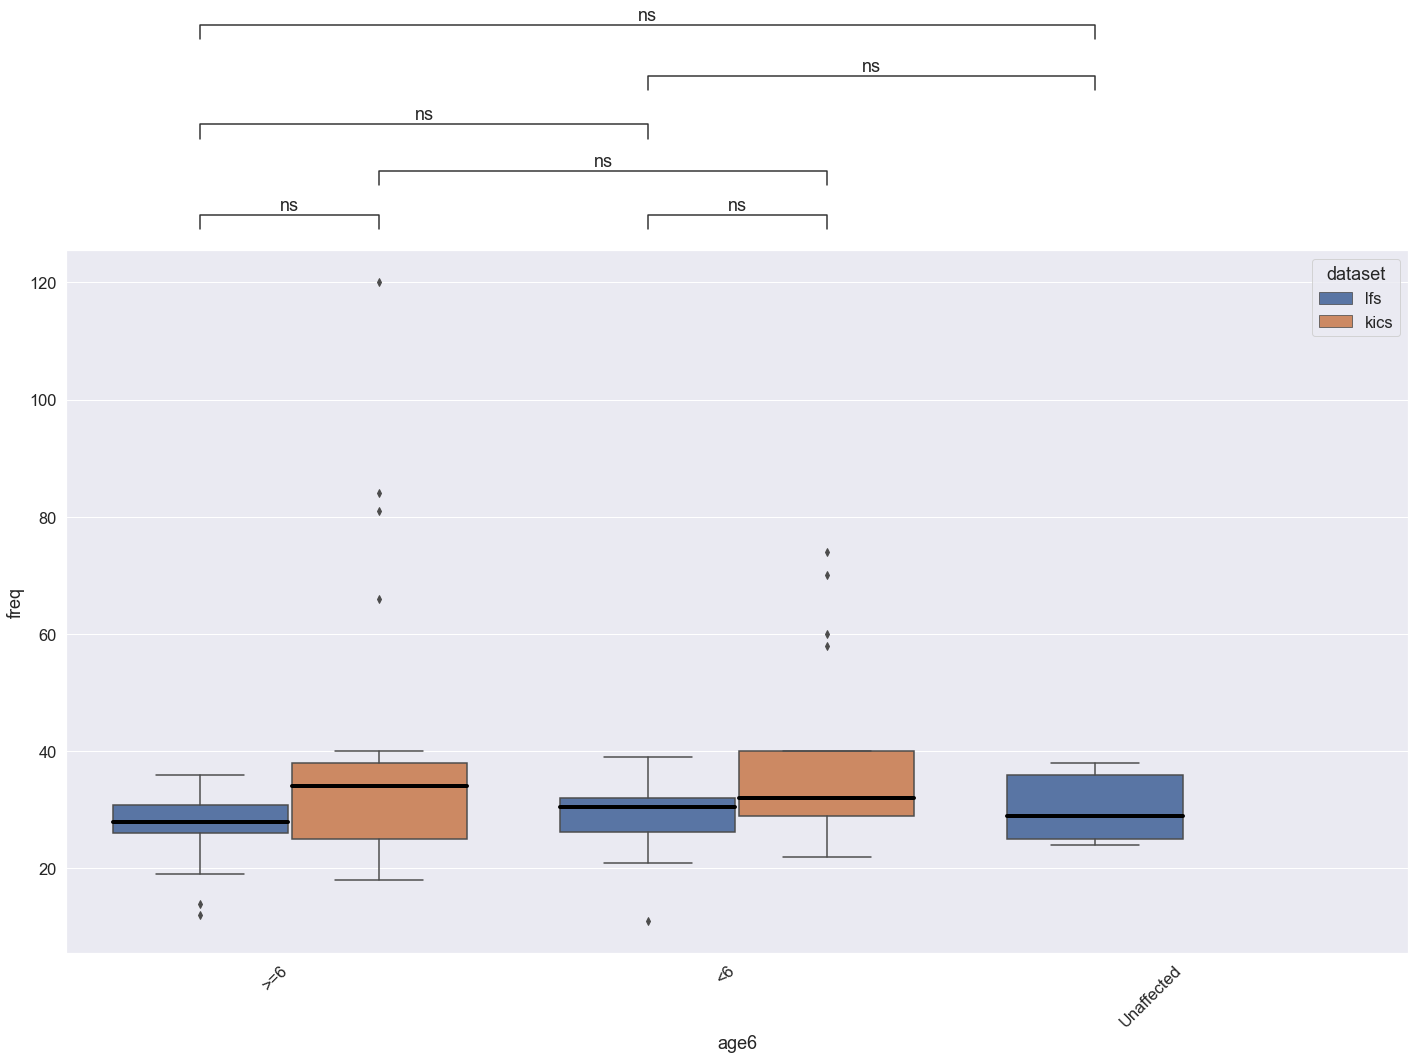

In [137]:
mergeDFs(LCSva, LUSva, KCSva)

In [138]:
def filterBig(df, xcol):
    uniquelist = list(df[xcol].unique())
    n=5
    sampleIdCol = df.columns
    sampleIdCol = sampleIdCol[0]
    
    #if there is less than 5 (<5) unique ids then add to remove list
    removelist = []
    for i in uniquelist:
        dog = df.loc[df[xcol]==i]
        num = dog[sampleIdCol].nunique()        
        if num < n:
            removelist.append(i)
                
    df = df[~df[xcol].isin(removelist)]
        
    return df
    

In [139]:
def graphBoxGen(xColumnName, df, ycol = 0):
    
    df = filterBig(df, xColumnName)
    outliersInDf(df,xColumnName,ycol)

    
    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xColumnName, y=ycol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    #add statistical test here

    # initializing list 
    uniqueTissue = list(df[xColumnName].unique()) 

    #does all possible pairings given a list
    listPairing = [(a,b) for x, a in enumerate(uniqueTissue) for b in uniqueTissue[x+1:]]
    #print(listPairing)

    annot = Annotator(ax, listPairing, data=df, x=xColumnName, y=ycol)
    annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

  Samples_ID tissue_type     0
0       3356         CNS  1347
the outliers for CNS are:
['3356']

  Samples_ID  tissue_type     0
1       2262  Soft Tissue  1325
the outliers for Soft Tissue are:
['2262']

    Samples_ID tissue_type     0
2         3365     Adrenal  1284
60  SJACT007_G     Adrenal   862
61  SJACT008_G     Adrenal   846
62  SJACT005_G     Adrenal   718
the outliers for Adrenal are:
['3365', 'SJACT007_G', 'SJACT008_G', 'SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, tissue_type, 0]
Index: []
the outliers for Unaffected are:
[]

Empty DataFrame
Columns: [Samples_ID, tissue_type, 0]
Index: []
the outliers for Bone are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:2.366e-01 U_stat=4.500e+01
Soft Tissue vs. Adrenal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.695e-01

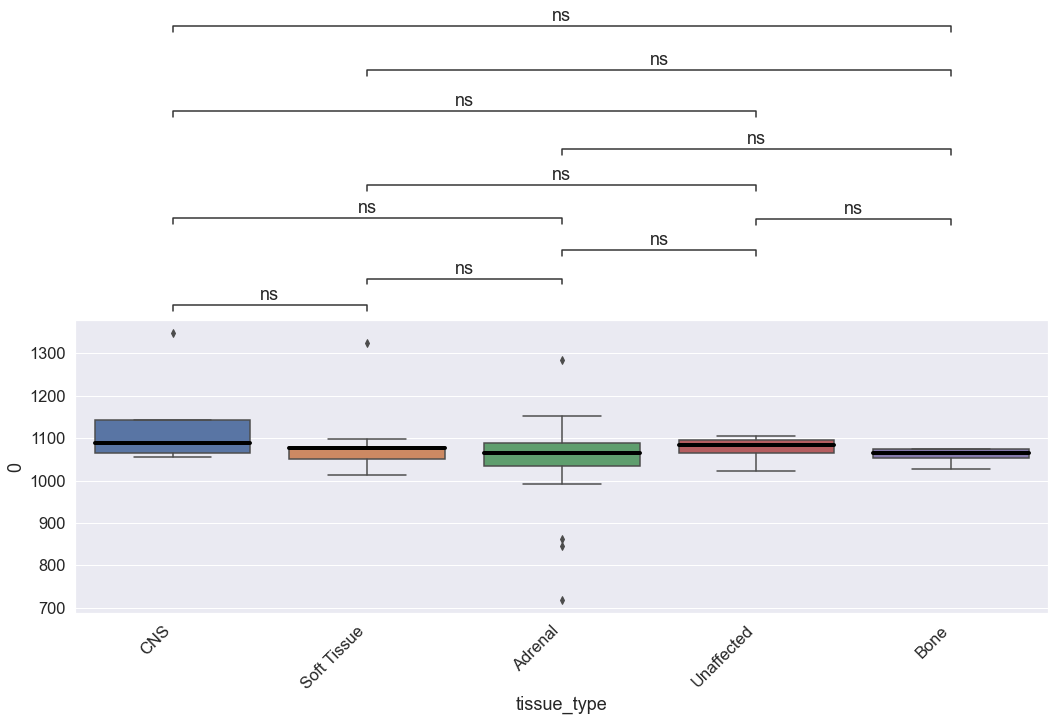

In [140]:
"""
Diagnosis and Tissue_Type inside each cohort
"""
#Overall
ldf = bigLdf.drop(['sample','SV_type', 'ageofonset'], axis=1)
kdf = bigKdf.drop(['sample','SV_type','abbv_id','ageofonset'],axis=1)

ldfGenTissue = ldf.drop(['ALT','cancer_diagnosis'],axis=1)
ldfGenTissue = ldfGenTissue.value_counts().to_frame().reset_index()

graphBoxGen('tissue_type', ldfGenTissue)

  Samples_ID cancer_diagnosis     0
1       2262              RMS  1325
the outliers for RMS are:
['2262']

    Samples_ID cancer_diagnosis     0
2         3365              ACC  1284
60  SJACT007_G              ACC   862
61  SJACT008_G              ACC   846
62  SJACT005_G              ACC   718
the outliers for ACC are:
['3365', 'SJACT007_G', 'SJACT008_G', 'SJACT005_G']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, 0]
Index: []
the outliers for Unaffected are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.263e-01 U_stat=1.090e+02
ACC vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:1.709e-01 U_stat=8.050e+01
RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:4.249e-01 U_stat=3.850e+01


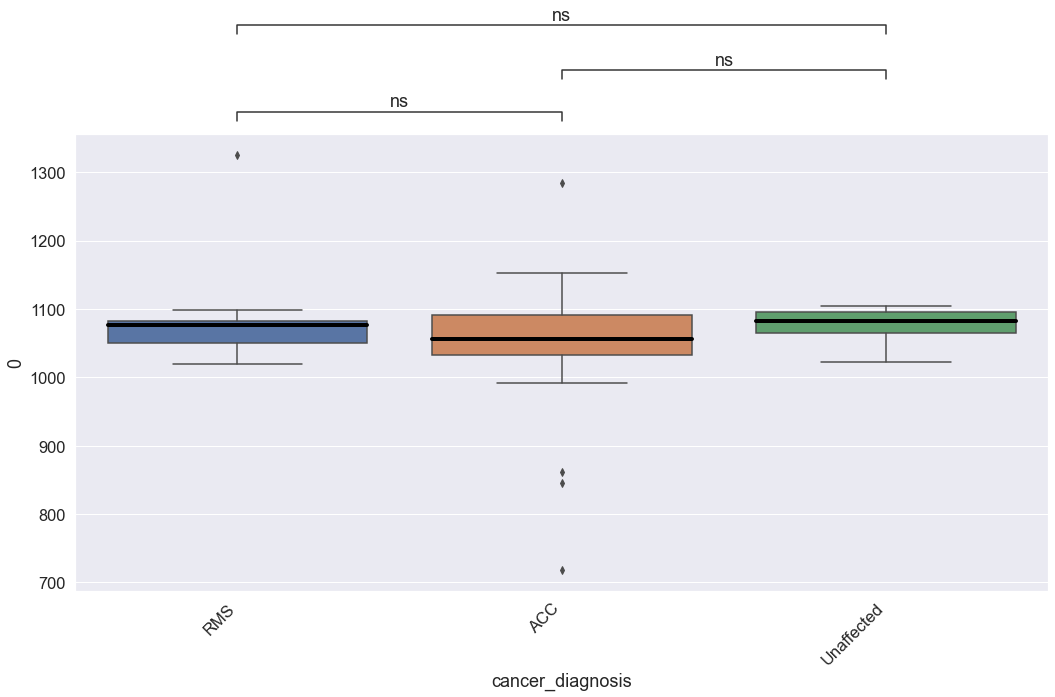

In [141]:
ldfGenDiag = ldf.drop(['ALT','tissue_type'],axis=1)
ldfGenDiag = ldfGenDiag.value_counts().to_frame().reset_index()

graphBoxGen('cancer_diagnosis', ldfGenDiag)

  Samples_ID  tumour_class  tissue_type     0
0     284386  SOLID TUMORS  Soft Tissue  4516
the outliers for Soft Tissue are:
['284386']

  Samples_ID  tumour_class tissue_type     0
1     271116    CNS TUMORS         CNS  3192
2     300683  SOLID TUMORS         CNS  2596
4     286909    CNS TUMORS         CNS  2184
the outliers for CNS are:
['271116', '300683', '286909']

  Samples_ID       tumour_class tissue_type     0
3     308436  LEUKEMIA/LYMPHOMA       Blood  2262
8     285045  LEUKEMIA/LYMPHOMA       Blood  2142
the outliers for Blood are:
['308436', '285045']

Empty DataFrame
Columns: [Samples_ID, tumour_class, tissue_type, 0]
Index: []
the outliers for US are:
[]

   Samples_ID  tumour_class tissue_type     0
10     299337  SOLID TUMORS       Other  1183
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Soft

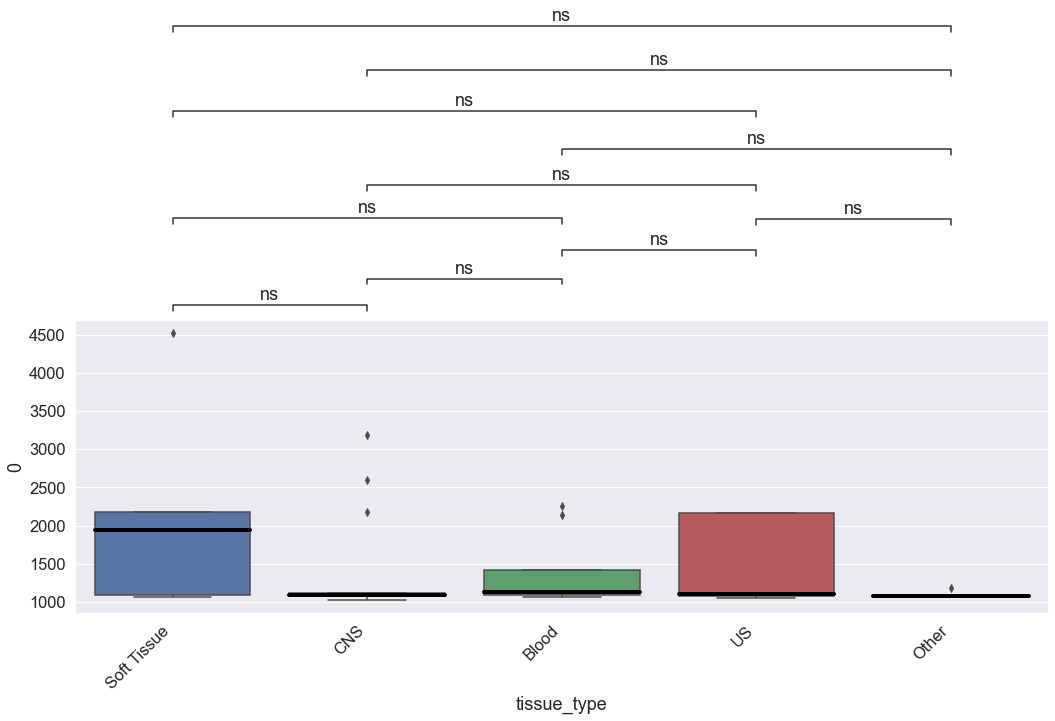

In [142]:
kdfGenTissue = kdf.drop(['ALT', 'cancer_diagnosis'], axis=1)
kdfGenTissue = kdfGenTissue.value_counts().to_frame().reset_index()
graphBoxGen('tissue_type', kdfGenTissue)

  Samples_ID  tumour_class cancer_diagnosis     0
0     284386  SOLID TUMORS              RMS  4516
the outliers for RMS are:
['284386']

  Samples_ID  tumour_class cancer_diagnosis     0
2     300683  SOLID TUMORS           Glioma  2596
4     286909    CNS TUMORS           Glioma  2184
the outliers for Glioma are:
['300683', '286909']

Empty DataFrame
Columns: [Samples_ID, tumour_class, cancer_diagnosis, 0]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

   Samples_ID  tumour_class cancer_diagnosis     0
10     299337  SOLID TUMORS            Other  1183
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Glioma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.996e-01 U_stat=4.600e+01
Glioma vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:7.672e-01 U_stat=2.900e+01
Undiffere

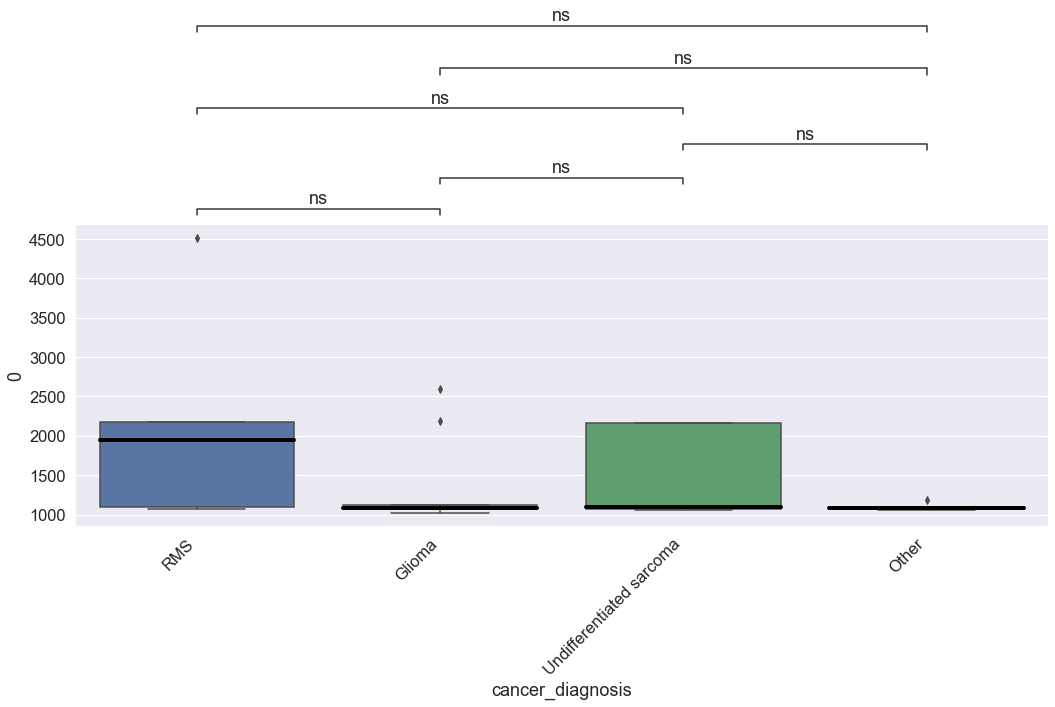

In [143]:
kdfGenDiag = kdf.drop(['ALT', 'tissue_type'], axis=1)
kdfGenDiag = kdfGenDiag.value_counts().to_frame().reset_index()
graphBoxGen('cancer_diagnosis', kdfGenDiag)

ALT Samples_ID tissue_type   ALU
1       271116         CNS  2961
8       286909         CNS  2044
28      300683         CNS  2380
the outliers for CNS are:
['271116', '286909', '300683']

ALT Samples_ID  tissue_type   ALU
6       284386  Soft Tissue  4184
the outliers for Soft Tissue are:
['284386']

Empty DataFrame
Columns: [Samples_ID, tissue_type, ALU]
Index: []
the outliers for US are:
[]

ALT Samples_ID tissue_type   ALU
7       285045       Blood  1972
36      308436       Blood  2062
the outliers for Blood are:
['285045', '308436']

ALT Samples_ID tissue_type   ALU
24      299337       Other  1099
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:3.153e-01 U_stat=2.550e+01
Soft Tissue vs. US: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01

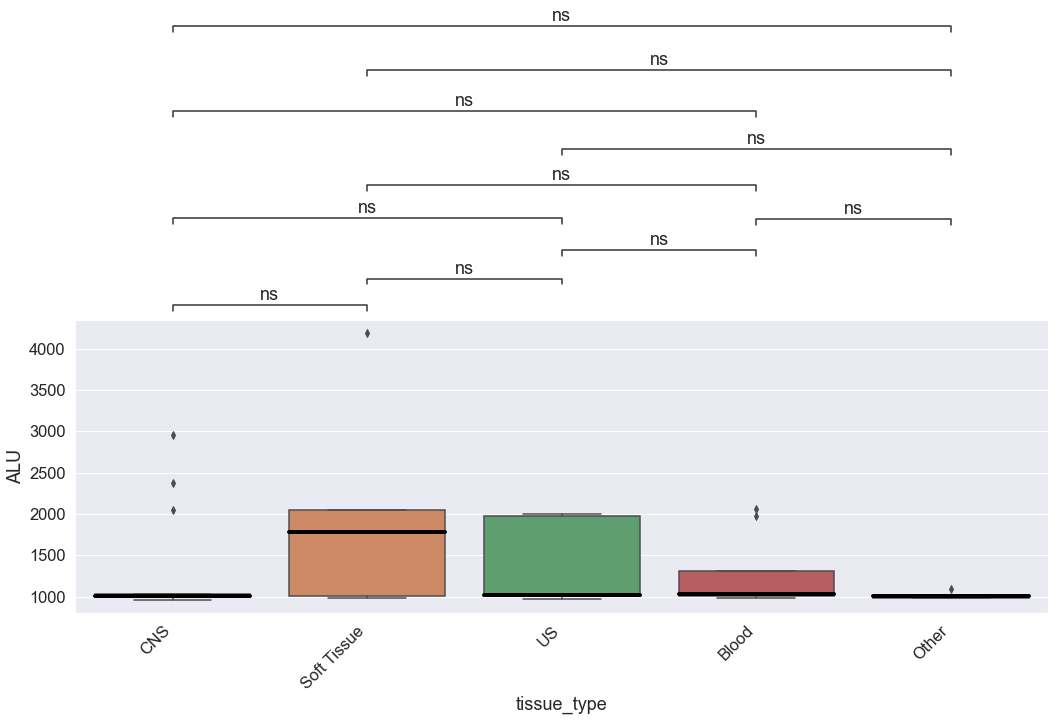

In [144]:
"""
ALT Specific (ALU LINE1 SVA) Kics then Lfs. Tissue then Diag
"""
kT = kdf.drop(['cancer_diagnosis'], axis=1).groupby(['Samples_ID', 'ALT','tissue_type']).size()
kT = kT.unstack(1)
lT = ldf.drop(['cancer_diagnosis'], axis=1).groupby(['Samples_ID', 'ALT', 'tissue_type']).size()
lT = lT.unstack(1)

kD = kdf.drop(['tissue_type'], axis=1).groupby(['Samples_ID', 'ALT','cancer_diagnosis']).size()
kD = kD.unstack(1)
lD = ldf.drop(['tissue_type'], axis=1).groupby(['Samples_ID', 'ALT','cancer_diagnosis']).size()
lD = lD.unstack(1)

graphBoxGen('tissue_type', kT.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT Samples_ID tissue_type  LINE1
1       271116         CNS    150
8       286909         CNS    104
28      300683         CNS    132
the outliers for CNS are:
['271116', '286909', '300683']

ALT Samples_ID  tissue_type  LINE1
6       284386  Soft Tissue    212
the outliers for Soft Tissue are:
['284386']

Empty DataFrame
Columns: [Samples_ID, tissue_type, LINE1]
Index: []
the outliers for US are:
[]

ALT Samples_ID tissue_type  LINE1
36      308436       Blood    126
the outliers for Blood are:
['308436']

Empty DataFrame
Columns: [Samples_ID, tissue_type, LINE1]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:4.885e-02 U_stat=1.450e+01
Soft Tissue vs. US: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
US vs. Blood: Mann-Wh

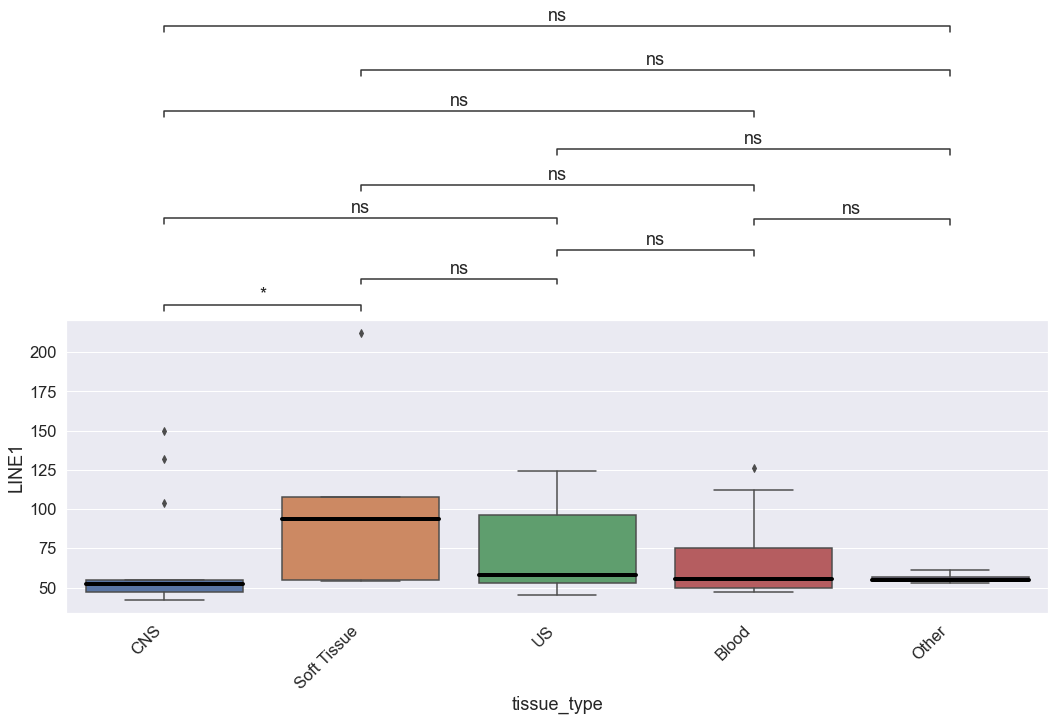

In [145]:
graphBoxGen('tissue_type', kT.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

ALT Samples_ID tissue_type  SVA
1       271116         CNS   81
28      300683         CNS   84
the outliers for CNS are:
['271116', '300683']

ALT Samples_ID  tissue_type  SVA
6       284386  Soft Tissue  120
the outliers for Soft Tissue are:
['284386']

Empty DataFrame
Columns: [Samples_ID, tissue_type, SVA]
Index: []
the outliers for US are:
[]

ALT Samples_ID tissue_type  SVA
7       285045       Blood   58
36      308436       Blood   74
the outliers for Blood are:
['285045', '308436']

Empty DataFrame
Columns: [Samples_ID, tissue_type, SVA]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:2.554e-01 U_stat=2.400e+01
Soft Tissue vs. US: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
US vs. Blood: Mann-Whitney-Wilcoxon test 

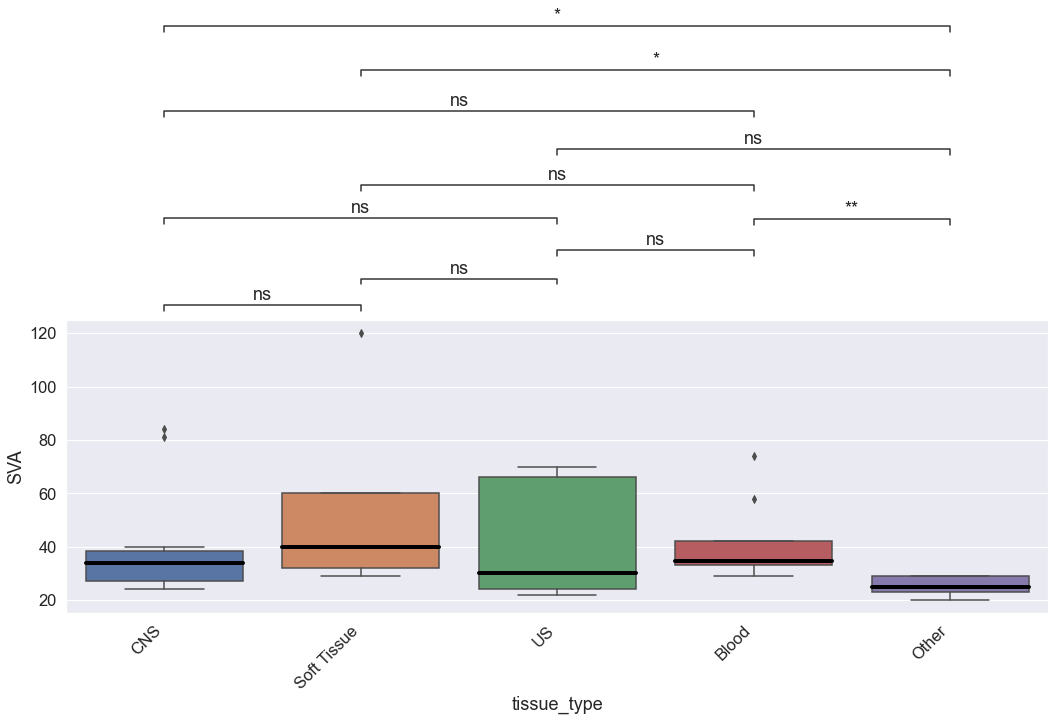

In [146]:
graphBoxGen('tissue_type', kT.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALT  Samples_ID tissue_type   ALU
29         3365     Adrenal  1172
60   SJACT005_G     Adrenal   676
61   SJACT007_G     Adrenal   808
62   SJACT008_G     Adrenal   797
the outliers for Adrenal are:
['3365', 'SJACT005_G', 'SJACT007_G', 'SJACT008_G']

ALT Samples_ID  tissue_type   ALU
8         2262  Soft Tissue  1229
the outliers for Soft Tissue are:
['2262']

ALT Samples_ID tissue_type   ALU
14        2465  Unaffected  1027
26        3334  Unaffected   945
43        3806  Unaffected   950
the outliers for Unaffected are:
['2465', '3334', '3806']

ALT Samples_ID tissue_type   ALU
27        3356         CNS  1237
the outliers for CNS are:
['3356']

Empty DataFrame
Columns: [Samples_ID, tissue_type, ALU]
Index: []
the outliers for Bone are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_

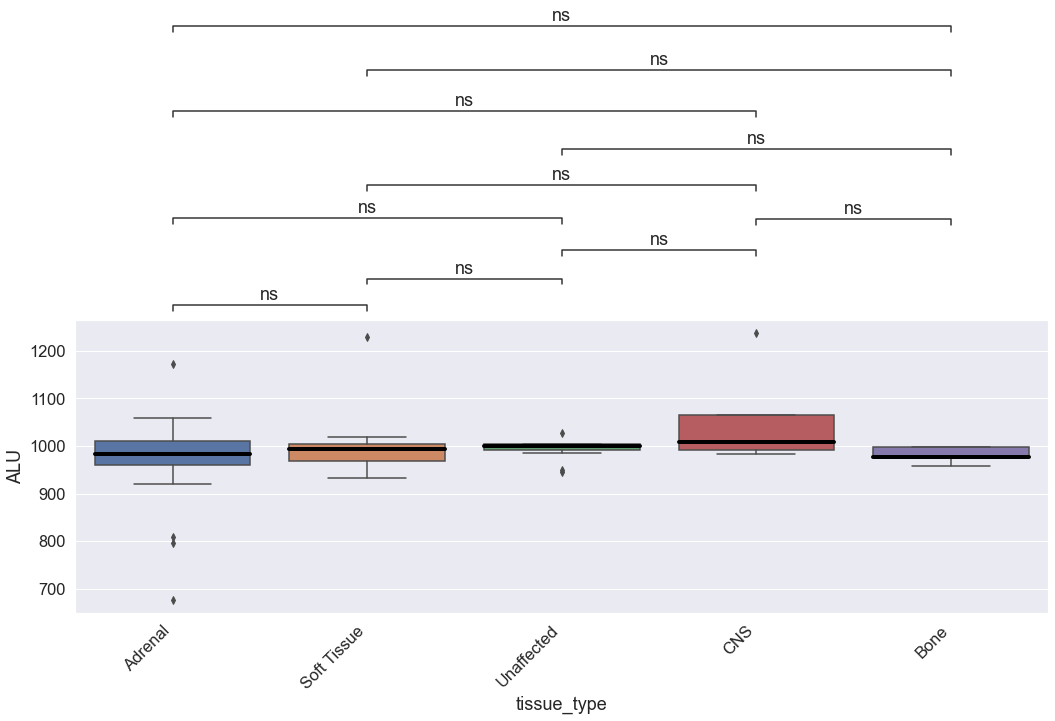

In [147]:
#lfs tissue
graphBoxGen('tissue_type', lT.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT  Samples_ID tissue_type  LINE1
29         3365     Adrenal     73
60   SJACT005_G     Adrenal     31
the outliers for Adrenal are:
['3365', 'SJACT005_G']

ALT Samples_ID  tissue_type  LINE1
8         2262  Soft Tissue     66
the outliers for Soft Tissue are:
['2262']

ALT Samples_ID tissue_type  LINE1
22        3273  Unaffected     40
the outliers for Unaffected are:
['3273']

ALT Samples_ID tissue_type  LINE1
27        3356         CNS     73
the outliers for CNS are:
['3356']

Empty DataFrame
Columns: [Samples_ID, tissue_type, LINE1]
Index: []
the outliers for Bone are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:3.646e-01 U_stat=1.160e+02
Soft Tissue vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:4.324e-01 U_stat=5.750e+01
Unaffected vs. CNS: Mann-Whitney-Wilc

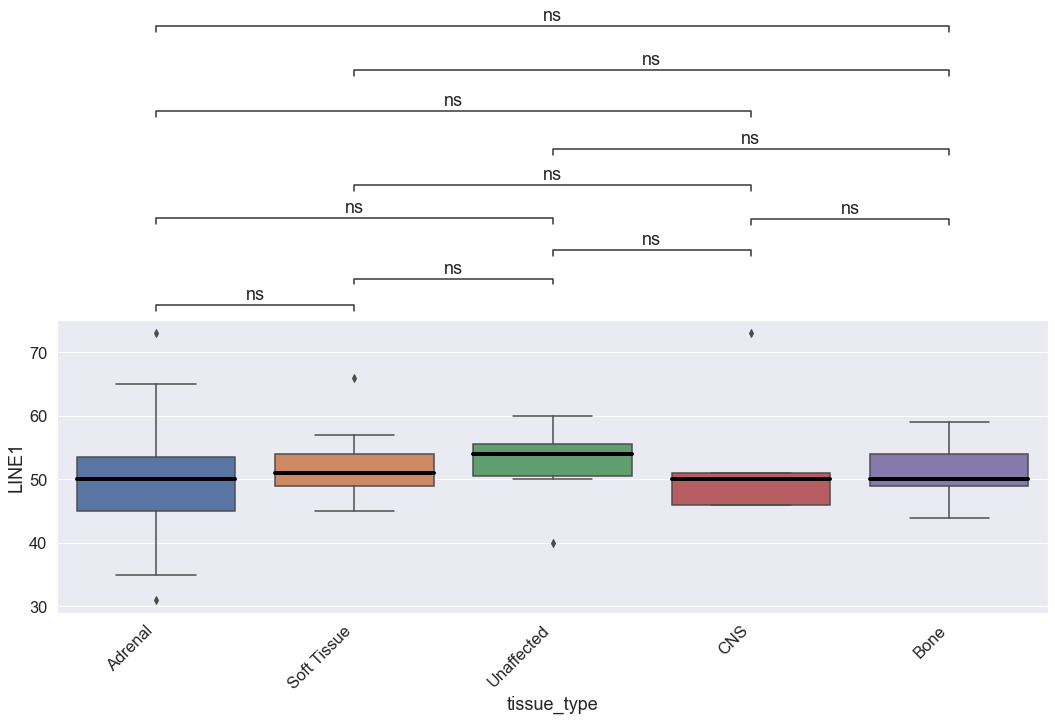

In [148]:
graphBoxGen('tissue_type', lT.drop(['SVA', 'ALU'], axis=1).reset_index(),'LINE1')

ALT  Samples_ID tissue_type  SVA
60   SJACT005_G     Adrenal   11
the outliers for Adrenal are:
['SJACT005_G']

ALT Samples_ID  tissue_type  SVA
1         1092  Soft Tissue   28
6         1843  Soft Tissue   28
9         2349  Soft Tissue   33
47        4227  Soft Tissue   35
49        4329  Soft Tissue   26
the outliers for Soft Tissue are:
['1092', '1843', '2349', '4227', '4329']

Empty DataFrame
Columns: [Samples_ID, tissue_type, SVA]
Index: []
the outliers for Unaffected are:
[]

ALT Samples_ID tissue_type  SVA
27        3356         CNS   37
the outliers for CNS are:
['3356']

ALT Samples_ID tissue_type  SVA
40        3688        Bone   33
57    PD13489b        Bone   19
the outliers for Bone are:
['3688', 'PD13489b']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:3.017e-02 U_stat

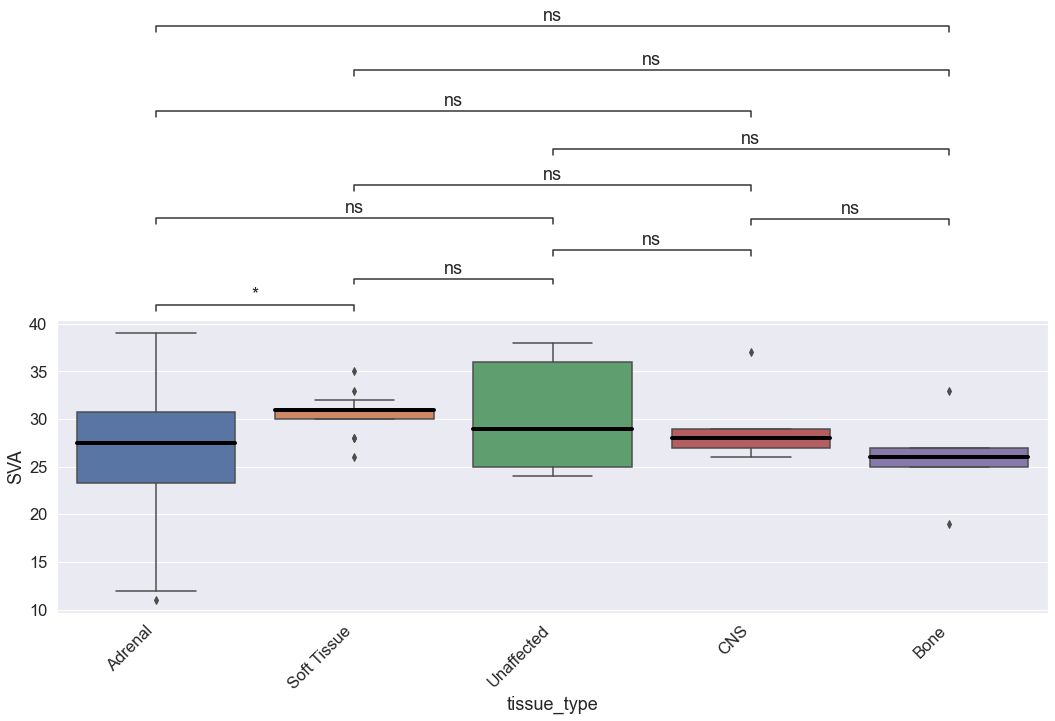

In [149]:
graphBoxGen('tissue_type', lT.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALT Samples_ID cancer_diagnosis   ALU
8       286909           Glioma  2044
28      300683           Glioma  2380
the outliers for Glioma are:
['286909', '300683']

ALT Samples_ID cancer_diagnosis   ALU
6       284386              RMS  4184
the outliers for RMS are:
['284386']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, ALU]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

ALT Samples_ID cancer_diagnosis   ALU
24      299337            Other  1099
the outliers for Other are:
['299337']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.177e-01 U_stat=1.950e+01
RMS vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Undifferentiated sarcoma vs. Other: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Gli

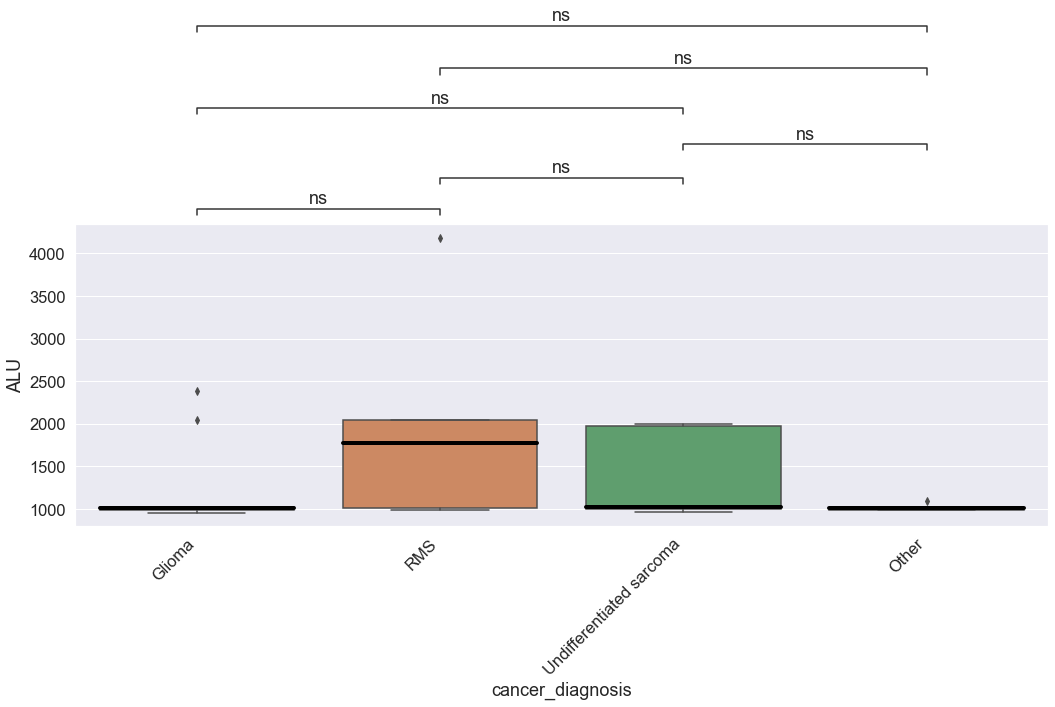

In [150]:
#kics Diagnosis
graphBoxGen('cancer_diagnosis', kD.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT Samples_ID cancer_diagnosis  LINE1
8       286909           Glioma    104
28      300683           Glioma    132
the outliers for Glioma are:
['286909', '300683']

ALT Samples_ID cancer_diagnosis  LINE1
6       284386              RMS    212
the outliers for RMS are:
['284386']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, LINE1]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, LINE1]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.342e-02 U_stat=1.050e+01
RMS vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Undifferentiated sarcoma vs. Other: Mann-Whitney-Wilcoxon test two-sided, P_val:7.533e-01 U_stat=1.450e+01
Glioma 

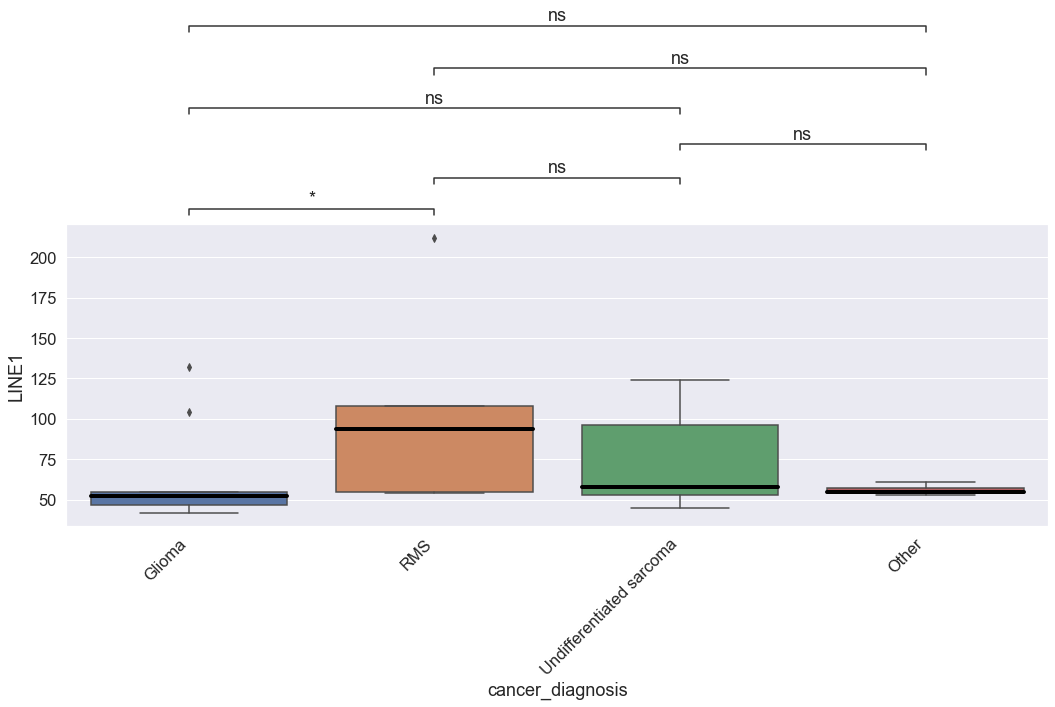

In [151]:
graphBoxGen('cancer_diagnosis', kD.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

ALT Samples_ID cancer_diagnosis  SVA
28      300683           Glioma   84
the outliers for Glioma are:
['300683']

ALT Samples_ID cancer_diagnosis  SVA
6       284386              RMS  120
the outliers for RMS are:
['284386']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for Other are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.523e-01 U_stat=1.750e+01
RMS vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.476e-01 U_stat=1.600e+01
Undifferentiated sarcoma vs. Other: Mann-Whitney-Wilcoxon test two-sided, P_val:2.948e-01 U_stat=1.800e+01
Glioma vs. Undifferentiated sarcoma: Mann-Whitney-Wilcoxon test two-

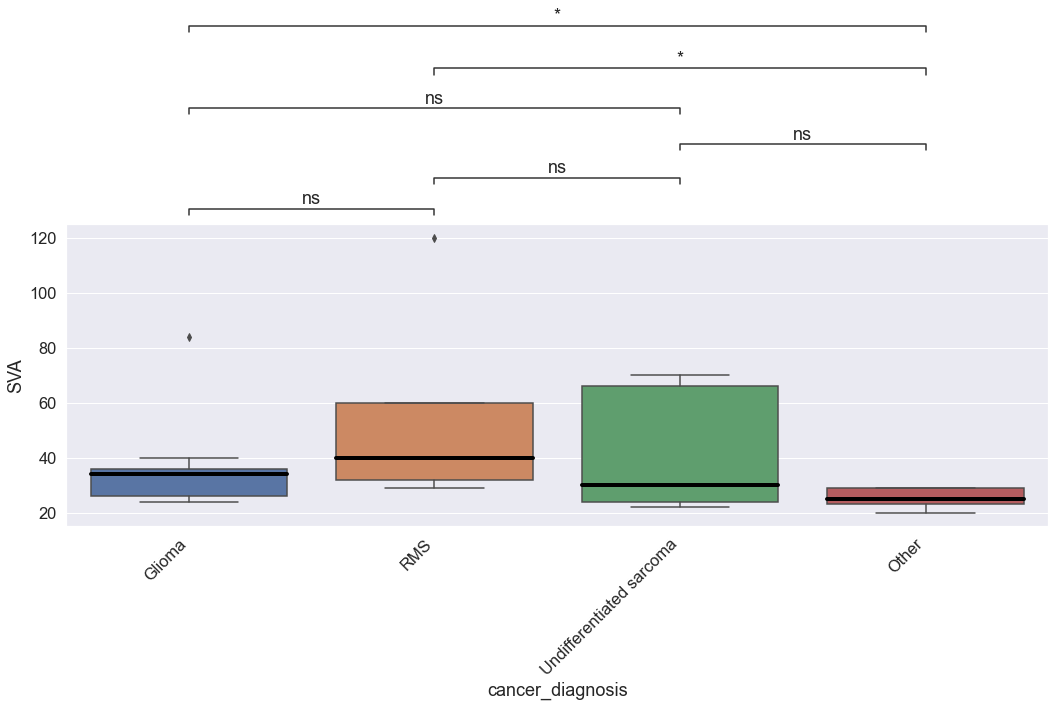

In [152]:
graphBoxGen('cancer_diagnosis', kD.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALT Samples_ID cancer_diagnosis   ALU
8         2262              RMS  1229
the outliers for RMS are:
['2262']

ALT Samples_ID cancer_diagnosis   ALU
14        2465       Unaffected  1027
26        3334       Unaffected   945
43        3806       Unaffected   950
the outliers for Unaffected are:
['2465', '3334', '3806']

ALT  Samples_ID cancer_diagnosis   ALU
29         3365              ACC  1172
60   SJACT005_G              ACC   676
61   SJACT007_G              ACC   808
62   SJACT008_G              ACC   797
the outliers for ACC are:
['3365', 'SJACT005_G', 'SJACT007_G', 'SJACT008_G']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:8.189e-01 U_stat=4.600e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.826e-01 U_stat=1.380e+02
RMS vs. ACC: Mann-Whitney-Wilcoxon test t

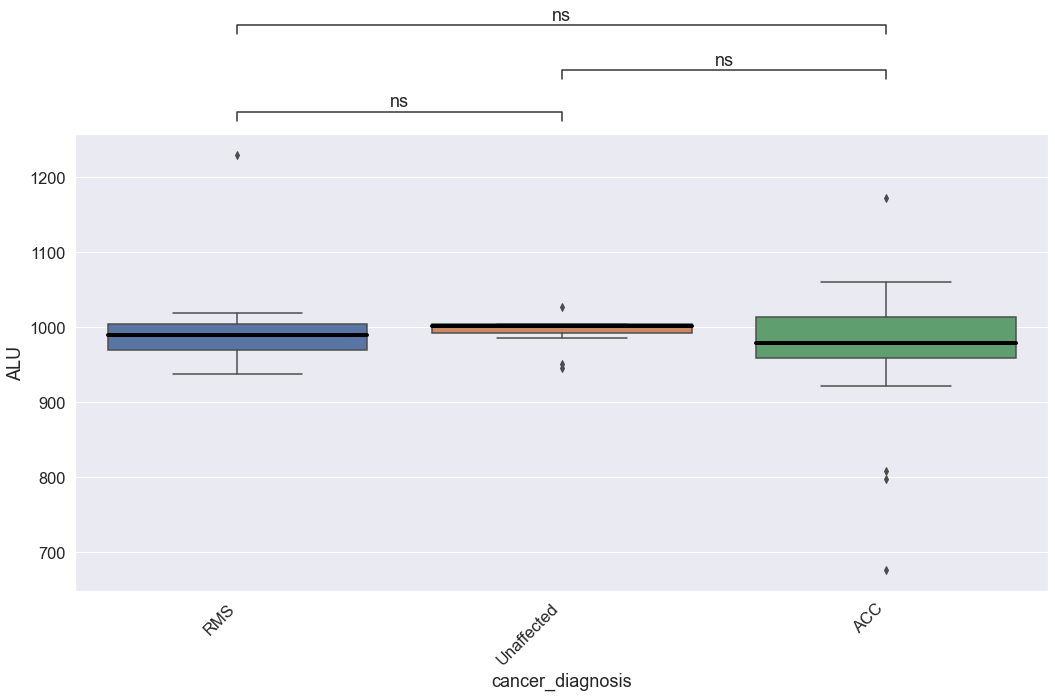

In [153]:
graphBoxGen('cancer_diagnosis', lD.drop(['LINE1', 'SVA'], axis=1).reset_index(),'ALU')

ALT Samples_ID cancer_diagnosis  LINE1
8         2262              RMS     66
the outliers for RMS are:
['2262']

ALT Samples_ID cancer_diagnosis  LINE1
22        3273       Unaffected     40
the outliers for Unaffected are:
['3273']

ALT Samples_ID cancer_diagnosis  LINE1
29        3365              ACC     73
the outliers for ACC are:
['3365']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:5.417e-01 U_stat=4.100e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.575e-01 U_stat=1.515e+02
RMS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.821e-01 U_stat=1.105e+02


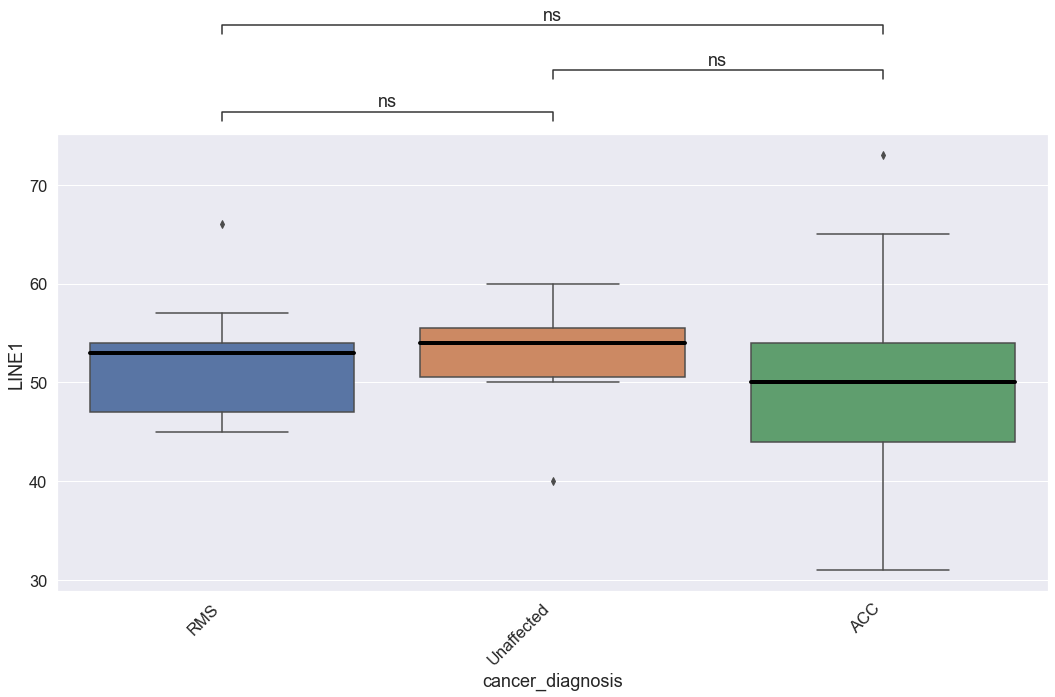

In [154]:
graphBoxGen('cancer_diagnosis', lD.drop(['ALU', 'SVA'], axis=1).reset_index(),'LINE1')

ALT Samples_ID cancer_diagnosis  SVA
47        4227              RMS   35
49        4329              RMS   26
the outliers for RMS are:
['4227', '4329']

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for Unaffected are:
[]

Empty DataFrame
Columns: [Samples_ID, cancer_diagnosis, SVA]
Index: []
the outliers for ACC are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:4.219e-01 U_stat=6.050e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.012e-01 U_stat=1.420e+02
RMS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:3.238e-02 U_stat=1.420e+02


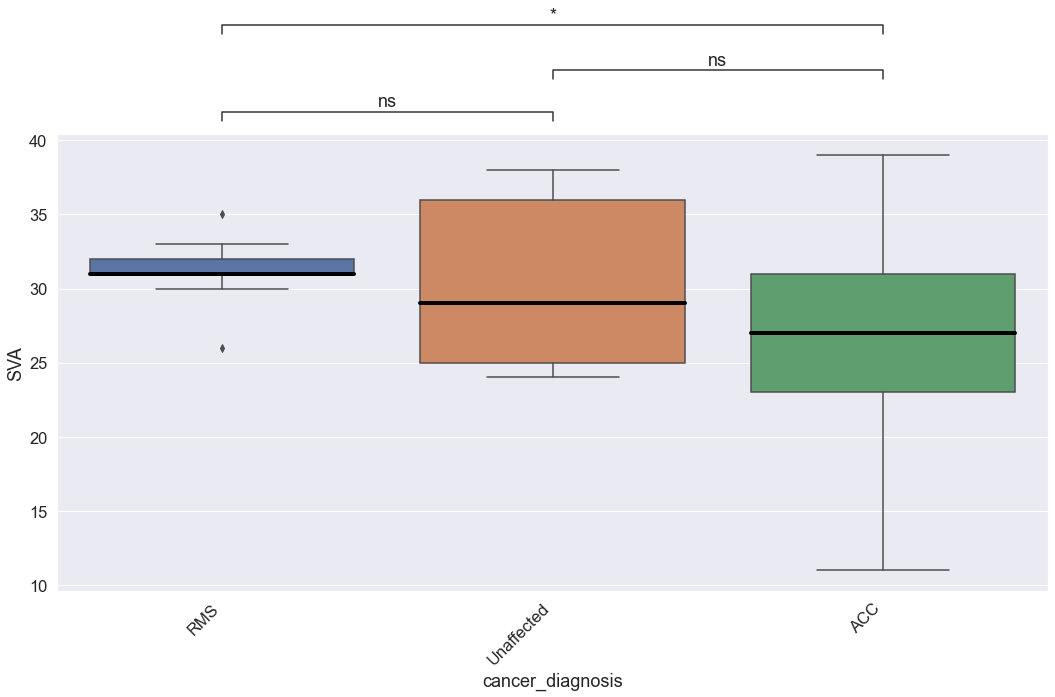

In [155]:
graphBoxGen('cancer_diagnosis', lD.drop(['LINE1', 'ALU'], axis=1).reset_index(),'SVA')

ALL
Empty DataFrame
Columns: [Samples_ID, freq, dataset]
Index: []
the outliers for unaffected are:
[]

    Samples_ID  freq dataset
0         3356  1347  cancer
1         2262  1325  cancer
2         3365  1284  cancer
3         3503  1152  cancer
4         5567  1142  cancer
48  SJACT002_G   992  cancer
49  SJACT007_G   862  cancer
50  SJACT008_G   846  cancer
51  SJACT005_G   718  cancer
the outliers for cancer are:
['3356', '2262', '3365', '3503', '5567', 'SJACT002_G', 'SJACT007_G', 'SJACT008_G', 'SJACT005_G']

ALU
   Samples_ID  ALT  freq     dataset
0        2465  ALU  1027  unaffected
9        3806  ALU   950  unaffected
10       3334  ALU   945  unaffected
the outliers for unaffected are:
['2465', '3806', '3334']

    Samples_ID  ALT  freq dataset
0         3356  ALU  1237  cancer
1         2262  ALU  1229  cancer
2         3365  ALU  1172  cancer
3         5567  ALU  1065  cancer
4         3503  ALU  1060  cancer
49  SJACT007_G  ALU   808  cancer
50  SJACT008_G  ALU   797  can

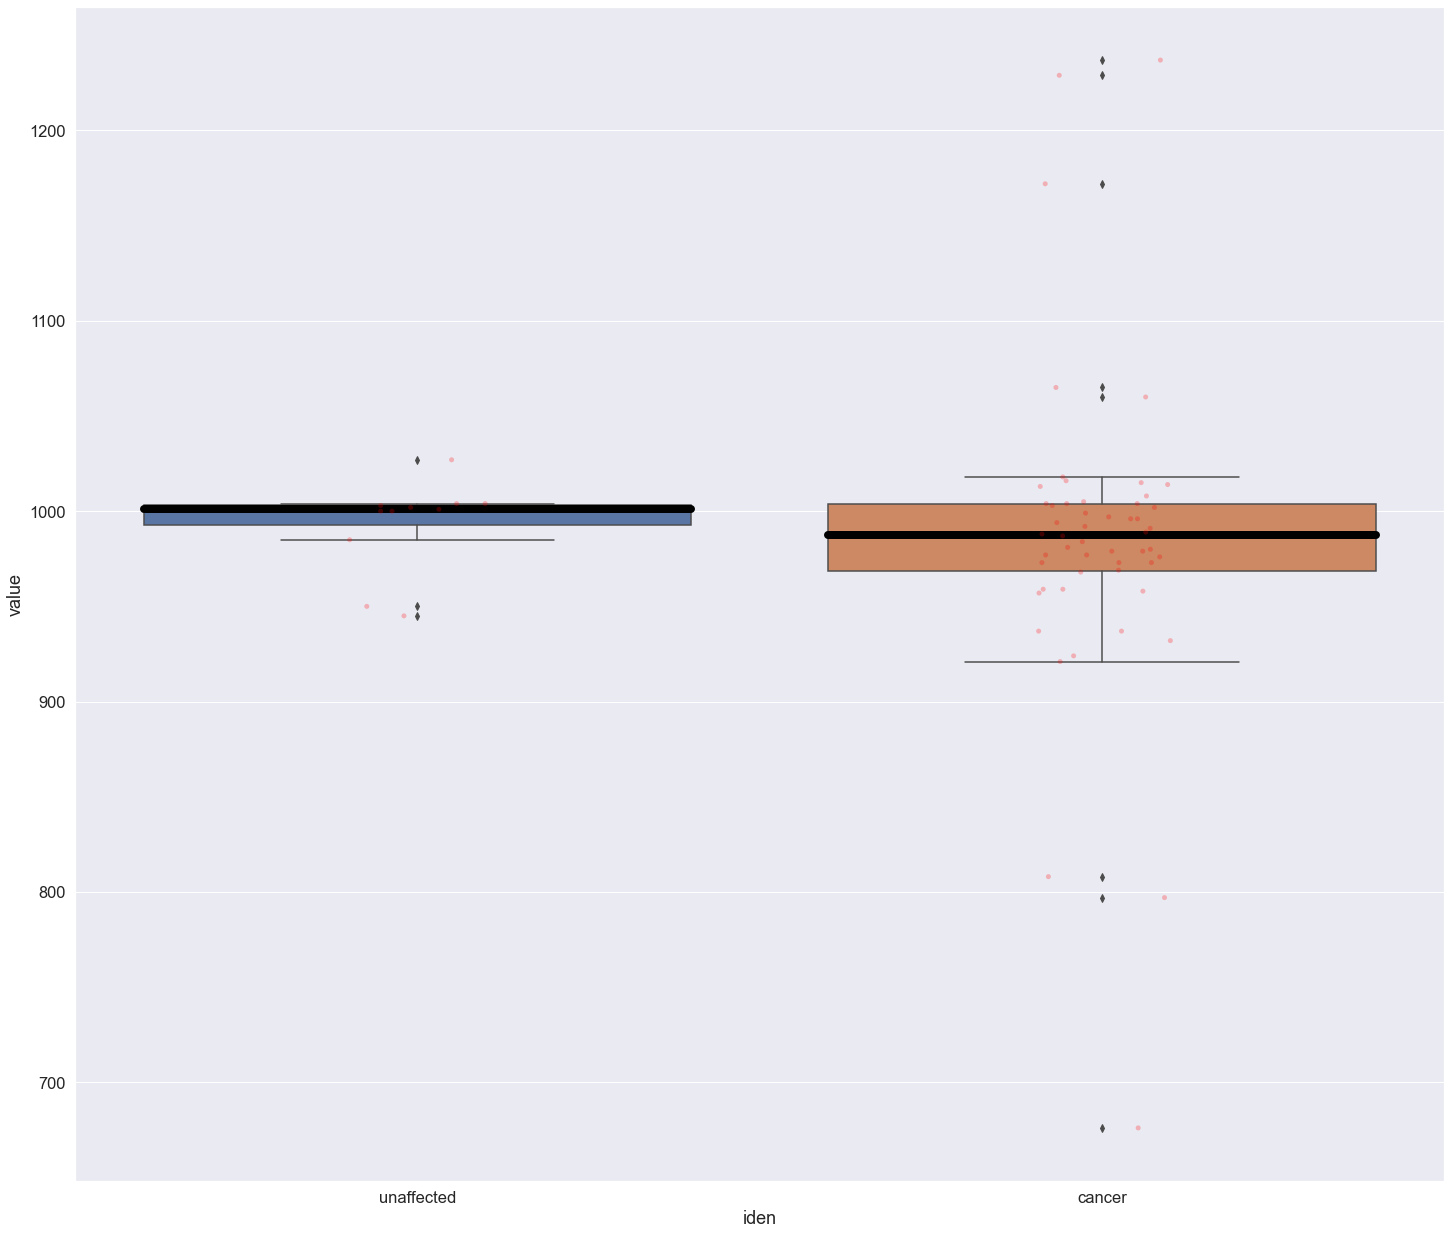

LINE1
MannwhitneyuResult(statistic=367.5, pvalue=0.1410915439773128)


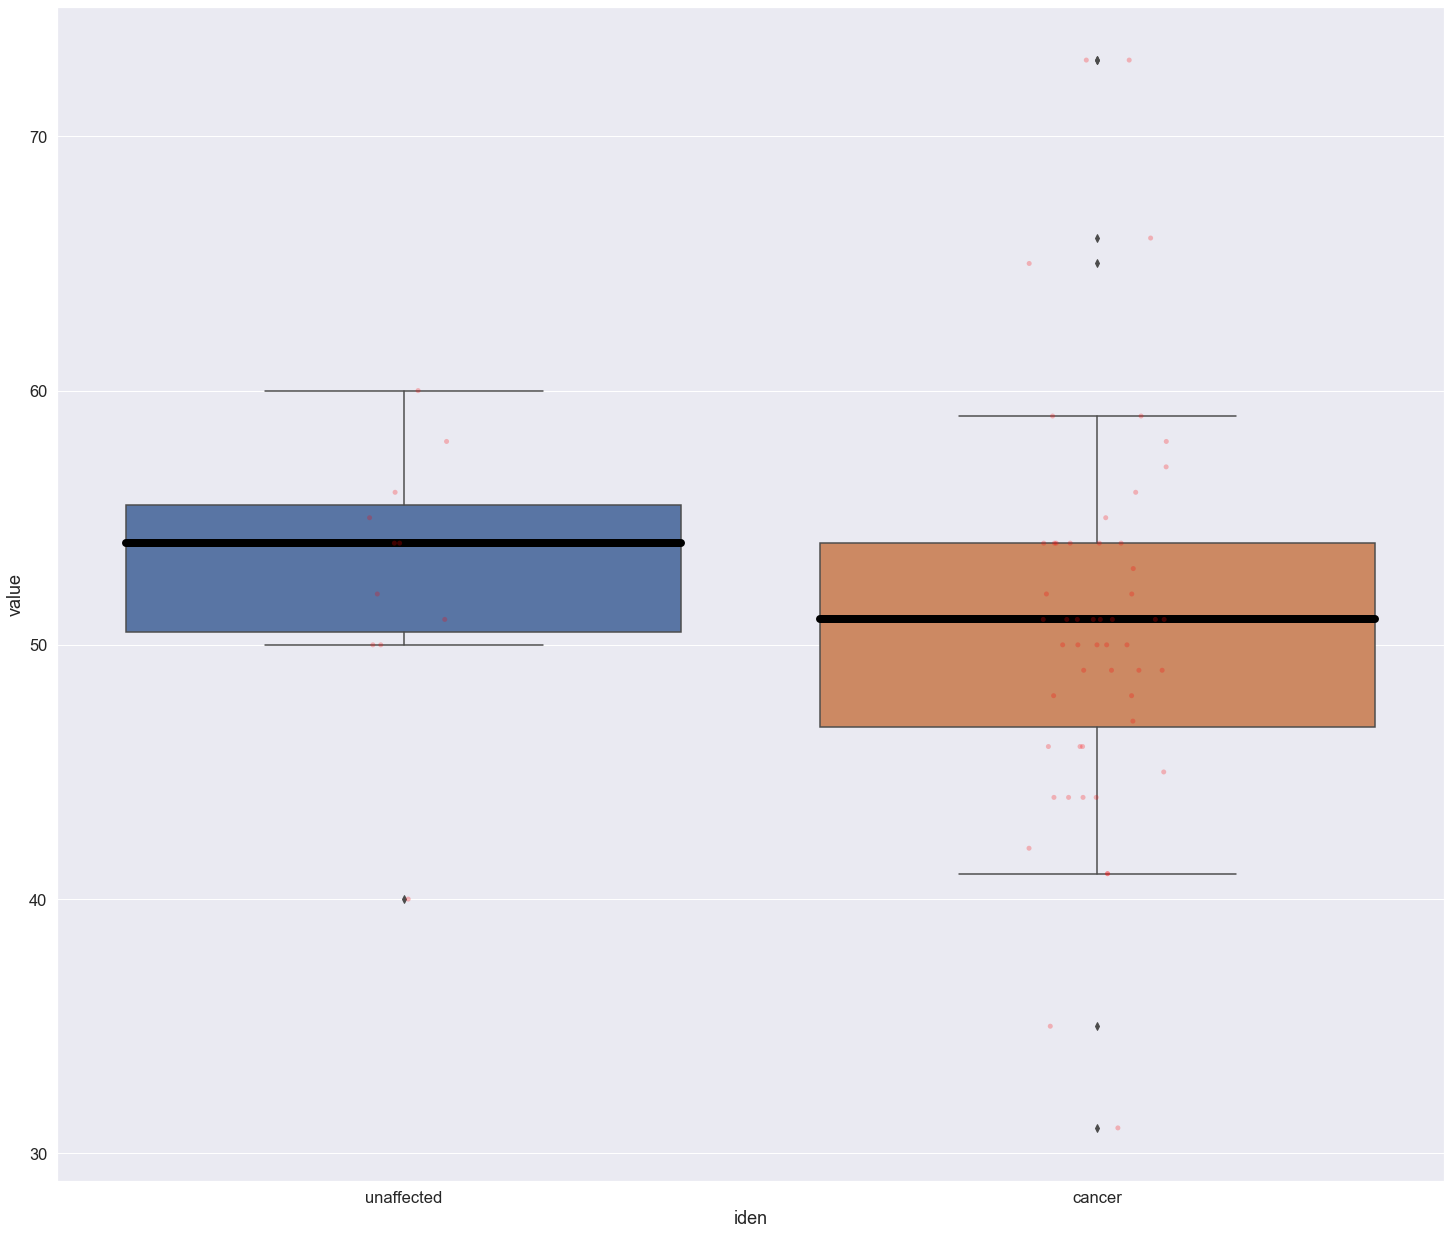

SVA
MannwhitneyuResult(statistic=298.5, pvalue=0.8274816180334266)


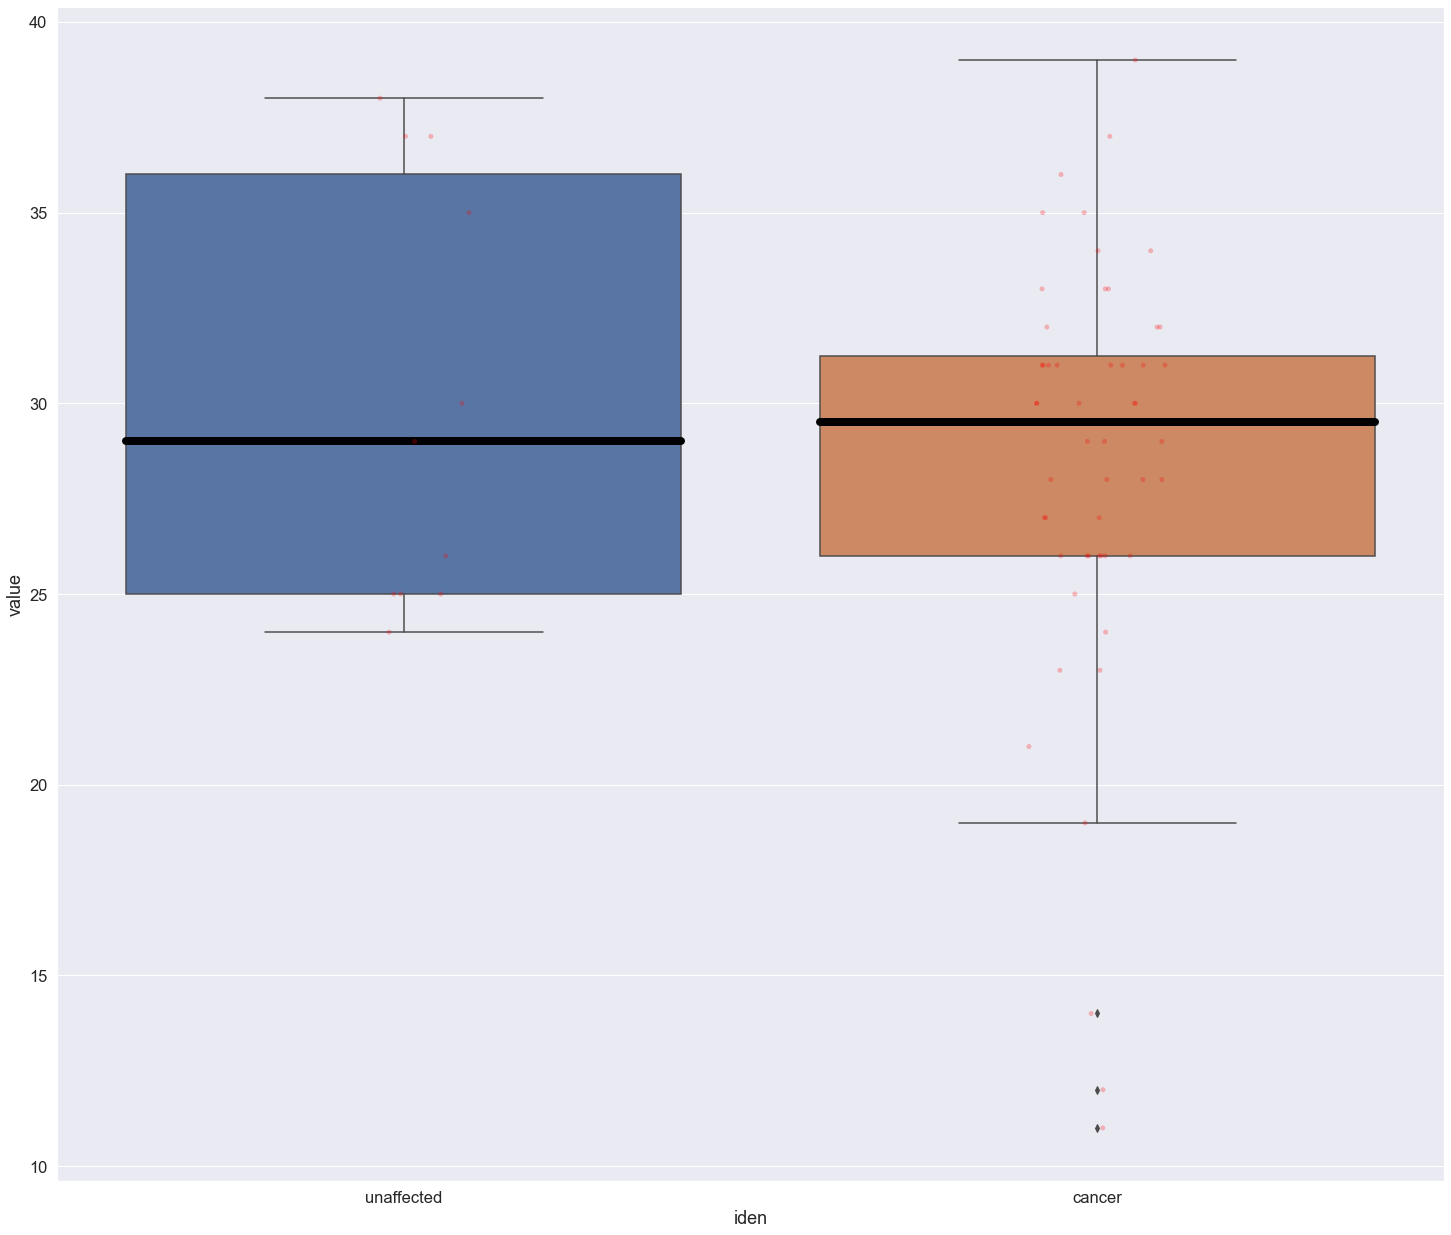

ALLL
MannwhitneyuResult(statistic=369.5, pvalue=0.13283911046991184)


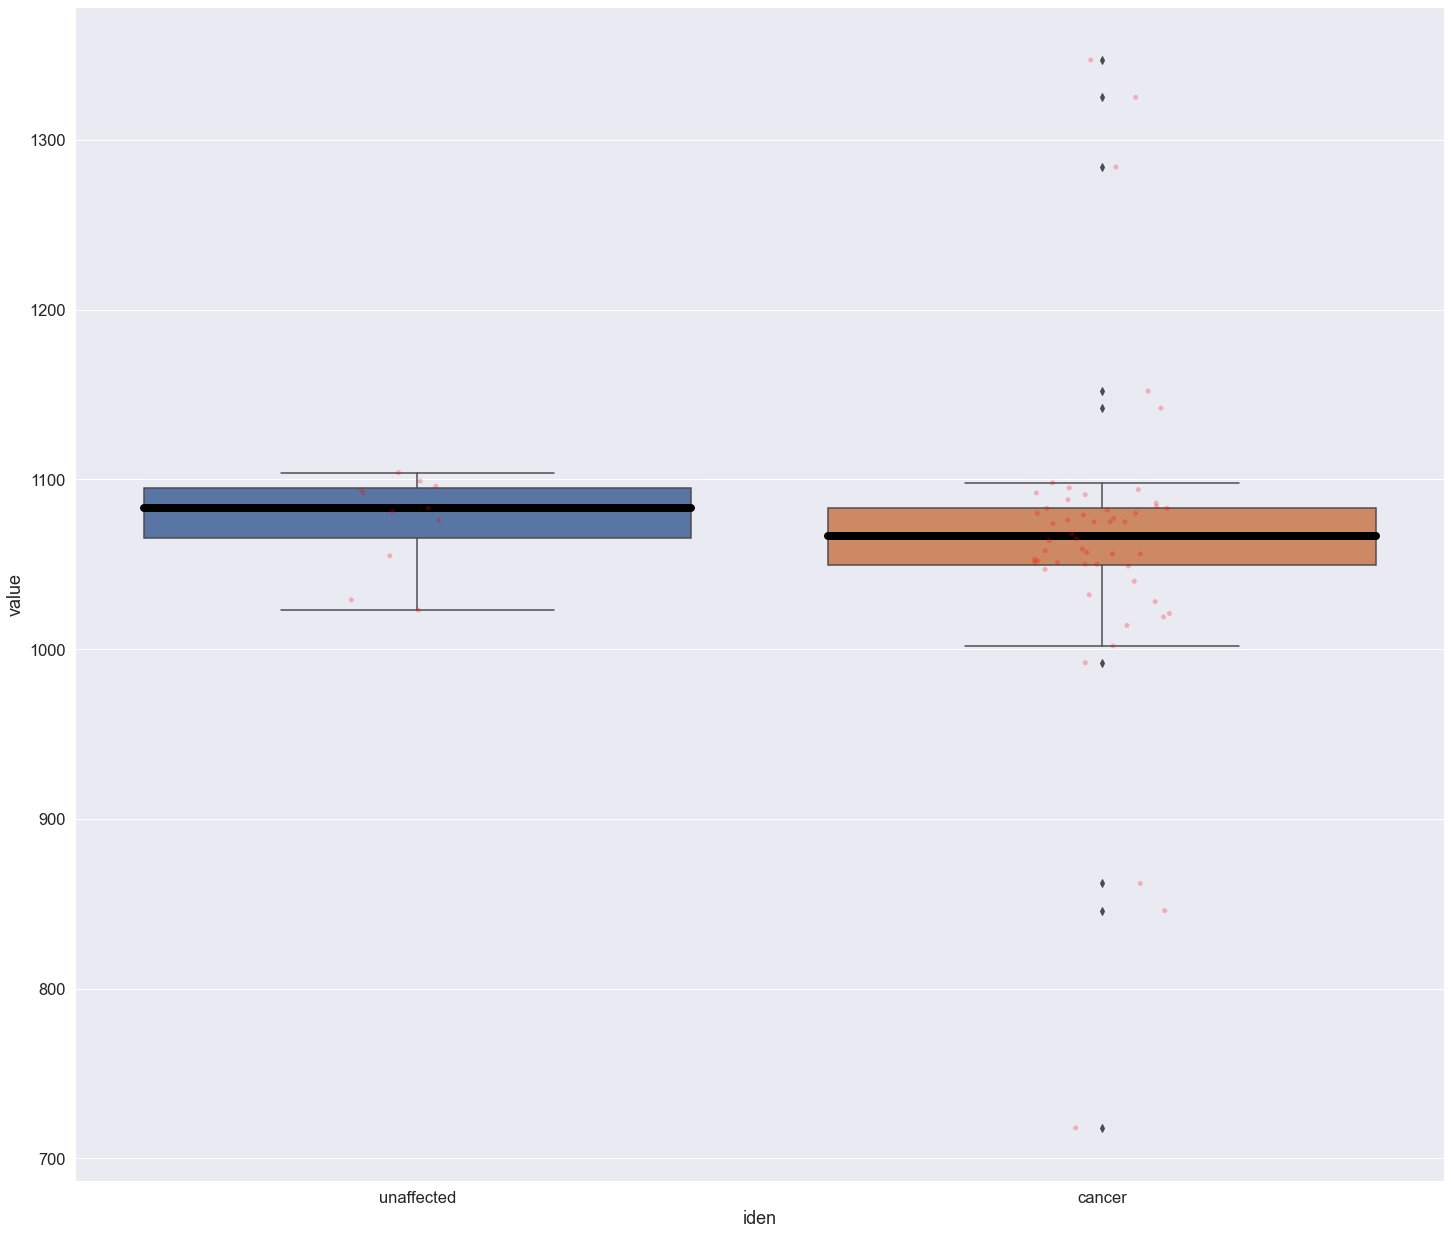

In [189]:
"""
LFS vs Unaffected
3 Big graphs for TE elements ALU LINE1 SVA
"""
#check if unaffected tissue type is unaffected diag and vice versa -> they are
# print(bigLdf.head(20))
# print(bigLdf['tissue_type'].unique())
# tempUnaffectedT = bigLdf[bigLdf['tissue_type']=='Unaffected']
# tempUnaffectedD = bigLdf[bigLdf['cancer_diagnosis']=='Unaffected']
# print(tempUnaffectedT['Samples_ID'].unique())
# print(tempUnaffectedT['cancer_diagnosis'].unique())
# print(tempUnaffectedD['Samples_ID'].unique())
# print(tempUnaffectedD['cancer_diagnosis'].unique())


unaffectedDf = bigLdf[bigLdf['tissue_type']=='Unaffected'].drop(['sample', 'tissue_type',
                                                                 'cancer_diagnosis','SV_type','ageofonset'], axis=1)
cancerDf = bigLdf[bigLdf['tissue_type']!='Unaffected'].drop(['sample', 'tissue_type',
                                                                 'cancer_diagnosis','SV_type','ageofonset'], axis=1)
uAll = unaffectedDf.drop(['ALT'],axis=1).value_counts().to_frame().reset_index()
uAll = uAll.rename(columns={0:'freq'})
uAll['dataset'] = 'unaffected'
cAll = cancerDf.drop(['ALT'],axis=1).value_counts().to_frame().reset_index()
cAll = cAll.rename(columns={0:'freq'})
cAll['dataset'] = 'cancer'
mergedAll = pd.DataFrame(data={'unaffected':uAll['freq'], 'cancer':cAll['freq']})
print('ALL')
outliersInDf(pd.concat([uAll,cAll]),'dataset','freq')


uAlu = unaffectedDf[unaffectedDf['ALT'] == 'ALU'].value_counts().to_frame().reset_index()
uAlu = uAlu.rename(columns={0:'freq'})
uAlu['dataset'] = 'unaffected'

cAlu = cancerDf[cancerDf['ALT'] == 'ALU'].value_counts().to_frame().reset_index()
cAlu = cAlu.rename(columns={0:'freq'})
cAlu['dataset'] = 'cancer'
mergedAlu = pd.DataFrame(data = {'unaffected':uAlu['freq'],'cancer':cAlu['freq']})
print('ALU')
outliersInDf(pd.concat([uAlu,cAlu]),'dataset','freq')



uLine = unaffectedDf[unaffectedDf['ALT'] == 'LINE1'].value_counts().to_frame().reset_index()
uLine = uLine.rename(columns={0:'freq'})
uLine['dataset'] = 'unaffected'
cLine = cancerDf[cancerDf['ALT'] == 'LINE1'].value_counts().to_frame().reset_index()
cLine = cLine.rename(columns={0:'freq'})
cLine['dataset'] = 'cancer'
mergedLine = pd.DataFrame(data = {'unaffected':uLine['freq'],'cancer':cLine['freq']})
print('LINE1')
outliersInDf(pd.concat([uLine,cLine]),'dataset','freq')

uSva = unaffectedDf[unaffectedDf['ALT'] == 'SVA'].value_counts().to_frame().reset_index()
uSva = uSva.rename(columns={0:'freq'})
uSva['dataset'] = 'unaffected'
cSva = cancerDf[cancerDf['ALT'] == 'SVA'].value_counts().to_frame().reset_index()
cSva = cSva.rename(columns={0:'freq'})
cSva['dataset'] = 'cancer'
mergedSva = pd.DataFrame(data = {'unaffected':uSva['freq'],'cancer':cSva['freq']})
print('SVA')
outliersInDf(pd.concat([uSva,cSva]),'dataset','freq')

#print(mergedInv)
title = ['unaffected','cancer']

boxplotPoints(title, title, mergedAlu)
print('LINE1')
boxplotPoints(title, title, mergedLine)
print('SVA')
boxplotPoints(title, title, mergedSva)

print('ALLL')
boxplotPoints(title, title, mergedAll)


In [174]:
"""
LFS vs Kics for Diagnosis and Tissue type. Overall and TE specific
"""

def graphSVTissue(kdf, ldf, hogobogo, isTissue):
    if isTissue:
        var = 'tissue_type'

    else:
        var = 'cancer_diagnosis'
    
    kdf = kdf.drop(['ALT'], axis=1)
    kdf = kdf.groupby(['Samples_ID']).value_counts()
    kdf = kdf.to_frame().reset_index()
    kdf.rename(columns = {0:'freq'}, inplace = True)
    
    kdf = filterBig(kdf,var)
    
    #print the outlier!
    #print(kdf.loc[kdf['freq'] > 4000])
    
    
    #kdf = pd.melt(kdf, id_vars=[var], value_vars=['freq'])
    kdf['dataset'] = 'kics'
    

    ldf = ldf.drop(['ALT'], axis=1)
    ldf = ldf.groupby(['Samples_ID']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = filterBig(ldf,var)
    
    #print(ldf.head(30))
    #ldf = pd.melt(ldf, id_vars=[var], value_vars=['freq'])
    ldf['dataset'] = 'lfs'
    mergedDf = pd.concat([ldf, kdf])
    
    #excluding all that don't have a pair         
    excludeList = list(set(ldf[var]).symmetric_difference(set(kdf[var])))
    #print(excludeList)
    mergedDf = mergedDf[~mergedDf[var].isin(excludeList)]
    
    #print(mergedDf.head(50))
    
    uniqueList = list(mergedDf[var].unique())
    
    BoxGraphMultii(mergedDf, var, 'freq', 'dataset', uniqueList) 

In [160]:
kDiagList = pd.DataFrame(data={'diag':bigKdf['cancer_diagnosis'], 'id':bigKdf['Samples_ID']}) 
lDiagList = pd.DataFrame(data={'diag':bigLdf['cancer_diagnosis'], 'id':bigLdf['Samples_ID']})
uniqueDiag = list(set(list(kDiagList['diag'].unique())+list(lDiagList['diag'].unique())))

ktList = pd.DataFrame(data={'tissue_type':bigKdf['tissue_type'], 'id':bigKdf['Samples_ID']})
ltList = pd.DataFrame(data={'tissue_type':bigLdf['tissue_type'], 'id':bigLdf['Samples_ID']})
uniqueTissue = list(set(list(ktList['tissue_type'].unique())+list(ltList['tissue_type'].unique())))

   Samples_ID cancer_diagnosis  freq dataset
2        1355              RMS  1058     lfs
7        2085              RMS  1077     lfs
8        2262              RMS  1325     lfs
9        2349              RMS  1083     lfs
21      3136A              RMS  1080     lfs
41       3763              RMS  1050     lfs
47       4227              RMS  1019     lfs
49       4329              RMS  1098     lfs
55         93              RMS  1021     lfs
2      273308              RMS  1948    kics
6      284386              RMS  4516    kics
19     297043              RMS  1073    kics
22     298866              RMS  1096    kics
34     305082              RMS  2178    kics
LFS
  Samples_ID cancer_diagnosis  freq dataset
8       2262              RMS  1325     lfs
the outliers for RMS are:
['2262']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS  4516    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e

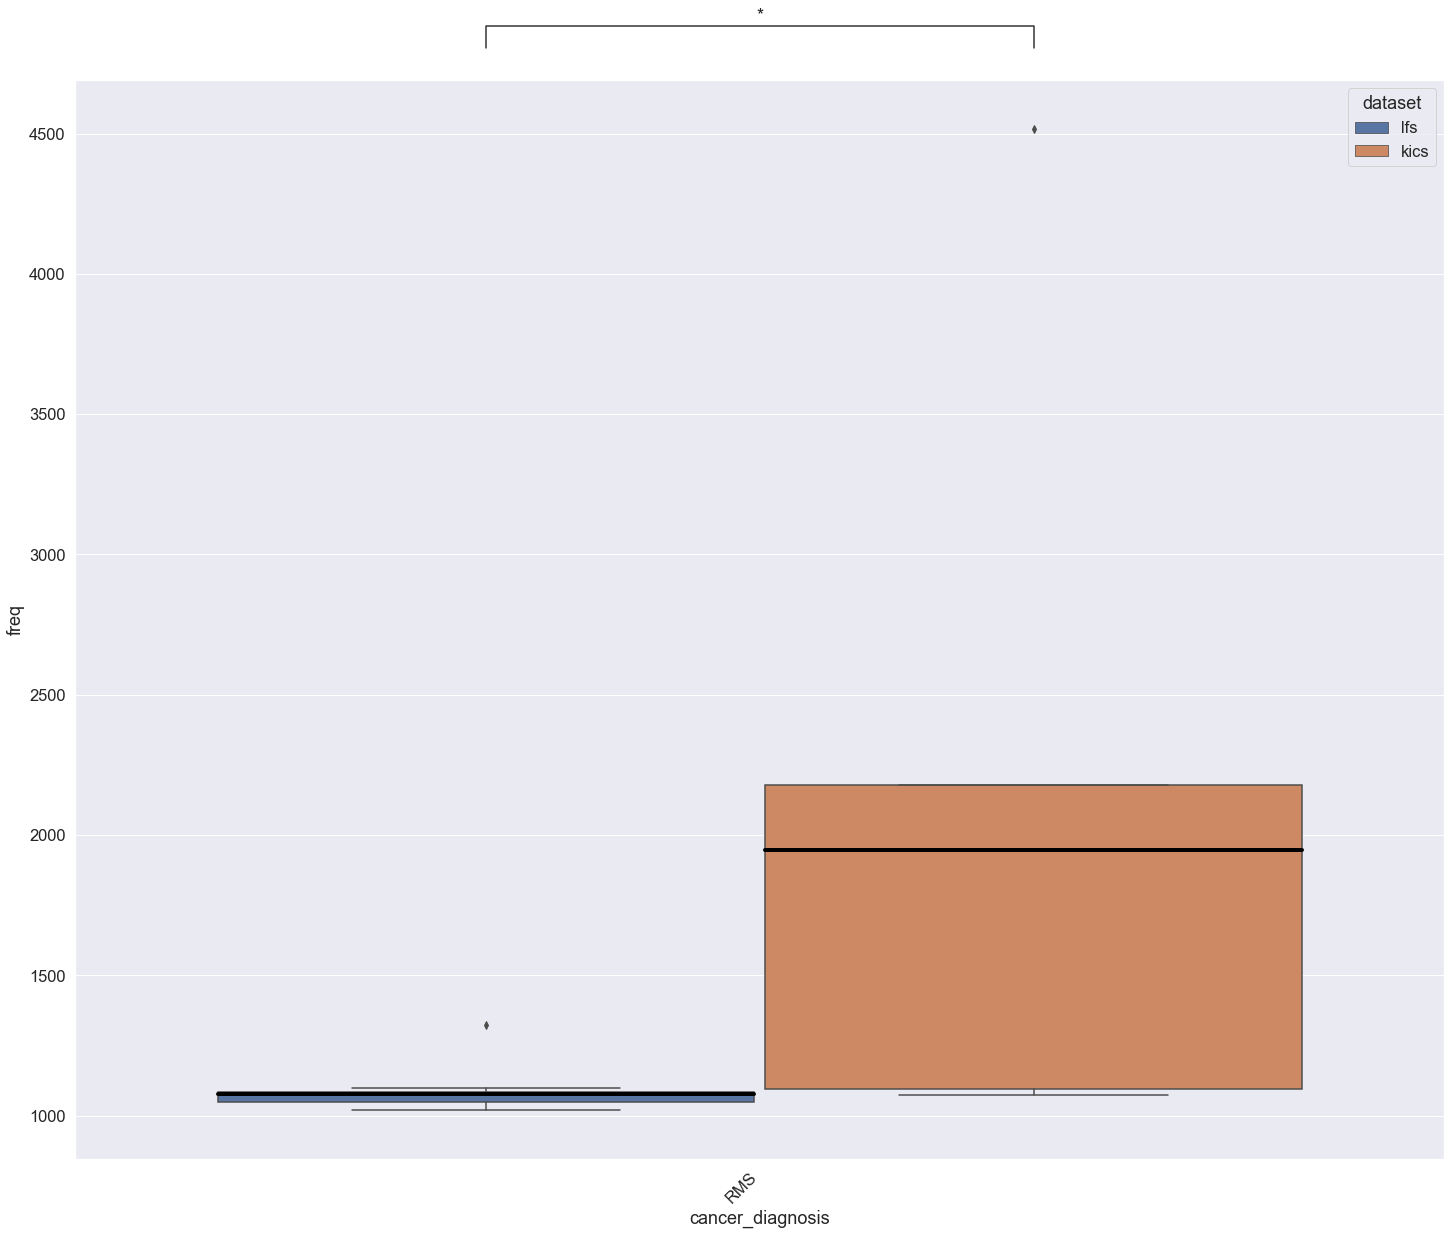

In [168]:
kicsTissue = bigKdf.drop(['SV_type','abbv_id','sample', 'tumour_class', 'cancer_diagnosis','ageofonset'], axis=1)
kicsDiag = bigKdf.drop(['SV_type','abbv_id','sample', 'tumour_class','ageofonset', 'tissue_type'], axis=1)

lfsTissue = bigLdf.drop(['cancer_diagnosis', 'sample','SV_type','ageofonset'],axis=1)
lfsDiag = bigLdf.drop(['tissue_type', 'sample','SV_type','ageofonset'],axis=1)

graphSVTissue(kicsDiag, lfsDiag, uniqueDiag, False)

LFS
  Samples_ID  tissue_type  freq dataset
8       2262  Soft Tissue  1325     lfs
the outliers for Soft Tissue are:
['2262']

   Samples_ID tissue_type  freq dataset
27       3356         CNS  1347     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS  3192    kics
8      286909         CNS  2184    kics
28     300683         CNS  2596    kics
the outliers for CNS are:
['271116', '286909', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue  4516    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.613e-01 U_stat=3.500e+01
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:3.003e-02 U_stat=1.000e+01


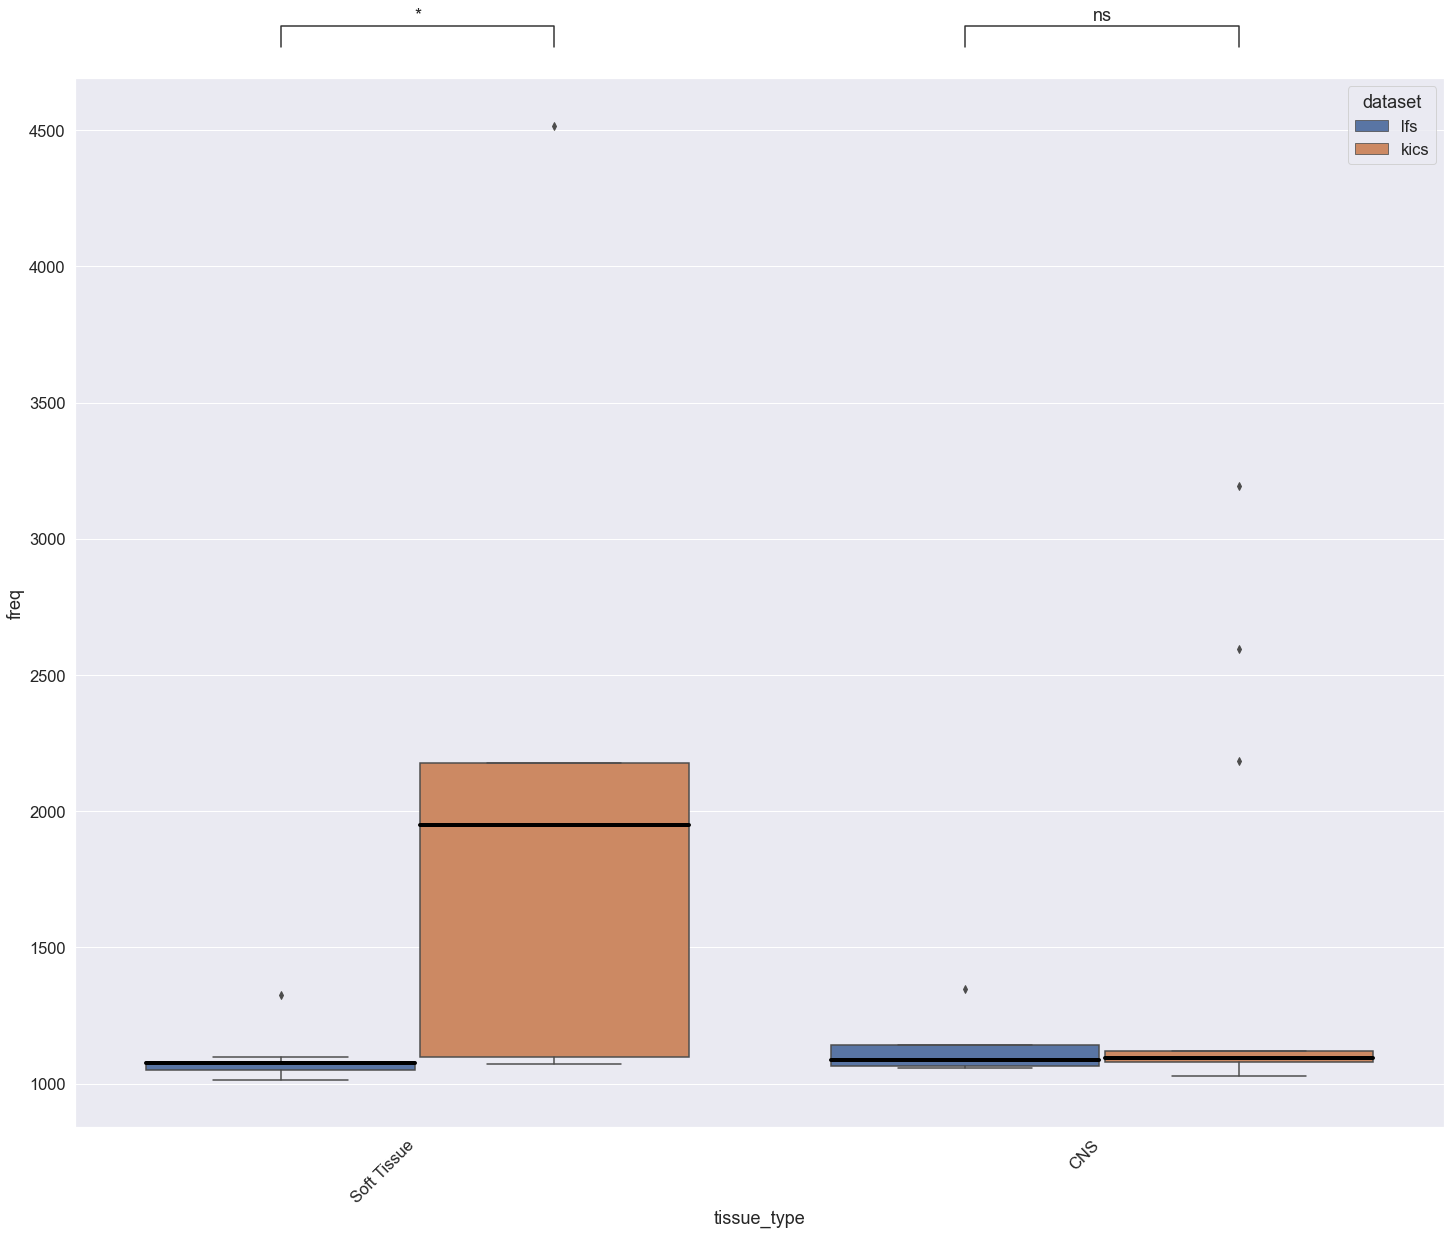

In [175]:
graphSVTissue(kicsTissue, lfsTissue, uniqueTissue, True)

In [176]:
print(bigLdf.columns)

Index(['Samples_ID', 'SV_type', 'ALT', 'sample', 'tissue_type',
       'cancer_diagnosis', 'ageofonset'],
      dtype='object')


In [177]:
"""
Creating DFs needed for lfs vs kics tissue and diag
"""
kDF = bigKdf.drop(['SV_type', 'abbv_id', 'sample', 'tumour_class','ageofonset'],axis=1)
lDF = bigLdf.drop(['SV_type','sample','ageofonset'],axis=1)

kAlu = kDF.loc[kDF['ALT'] == 'ALU']
kLine = kDF.loc[kDF['ALT'] == 'LINE1']
kSva = kDF.loc[kDF['ALT'] == 'SVA']

lAlu = lDF.loc[lDF['ALT'] == 'ALU']
lLine = lDF.loc[lDF['ALT'] == 'LINE1']
lSva = lDF.loc[lDF['ALT'] == 'SVA']

LFS
  Samples_ID  tissue_type  freq dataset
8       2262  Soft Tissue  1229     lfs
the outliers for Soft Tissue are:
['2262']

   Samples_ID tissue_type  freq dataset
27       3356         CNS  1237     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS  2961    kics
8      286909         CNS  2044    kics
28     300683         CNS  2380    kics
the outliers for CNS are:
['271116', '286909', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue  4184    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:8.001e-01 U_stat=3.400e+01
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.994e-02 U_stat=1.000e+01


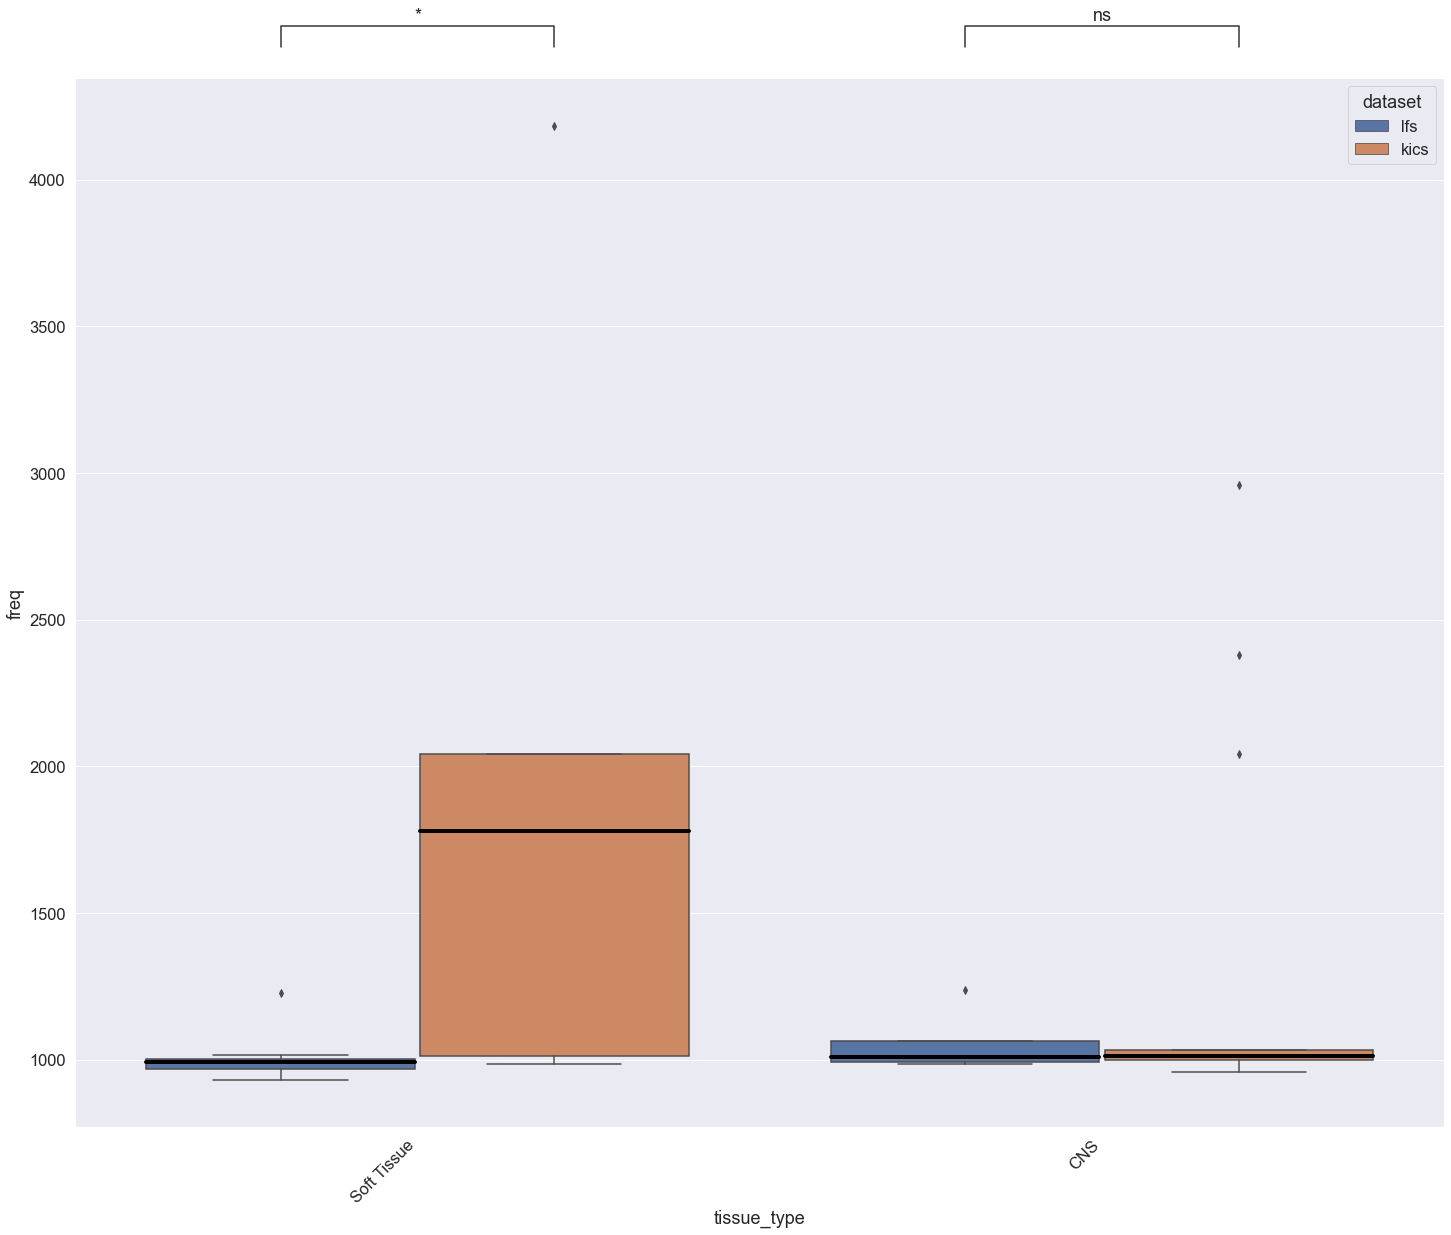

In [178]:
graphSVTissue(kAlu.drop(['cancer_diagnosis'],axis=1), lAlu.drop(['cancer_diagnosis'],axis=1), uniqueTissue, True)


LFS
  Samples_ID  tissue_type  freq dataset
8       2262  Soft Tissue    66     lfs
the outliers for Soft Tissue are:
['2262']

   Samples_ID tissue_type  freq dataset
27       3356         CNS    73     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS   150    kics
8      286909         CNS   104    kics
28     300683         CNS   132    kics
the outliers for CNS are:
['271116', '286909', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue   212    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:5.117e-01 U_stat=2.950e+01
Soft Tissue_lfs vs. Soft Tissue_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.344e-02 U_stat=7.000e+00


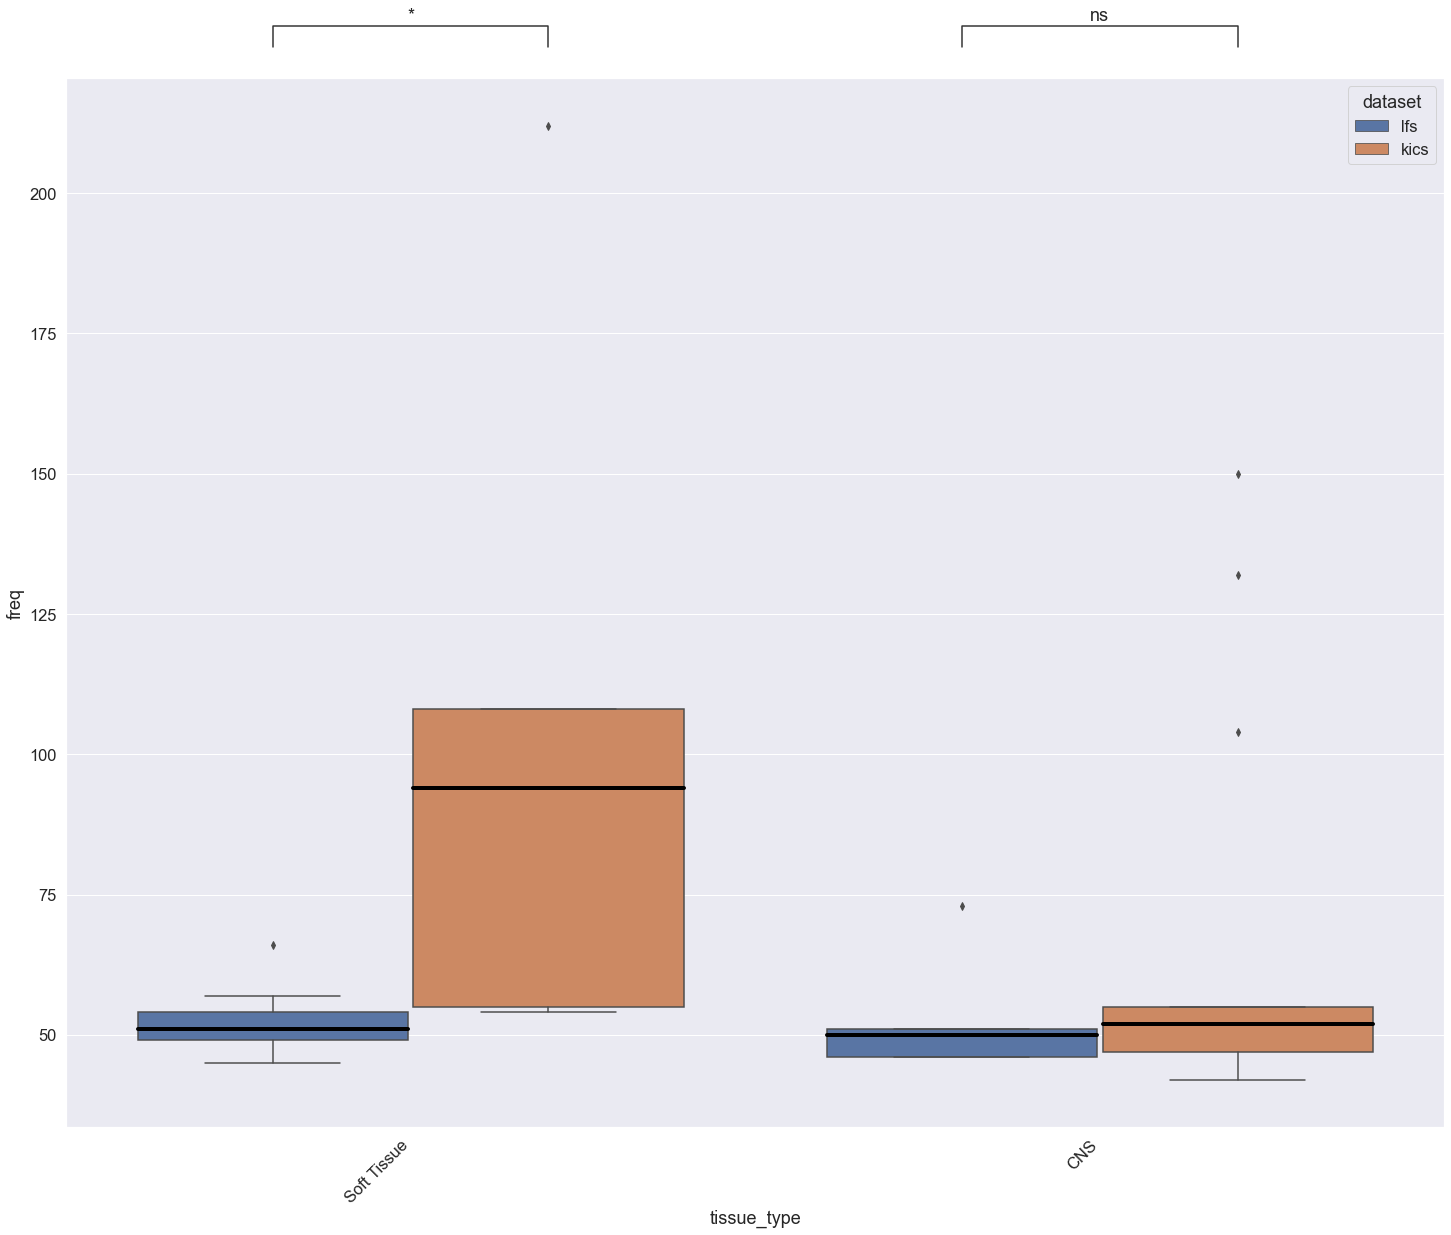

In [179]:
graphSVTissue(kLine.drop(['cancer_diagnosis'],axis=1), lLine.drop(['cancer_diagnosis'],axis=1), uniqueTissue, True)

LFS
   Samples_ID  tissue_type  freq dataset
1        1092  Soft Tissue    28     lfs
6        1843  Soft Tissue    28     lfs
9        2349  Soft Tissue    33     lfs
47       4227  Soft Tissue    35     lfs
49       4329  Soft Tissue    26     lfs
the outliers for Soft Tissue are:
['1092', '1843', '2349', '4227', '4329']

   Samples_ID tissue_type  freq dataset
27       3356         CNS    37     lfs
the outliers for CNS are:
['3356']

KICS
   Samples_ID tissue_type  freq dataset
1      271116         CNS    81    kics
28     300683         CNS    84    kics
the outliers for CNS are:
['271116', '300683']

  Samples_ID  tissue_type  freq dataset
6     284386  Soft Tissue   120    kics
the outliers for Soft Tissue are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS_lfs vs. CNS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.059e-01 U_

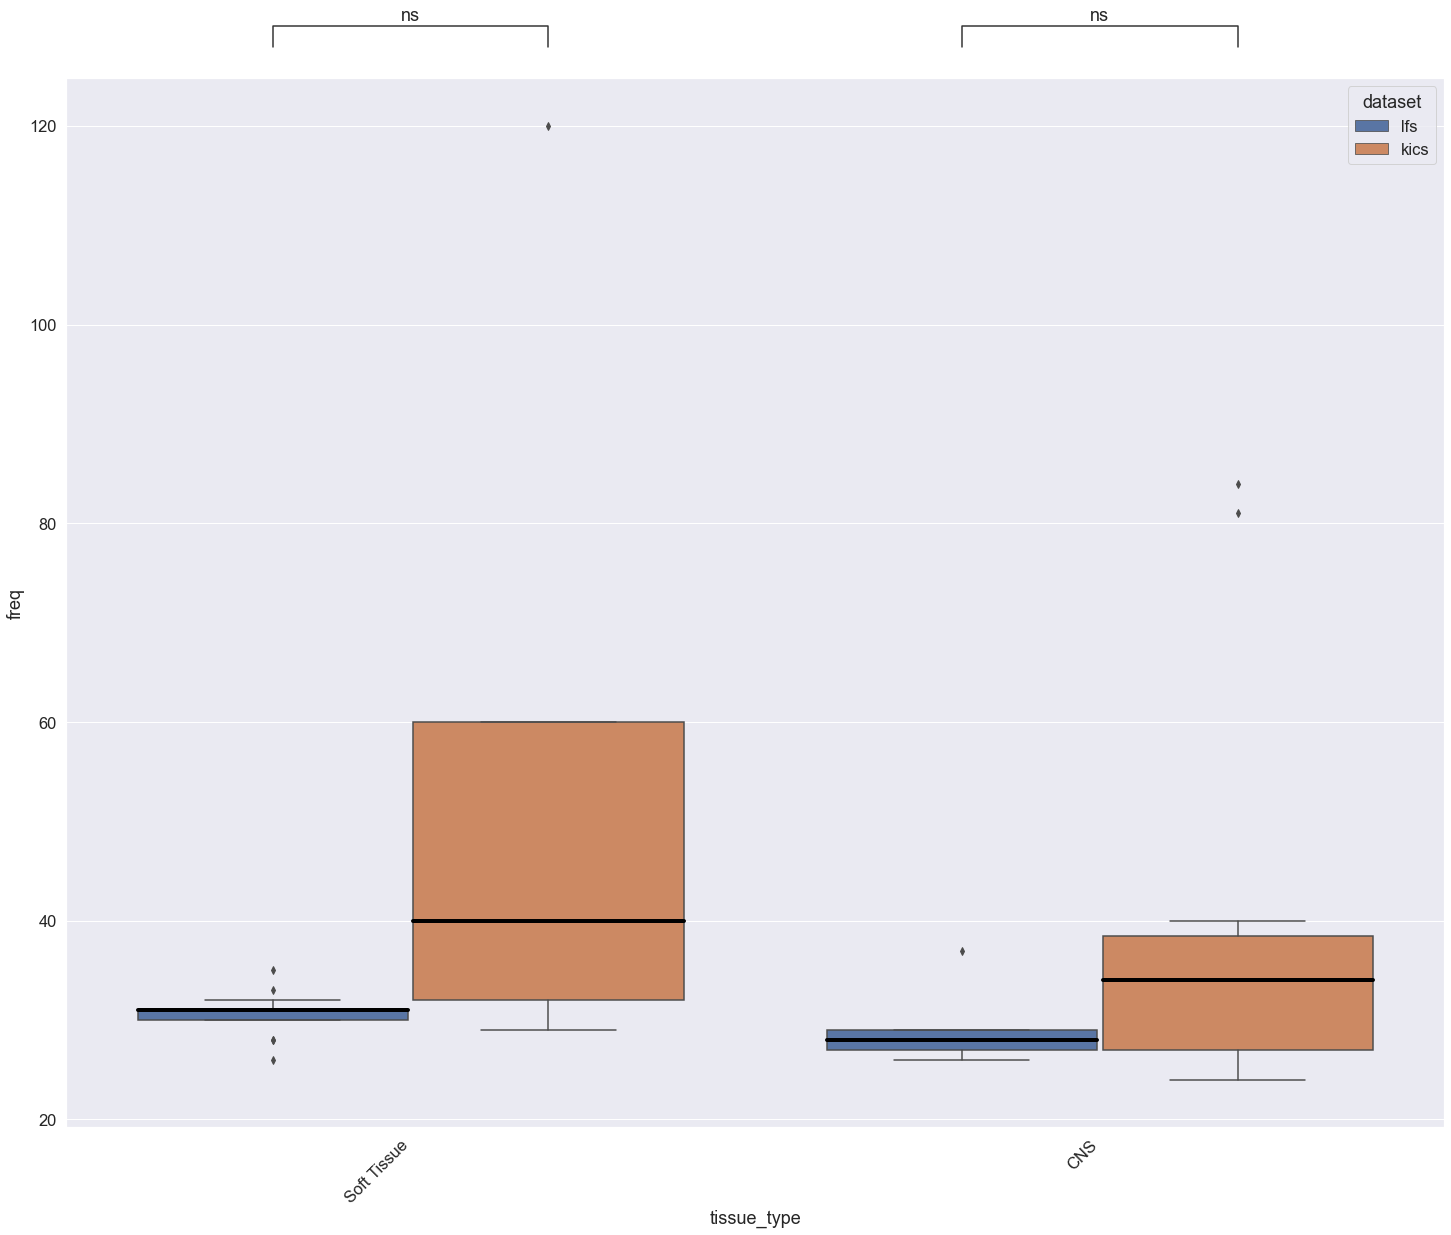

In [180]:
graphSVTissue(kSva.drop(['cancer_diagnosis'],axis=1), lSva.drop(['cancer_diagnosis'],axis=1), uniqueTissue, True)

LFS
  Samples_ID cancer_diagnosis  freq dataset
8       2262              RMS  1229     lfs
the outliers for RMS are:
['2262']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS  4184    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.503e-02 U_stat=7.000e+00


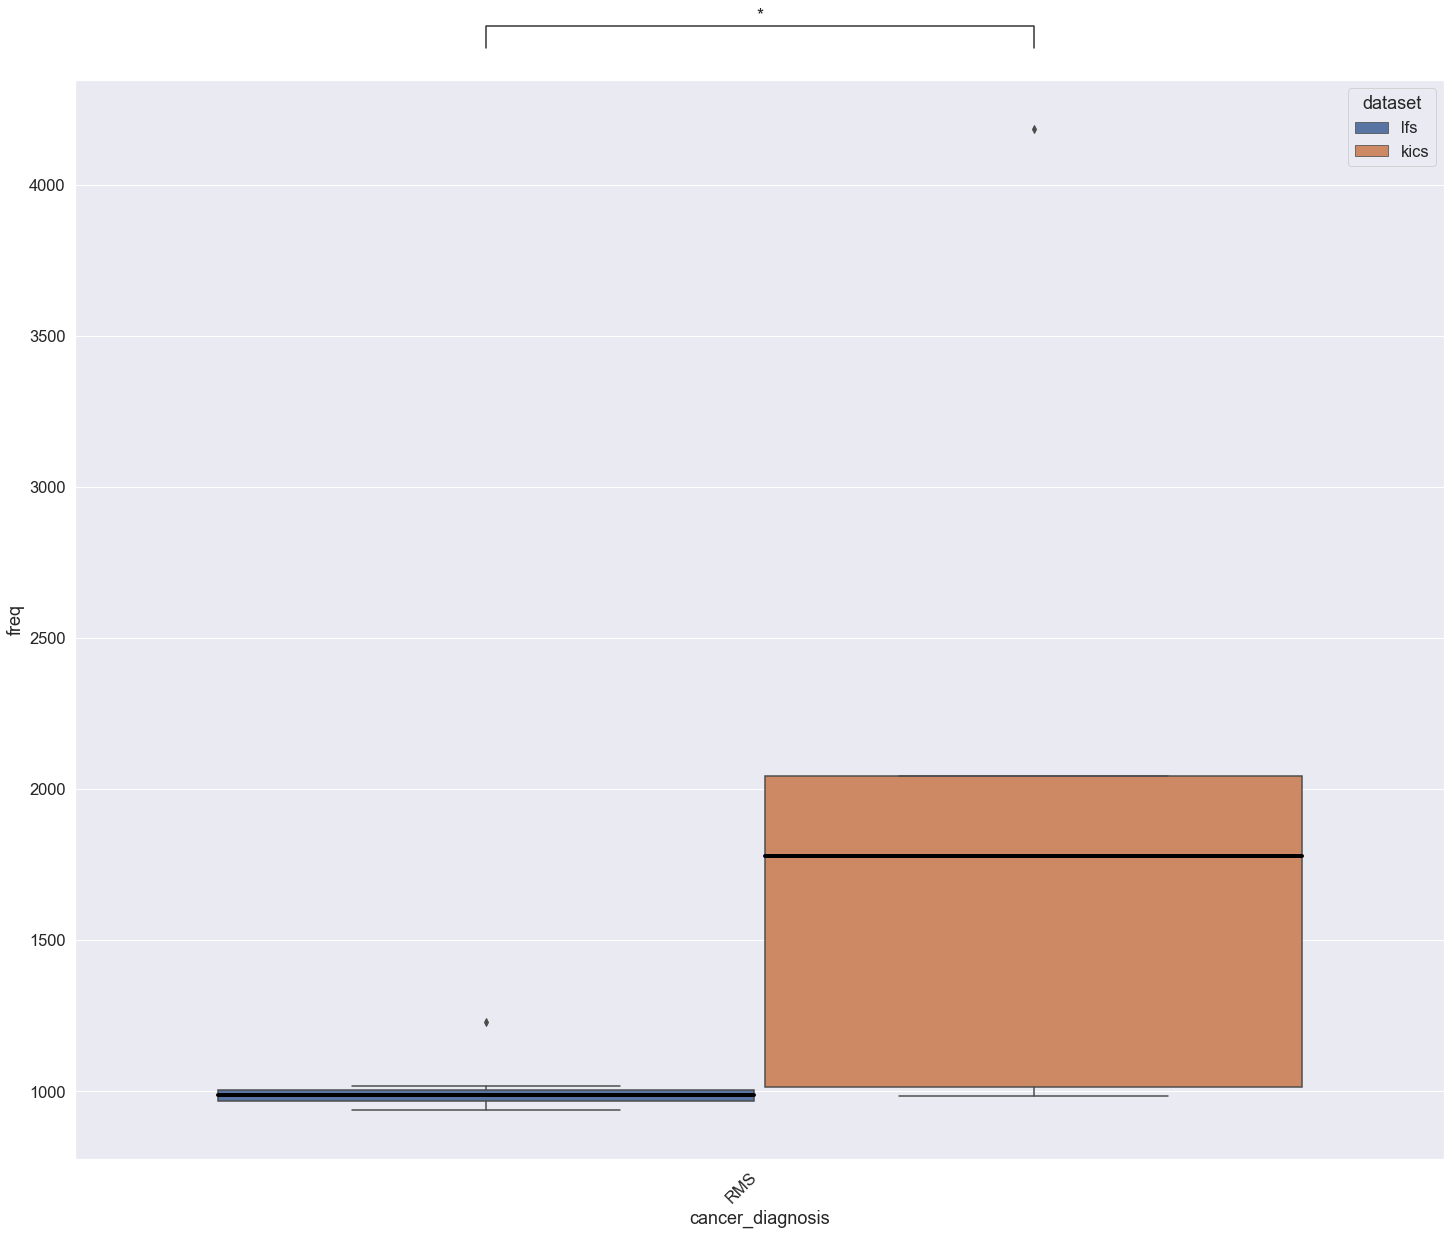

In [181]:
#diagnosis
graphSVTissue(kAlu.drop(['tissue_type'],axis=1), lAlu.drop(['tissue_type'],axis=1), uniqueDiag, False)

LFS
  Samples_ID cancer_diagnosis  freq dataset
8       2262              RMS    66     lfs
the outliers for RMS are:
['2262']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS   212    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:2.280e-02 U_stat=5.000e+00


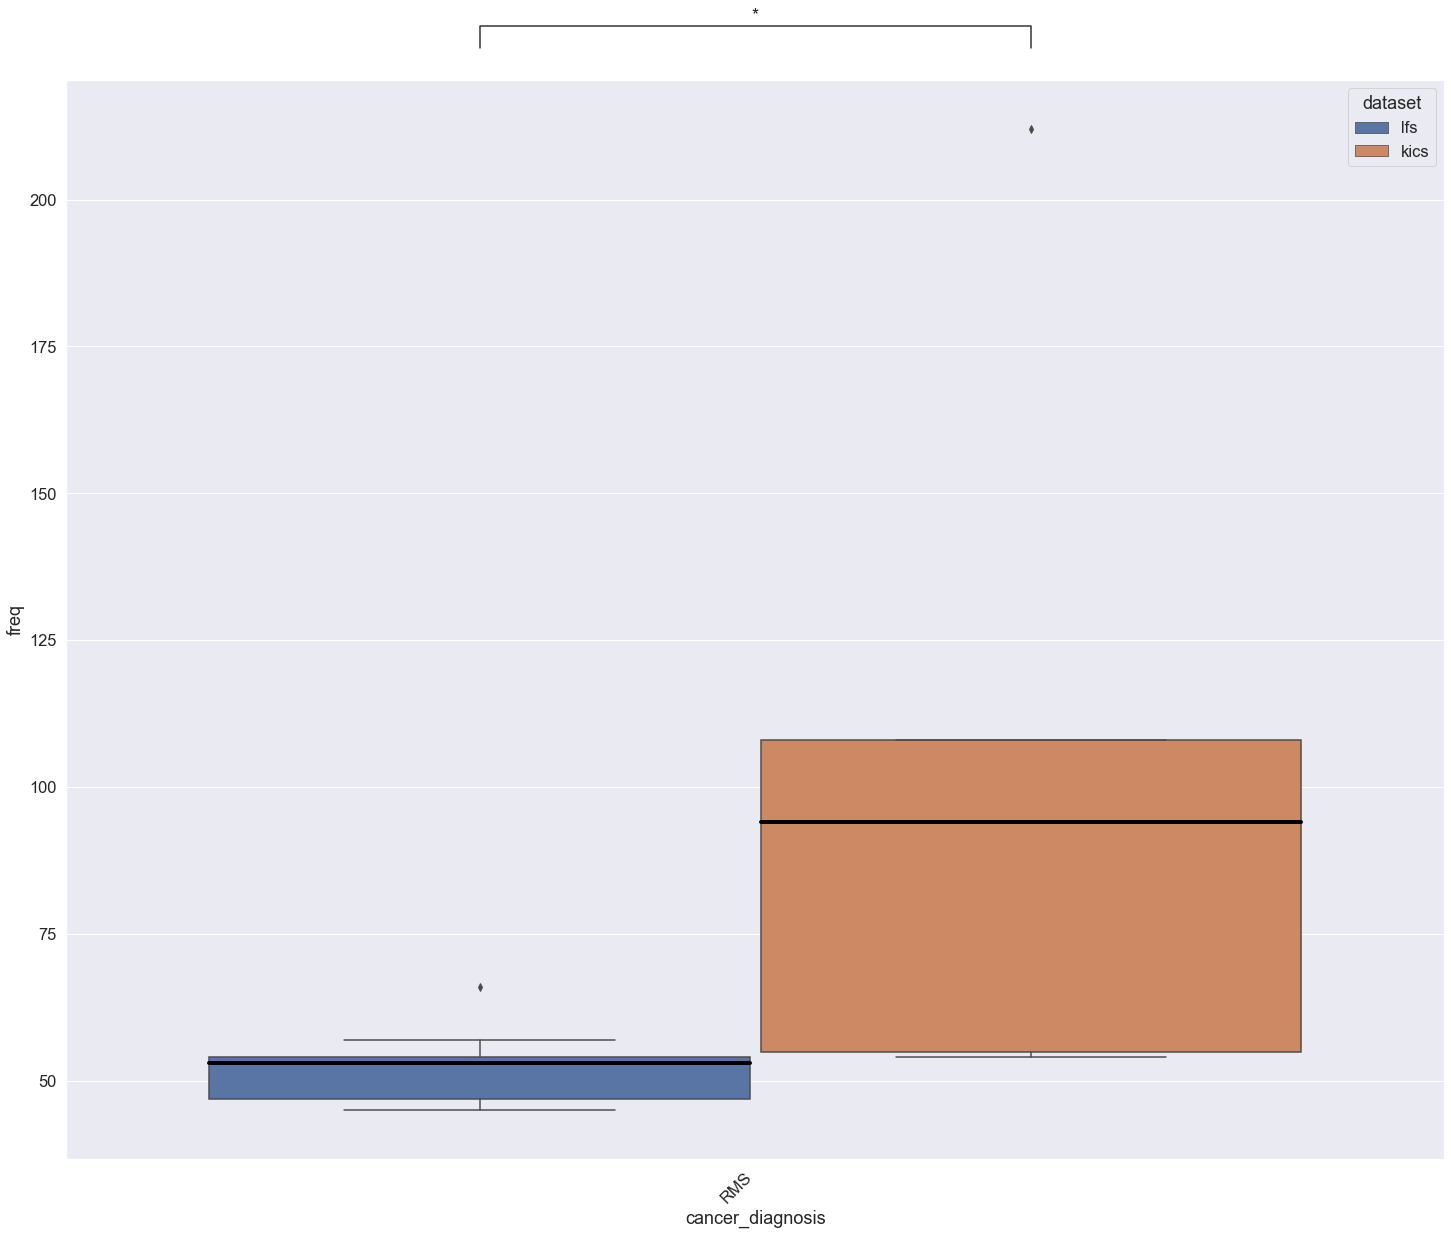

In [182]:
graphSVTissue(kLine.drop(['tissue_type'],axis=1), lLine.drop(['tissue_type'],axis=1), uniqueDiag, False)

LFS
   Samples_ID cancer_diagnosis  freq dataset
47       4227              RMS    35     lfs
49       4329              RMS    26     lfs
the outliers for RMS are:
['4227', '4329']

KICS
  Samples_ID cancer_diagnosis  freq dataset
6     284386              RMS   120    kics
the outliers for RMS are:
['284386']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.206e-01 U_stat=1.050e+01


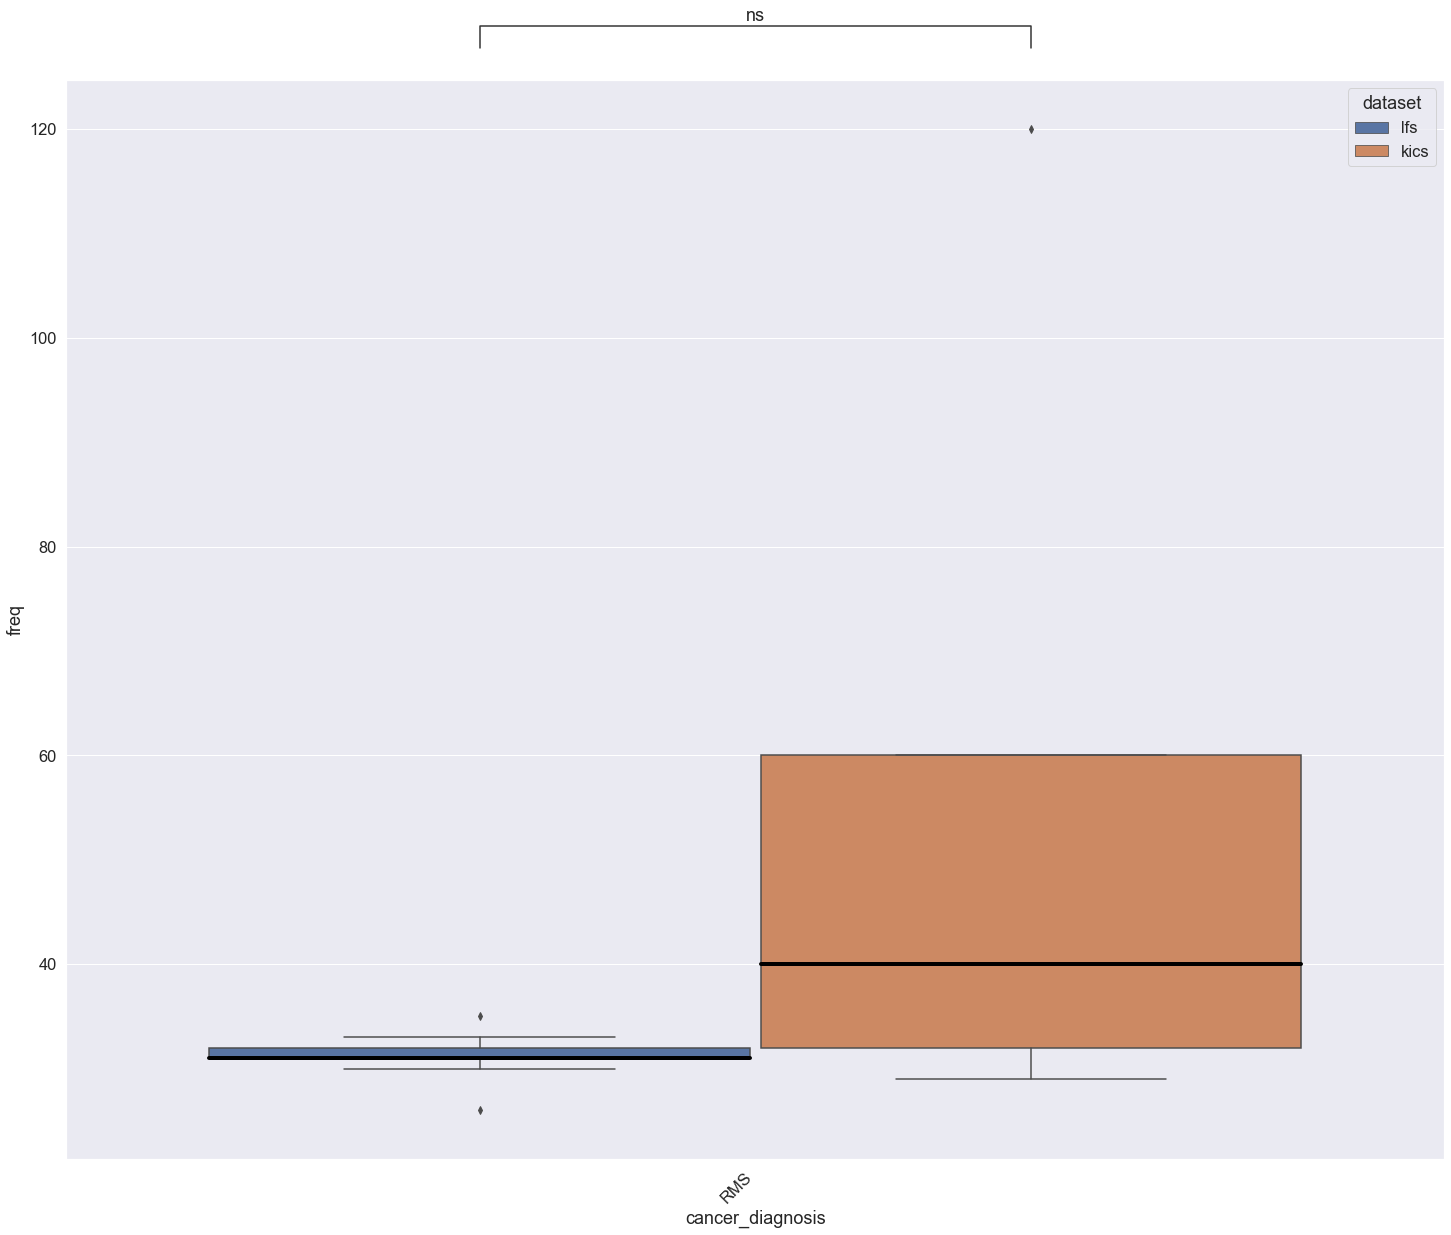

In [183]:
graphSVTissue(kSva.drop(['tissue_type'],axis=1), lSva.drop(['tissue_type'],axis=1), uniqueDiag, False)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFH vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+00
RMS vs. High Grade Sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:8.614e-01 U_stat=3.500e+00
High Grade Sarcoma vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
LMS vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
MFH vs. High Grade Sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
RMS vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+00
High Grade Sarcoma vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
MFH vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
RMS vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:2.000e-01 U_stat=9.000e+00
MFH

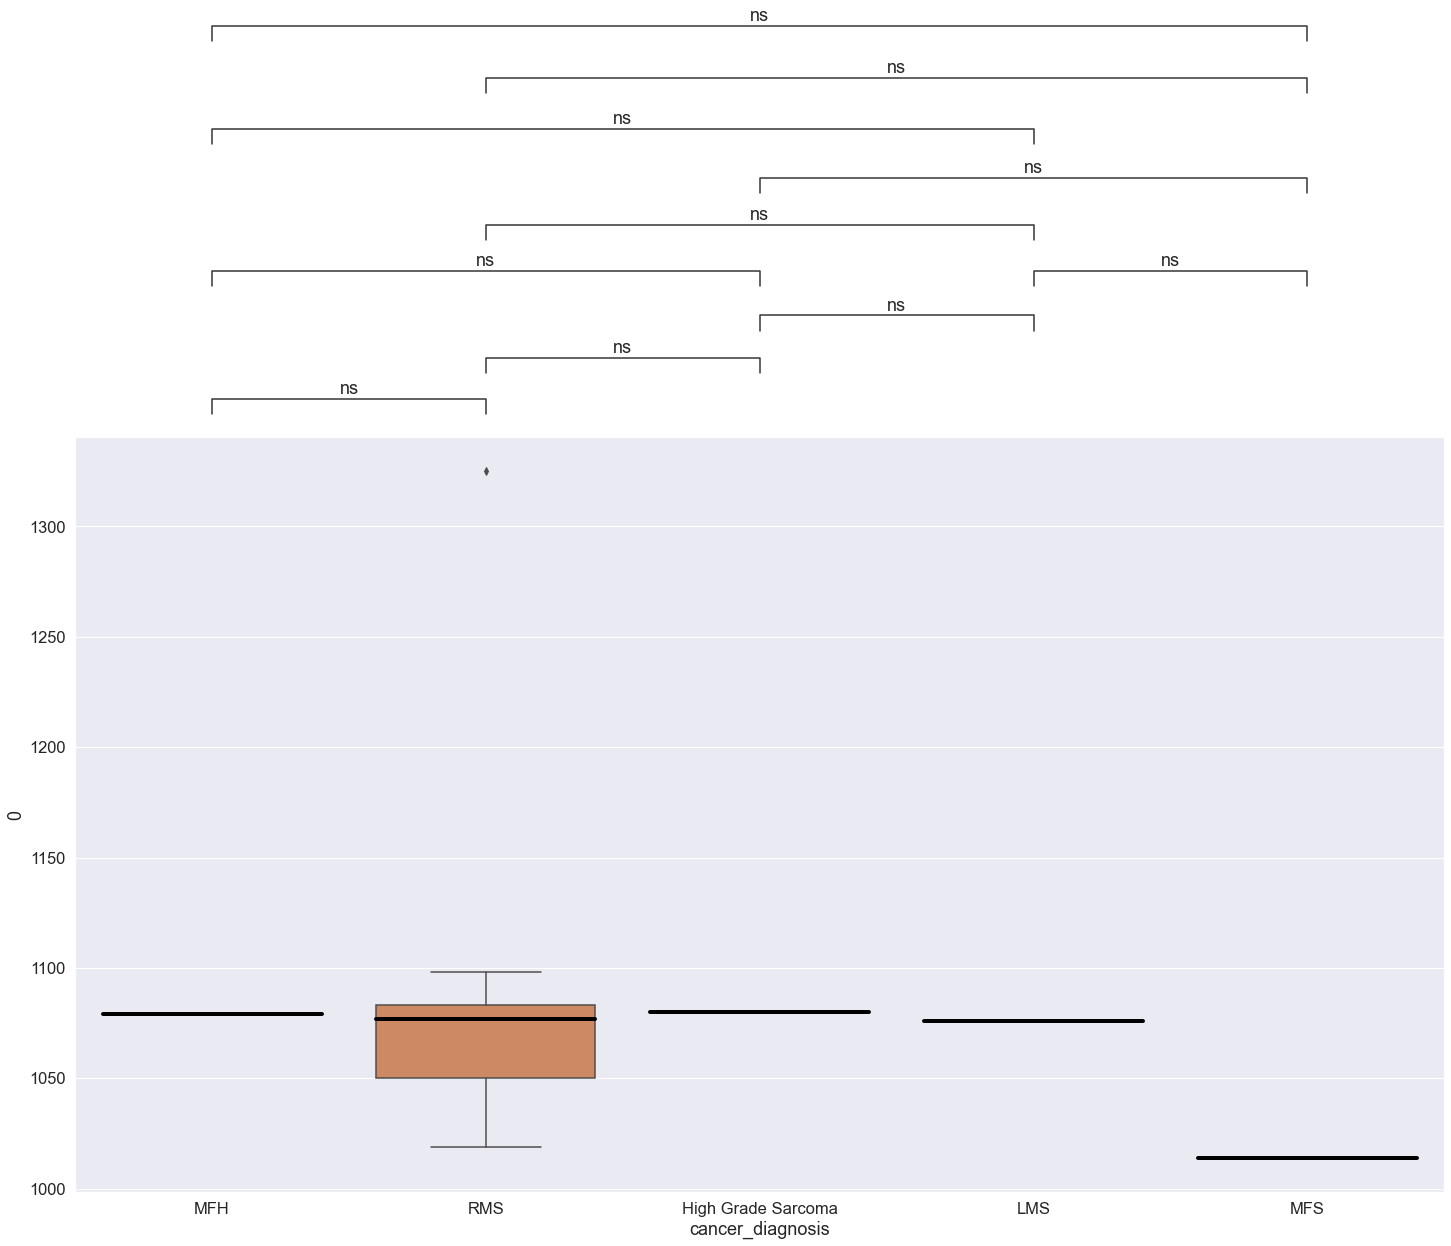

  Samples_ID                                      type  freq dataset  \
0     273308        8920/3 - Alveolar rhabdomyosarcoma  1948    kics   
1     284386  8910/3 - Embryonal Rhabdomyosarcoma, NOS  4516    kics   
2     297043  8910/3 - Embryonal rhabdomyosarcoma, NOS  1073    kics   
3     298866  8910/3 - Embryonal Rhabdomyosarcoma, NOS  1096    kics   
4     305082  8910/3 - Embryonal rhabdomyosarcoma, NOS  2178    kics   
0       1355                           Anaplastic ERMS  1058     lfs   
1       2085                                 ARMS_ERMS  1077     lfs   
2       2262                           Anaplastic ERMS  1325     lfs   
3       2349                           Anaplastic ERMS  1083     lfs   
4      3136A                           Anaplastic ERMS  1080     lfs   
5       3763                           Anaplastic ERMS  1050     lfs   
6       4227                 Alveolar Rhabdomyosarcoma  1019     lfs   
7       4329                Embryonal rhabdomyosarcoma  1098    

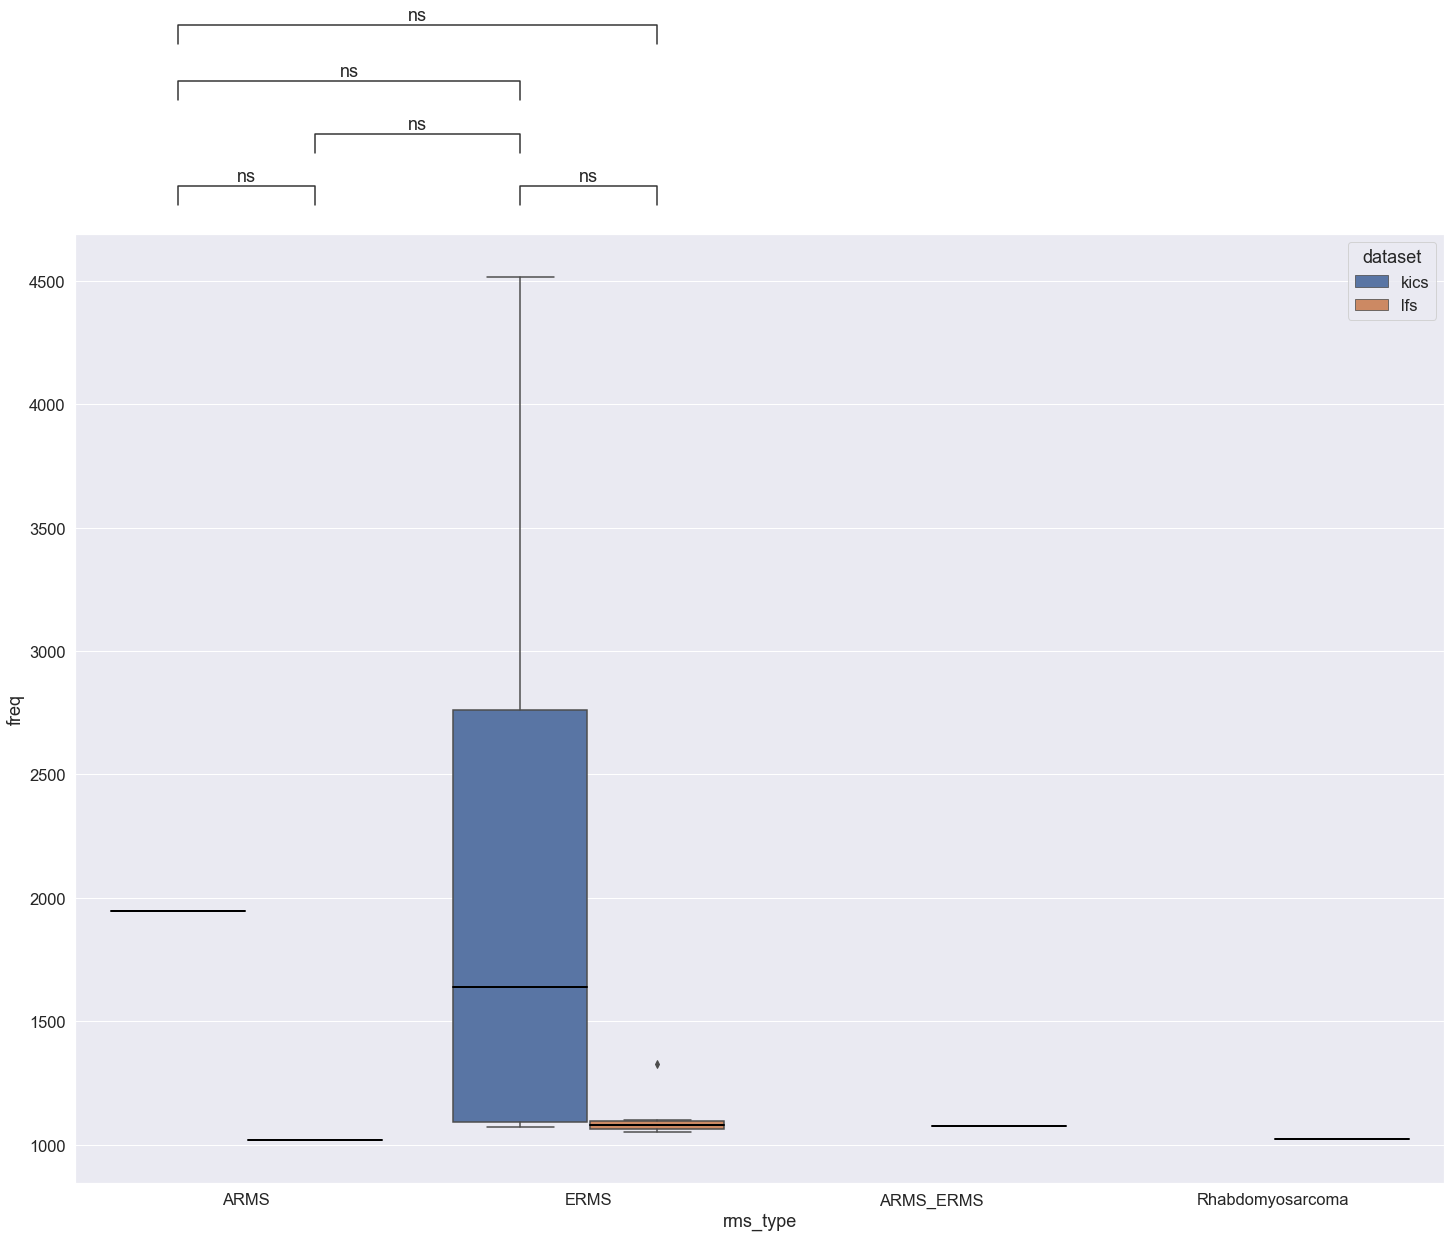

In [187]:
"""
Those in RMS are they A RMS or E RMS (cancer diagnosis)
Those in Soft Tissue, What group are they? (tissue_type)
"""
rmsKDf = UberbigKdf[['Samples_ID','ICDO-diagnosis','tissue_type','lfs_cancer_type_diagnosis']]
rmsLDf = UberbigLdf[['Samples_ID','cancer1','tissue_type','cancer_diagnosis']]

#stKDf = rmsKDf.loc[rmsKDf['tissue_type']=='Soft Tissue']
rmsKDf = rmsKDf.loc[rmsKDf['lfs_cancer_type_diagnosis']=='RMS']

#they are the same for kics
#print(rmsKDf['sample_id'].unique())
#print(stKDf['sample_id'].unique())

rmsKDf = rmsKDf.drop(['tissue_type','lfs_cancer_type_diagnosis'], axis=1).groupby(['Samples_ID']).value_counts().to_frame().reset_index()
rmsKDf['dataset']='kics'

#these are not the same for lfs
stLDf = rmsLDf.loc[rmsLDf['tissue_type']=='Soft Tissue']
stLDf = stLDf.drop(['tissue_type'],axis=1).groupby(['Samples_ID','cancer_diagnosis']).value_counts().to_frame().reset_index()

ax = sns.boxplot(data=stLDf, x='cancer_diagnosis', y=0, medianprops={"linewidth": 4, 'color':'black'})
    
uniqueList = list(stLDf['cancer_diagnosis'].unique())
listPairing = [(a,b) for x, a in enumerate(uniqueList) for b in uniqueList[x+1:]]
        
annot = Annotator(ax, listPairing, data=stLDf, x='cancer_diagnosis', y=0)
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

rmsLDf = rmsLDf.loc[rmsLDf['cancer_diagnosis']=='RMS']
rmsLDf = rmsLDf.drop(['tissue_type','cancer_diagnosis'], axis=1).groupby(['Samples_ID']).value_counts().to_frame().reset_index()
rmsLDf['dataset']='lfs'


#formatting kics
def rmsType(row):
    if ('lveolar' in row['type']) and ('habdomyosarcoma' in row['type']):
        return 'ARMS'
    if ('mbryonal' in row['type']) and ('habdomyosarcoma' in row['type']):
        return 'ERMS'
    if('ERMS' in row['type']) and ('ARMS' not in row['type']):
        return 'ERMS'
    return row['type']


rmsLDf = rmsLDf.rename(columns={'cancer1': 'type',0:'freq'})
rmsKDf = rmsKDf.rename(columns={'ICDO-diagnosis':'type', 0:'freq'})

#print(rmsLDf.apply(lambda row: rmsType(row), axis=1).value_counts())
#print(rmsKDf.apply(lambda row: rmsType(row), axis=1).value_counts())

rmsLDf['rms_type'] = rmsLDf.apply(lambda row: rmsType(row), axis=1)
rmsKDf['rms_type'] = rmsKDf.apply(lambda row: rmsType(row), axis=1)

mergedRMS = pd.concat([rmsKDf,rmsLDf])
print(mergedRMS)

bx = sns.boxplot(data=mergedRMS, x='rms_type', y='freq',hue = 'dataset', medianprops={"linewidth": 2, 'color':'black'})

listPairing = [(('ERMS','kics'),('ERMS','lfs')), (('ERMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','lfs')), (('ARMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','kics'))]

annot = Annotator(bx, listPairing, data=mergedRMS, x='rms_type', y='freq',hue = 'dataset')
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

In [186]:
"""
Search for and print the entire row given sample_id
"""
kid = '271112'
print(UberbigKdf.loc[UberbigKdf['Samples_ID']== kid])

lid = 'PD13489b'
print(UberbigLdf.loc[UberbigLdf['Samples_ID']== lid])

Empty DataFrame
Columns: [Samples_ID, SV_type, abbv_id, ALT, KiCS ID, ICDO-diagnosis, tissue_type, lfs_cancer_type_diagnosis, Revised diagnosis based on NGS, Previous cancers, Include/Exclude in paper, EP1/EP2, Germline only, CCP germline, Germline Sample from, Germline sample type, CCP germline.1, WGS DNA germline, WGS germline, pathology_id, Sample type, CCP tumor, CCP PPID, CCP, WGS tumor ID, WGS Tumor, RNA ID, RNA, single_somatic_specimen, surgical date for the sample, disease_state, sample_type, post_treatment, sample site, tumour_class, Sex, diagnosis_age (days), enrollment_age (days or deceased), somatic_finding_a, somatic_finding_b, somatic_finding_c, somatic_finding_d, germline_finding_a, germline_finding_b, germline_finding_c, germline_finding_d, actionable_findings_order, abbreviation, NRSTS, disease_state_number, total_samples_count, chron_sample_number, pathology_specimens, no_chemo_or_xrt, previous_xrt, xrt_location, infield_radiation, chemo_info, nitrogen_mustards, plati